In [1]:

import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [142]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Import data**

In [102]:
tokeep = ['Tcells','Monocytes','Bcells']

chosen = [tokeep] #[['L5_IT','L2-3_IT','L6_IT'],['L6_CT','L2-3_IT','L6_IT']] 
individs = []
for names in chosen:
    individs += [[i] for i in names]

In [103]:
num_ks = 5
ks = [1,3,5,10,15] #1,4,10

In [104]:
dataset_meta = ['pbmc_10k_v3']

subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

subcluster_names += individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(len(ks)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []

#cluster_names = ['Tcells','Monocytes','Bcells']

dataset_names = [x+'_'+y for x in dataset_meta for y in sub_names_only]  
raw_data_locations = [x for x in dataset_meta for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/10x_pbmcs/loom/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

In [105]:
dataset_names

['pbmc_10k_v3_Tcells_Monocytes_Bcells_k1',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k3',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k5',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k10',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k15',
 'pbmc_10k_v3_Tcells',
 'pbmc_10k_v3_Monocytes',
 'pbmc_10k_v3_Bcells']

In [10]:
# markers = ['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
#       'CD93','CSTA','FPR1','CD14','CD36',
#       'CD79A','CD22','BLK','IGHD','VPREB3']

#From Cell Atlas - cite Angel/Sina
all_marks = pd.read_csv('/home/tchari/metadata/all_pbmc_markers.csv')
print(all_marks.head())
markers = list(all_marks['gene_name'])
print(len(markers))

  gene_name  num_cell_types
0     PTPRC              28
1      CD14              27
2     IL-7R              24
3      CD3D              24
4    FCG3RA              23
2345


In [11]:
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

filt_markers = [m for m in markers if m in list(annots[0])]
len(filt_markers)

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


1999

In [12]:
dups = ['FCGR2C','GGTA1P', 'ANKRD36BP1', 'HSPA7','HLA-DRB4','HLA-DRB3','HLA-DPB2','GVINP1',
'ANXA2P2','DENND10P1','CES1P1','CORO7-PAM16','CRYM-AS1','WHAMMP3','SUZ12P1','STING1', 
'STAG3L1','STAG3L3','STAG3L4', 'TM4SF19-TCTEX1D2','KDM5D','LCT-AS1','KIR2DS2','KIR2DS5',
'KIR3DS1','PMS2P5','PALM2AKAP2','NCF1B','NCF1C']
filt_markers = [i for i in filt_markers if i not in dups]
len(filt_markers)

1970

In [13]:
#Filter again for acceptable U/S bounds
#Read in loom + layers
ds = lp.connect('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom')
s = ds.layers['spliced'][:,:]
u = ds.layers['unspliced'][:,:]
g_names = ds.ra['gene_name']
expr_filt = monod.preprocess.threshold_by_expression(s,u)
ds.close()

In [14]:
fin_markers = set(filt_markers).intersection(list(g_names[expr_filt]))
len(fin_markers)

876

In [15]:
fin_markers = list(fin_markers)

## **Filter Cells/Barcodes**

In [106]:
cluster_annotations = []
for k in range(len(dataset_meta)):
    cluster_assignments = pd.read_csv(f'/home/tchari/metadata/{dataset_meta[k]}_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
    print(cluster_assignments['Barcode'].str[-1:].unique())
    cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
    cluster_annotations.append(cluster_assignments)

['1']


In [107]:
clus_names = dict(zip([1,2,3,4],['Tcells','Monocytes','Bcells','Other']))
clus_names

{1: 'Tcells', 2: 'Monocytes', 3: 'Bcells', 4: 'Other'}

In [108]:
cluster_annotations[0]['Cluster_name'] = [clus_names[i] for i in cluster_annotations[0]['Cluster']]
cluster_annotations[0].head()

Barcode  Cluster Cluster_name
0  AAACCCAAGCGCCCAT        1       Tcells
1  AAACCCAAGGTTCCGC        2    Monocytes
2  AAACCCACAGAGTTGG        2    Monocytes
3  AAACCCACAGGTATGG        1       Tcells
4  AAACCCACATAGTCAC        3       Bcells

Dataset pbmc_10k_v3. 
	11756 barcodes in loom, 11171 pass filter. 11769 in annotations; of these, 11536 in loom and 11121 in filtered loom.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells']: 5376 cells in annotations. 5375 in loom. 5339 pass filter.
	['Monocytes']: 3973 cells in annotations. 3972 in loom. 3933 pass filter.
	['Bcells']: 1650 cells in annotations. 1650 in loom. 1641 pass filter.


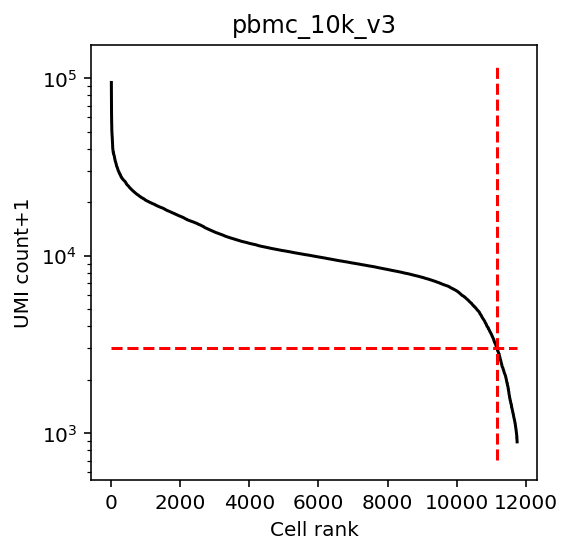

In [109]:
cf = []
thr_lb = [3e3]
fig1,ax1 = plt.subplots(1,1,figsize=(4,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k ]
    dataset_name = raw_data_locations[len(subcluster_names)*k ]
    
    clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(clusters)
        annot_bcs_in_loom = clusters['Barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = clusters['Barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for j,cluster in enumerate(subcluster_names):
            annot_bcs = clusters[clusters['Cluster_name'].isin(cluster)]['Barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)

In [110]:
all_assigns = [list(clusters['Cluster_name'][clusters['Barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns)) #Manual_Annotation, Phase, sub_annotation

10913


In [235]:
# #Select for hvgs
# adata = sc.read_loom('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom') #sc
# bars = bcs[cf[0]]
# adata_sub = adata[adata.obs['barcode'].isin(bars)]
# adata_sub
#

In [102]:
# sc.pp.normalize_total(adata_sub, target_sum=1e4)
# sc.pp.log1p(adata_sub)
# sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)

# # Subset to highly variable genes
# adata_hvg = adata_sub[:, adata_sub.var.highly_variable]

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [103]:
# #adata_hvg = adata_sub
# adata_hvg.layers['spliced'].shape

(10913, 1999)

In [104]:
# hvgs = adata.var['gene_name'][adata_sub.var.highly_variable]
# len(hvgs)

1999

## **Gene Filtering**

In [111]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k1
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k3
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k5
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained

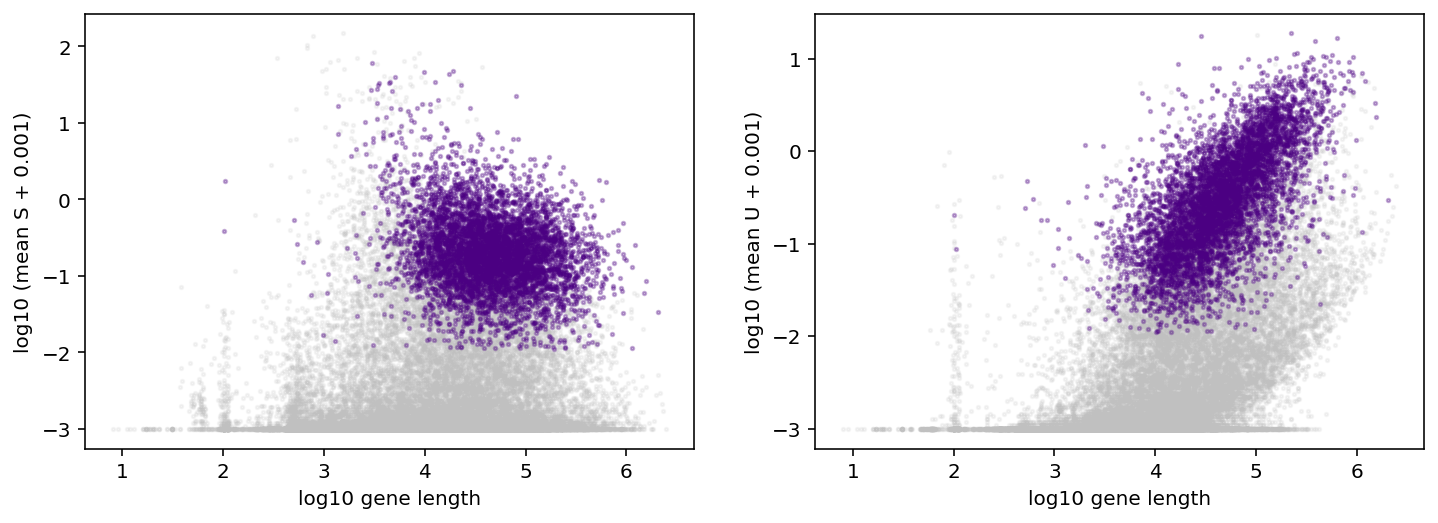

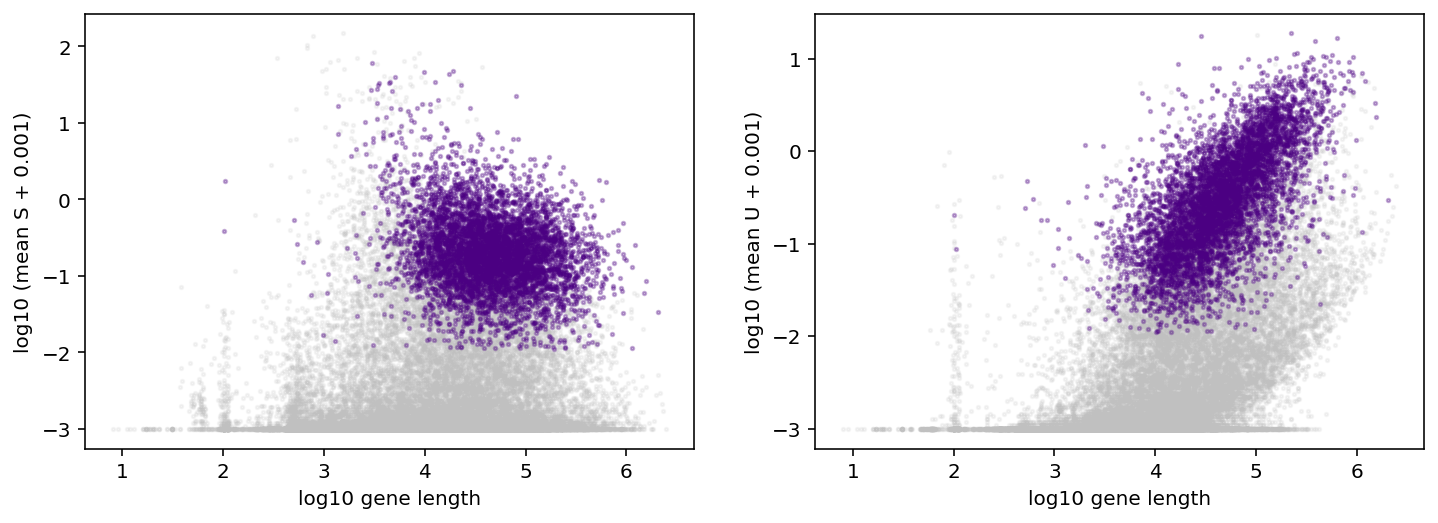

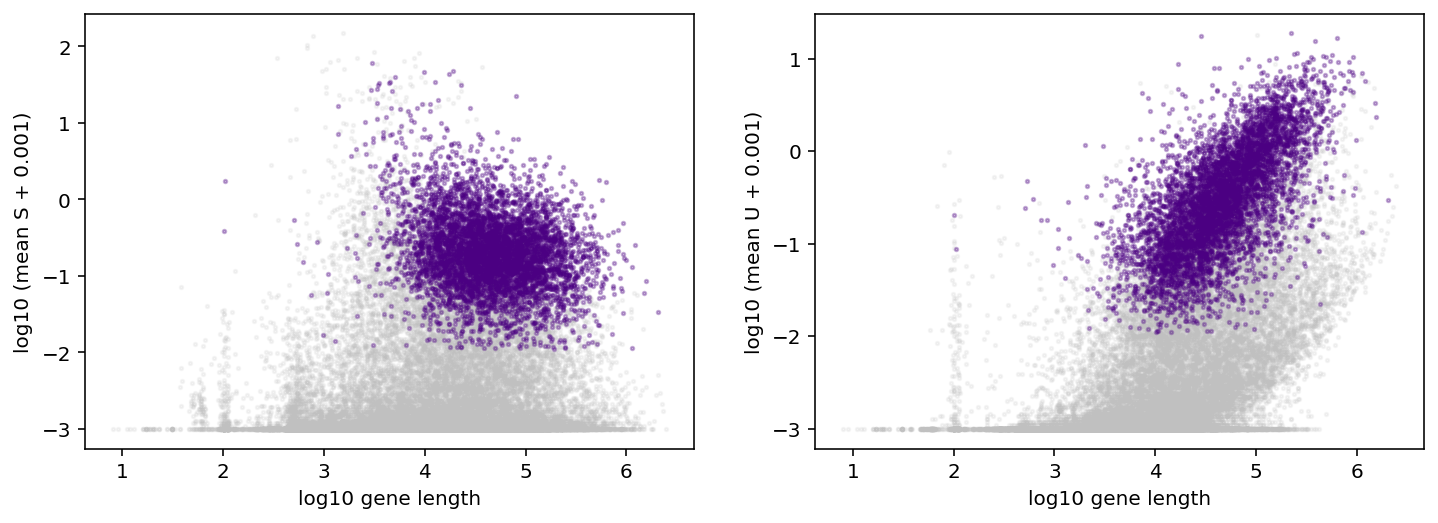

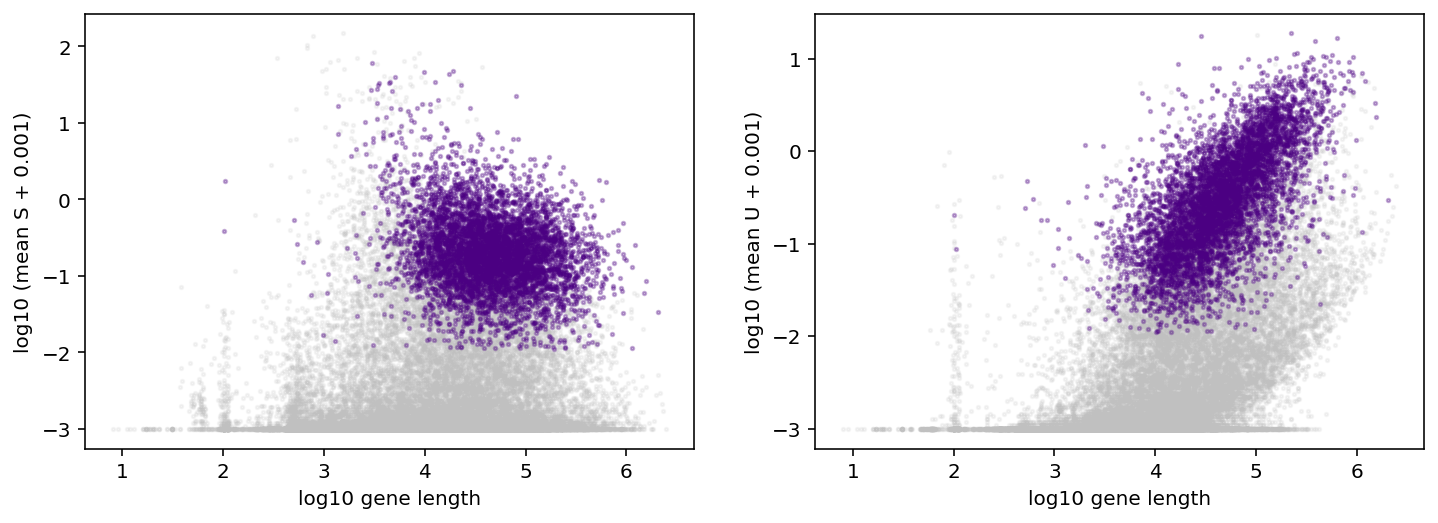

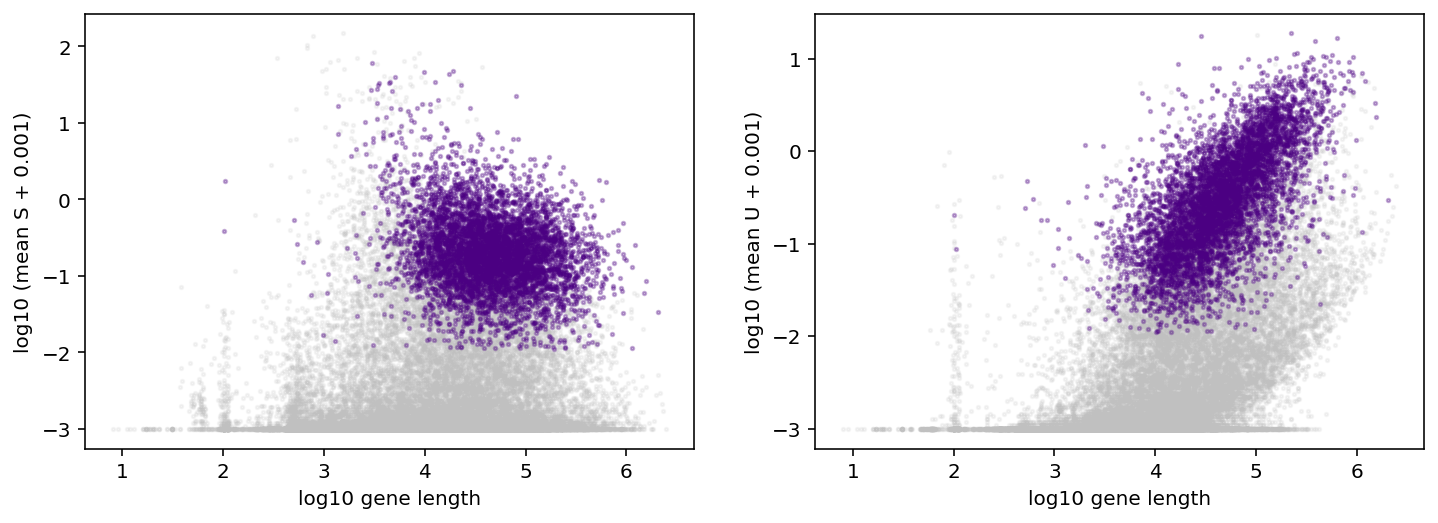

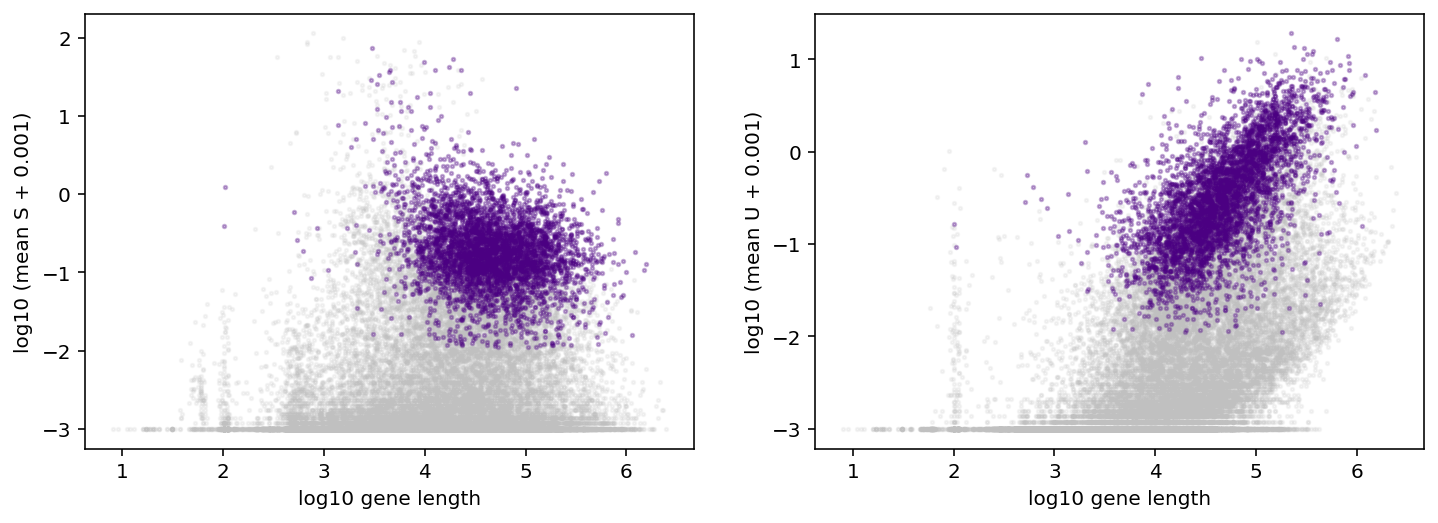

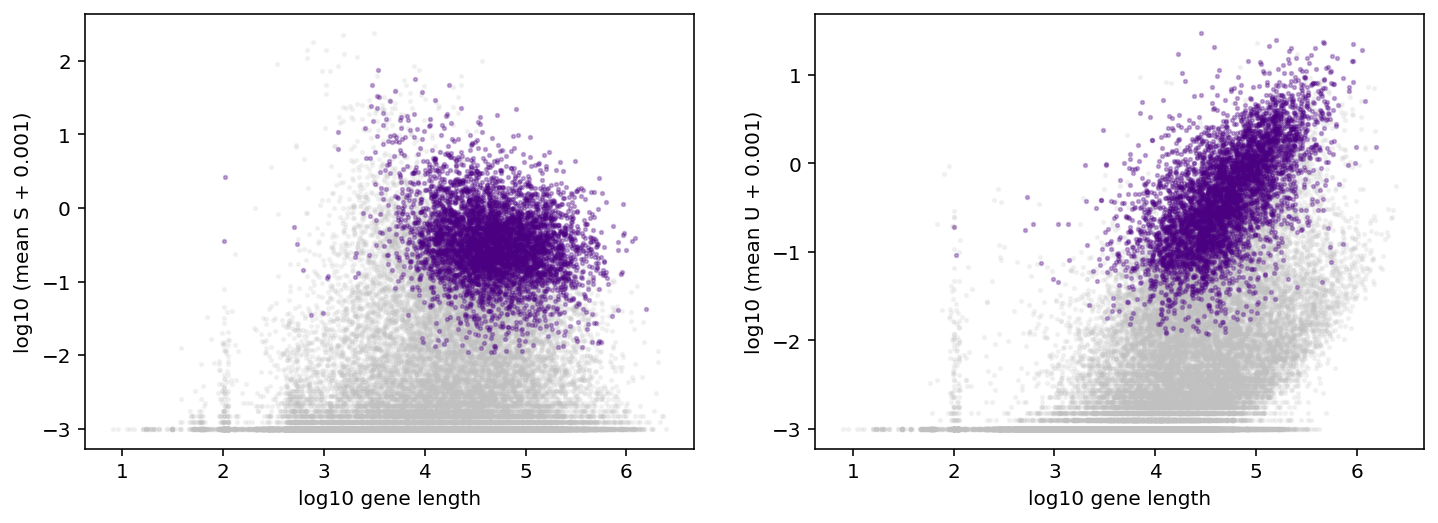

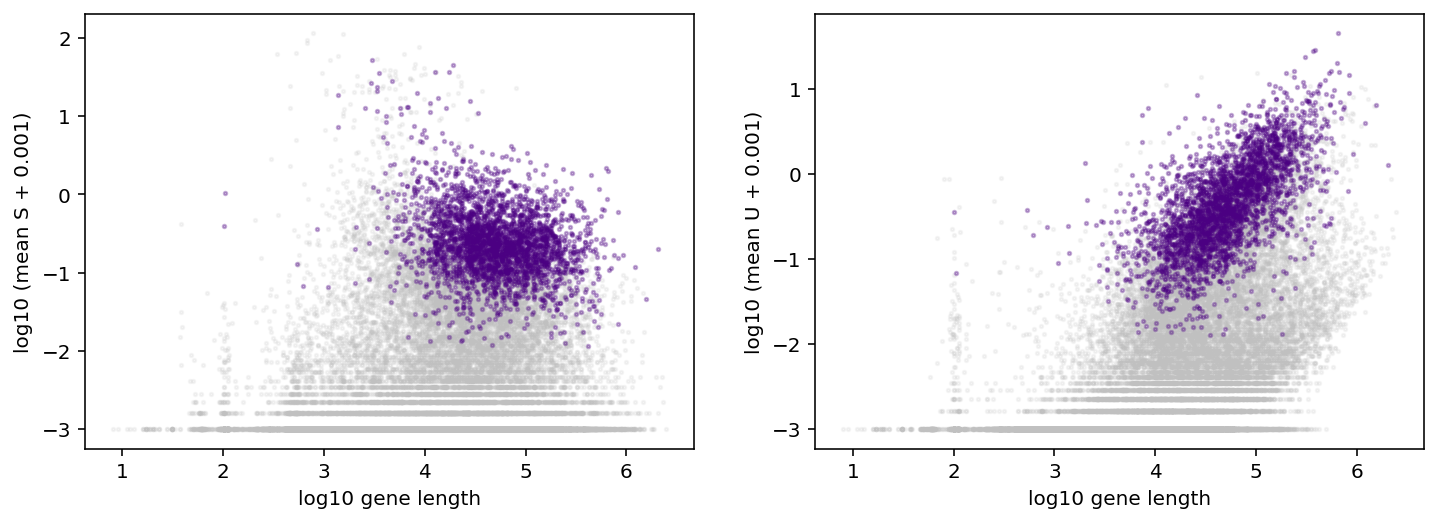

In [113]:
#Get genes.csv
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='pbmc_MM',batch_id=1,\
                                             datestring='230426', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf) 
#hvgs,1900, 2000

In [114]:
dir_string = './fits/gg_230426_025_pbmc_MM_1' #230425
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k10', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes', './fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Bcells']


Make genes.csv with known markers as well

In [301]:
sel_genes = pd.read_csv('./fits/gg_230426_025_pbmc_MM_1/genes.csv',header=None) #fin_markers
sel_genes.head()

0       1       2      3     4      5         6       7     8      9    \
0  VPS13D  KCNAB2  KLHL20  DHDDS  COPA  RNF11  RABGAP1L  NOTCH2  PUM1  RC3H1   

   ...    990      991    992    993    994      995  996   997      998  \
0  ...  SASH3  TRAPPC2  ZMAT1  APOOL  BRWD3  CYSLTR1  OGT  PDK3  SH3KBP1   

     999  
0  PRPS2  

[1 rows x 1000 columns]

In [308]:
first_sel = list(sel_genes.iloc[0])

In [309]:
remain = list((set(first_sel)^set(fin_markers))&set(first_sel))
for i in range(len(fin_markers)):
    sel_genes[i] = fin_markers[i]
    
for i in range(len(fin_markers),1000):
    sel_genes[i] = remain[i-len(fin_markers)]
    
sel_genes.head()

0       1    2       3     4       5         6      7        8      9    \
0  FCER1G  SLC3A2  GNS  SLC7A5  ETFB  MAP4K4  CACNA2D3  SRPK2  RNF144B  IL2RA   

   ...   990    991    992   993    994   995    996     997    998    999  
0  ...  PPIG  SENP6  FBXO4  VAV1  LARP1  UPF2  ACBD3  POU2F1  ZFP91  CEP57  

[1 rows x 1000 columns]

In [313]:
sel_genes.to_csv('./fits/gg_230426_025_pbmc_MM_1/genes.csv',header=None,index=None)

In [314]:
#Check looks ok
test = pd.read_csv('./fits/gg_230426_025_pbmc_MM_1/genes.csv',header=None)
test.head()

0       1    2       3     4       5         6      7        8      9    \
0  FCER1G  SLC3A2  GNS  SLC7A5  ETFB  MAP4K4  CACNA2D3  SRPK2  RNF144B  IL2RA   

   ...   990    991    992   993    994   995    996     997    998    999  
0  ...  PPIG  SENP6  FBXO4  VAV1  LARP1  UPF2  ACBD3  POU2F1  ZFP91  CEP57  

[1 rows x 1000 columns]

Check k-means inits

In [118]:
all_groups_kmeans = []

INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230426_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1/raw.sd.
(10913, 1000)
(10913, 1000)
(10913, 1000)
(10913, 1000)
(10913, 1000)


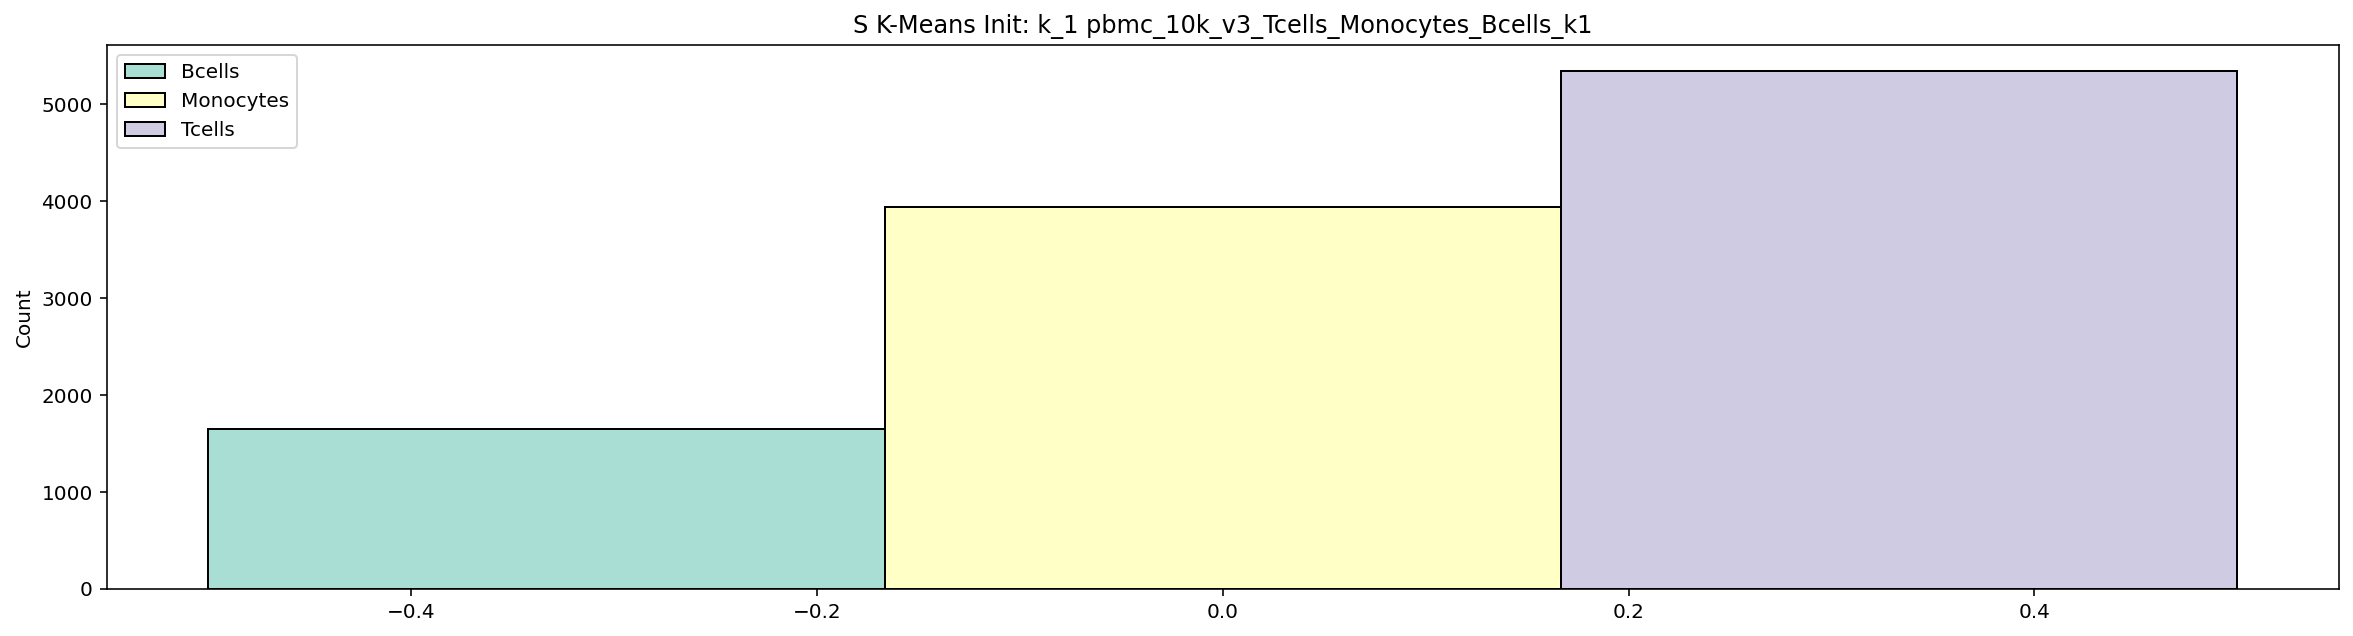

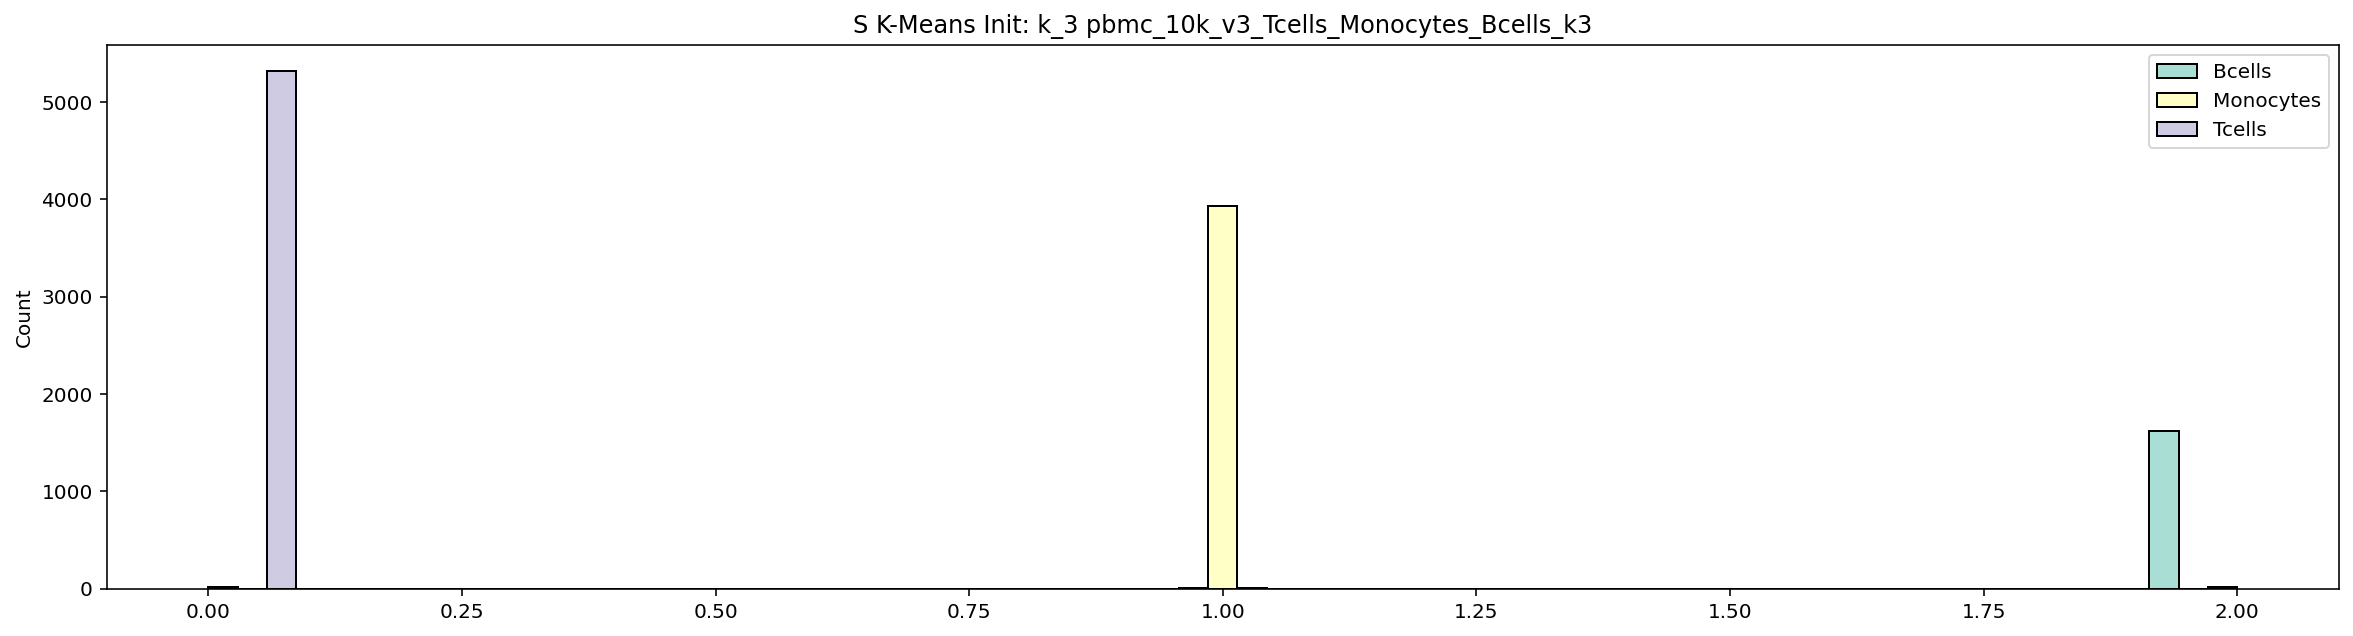

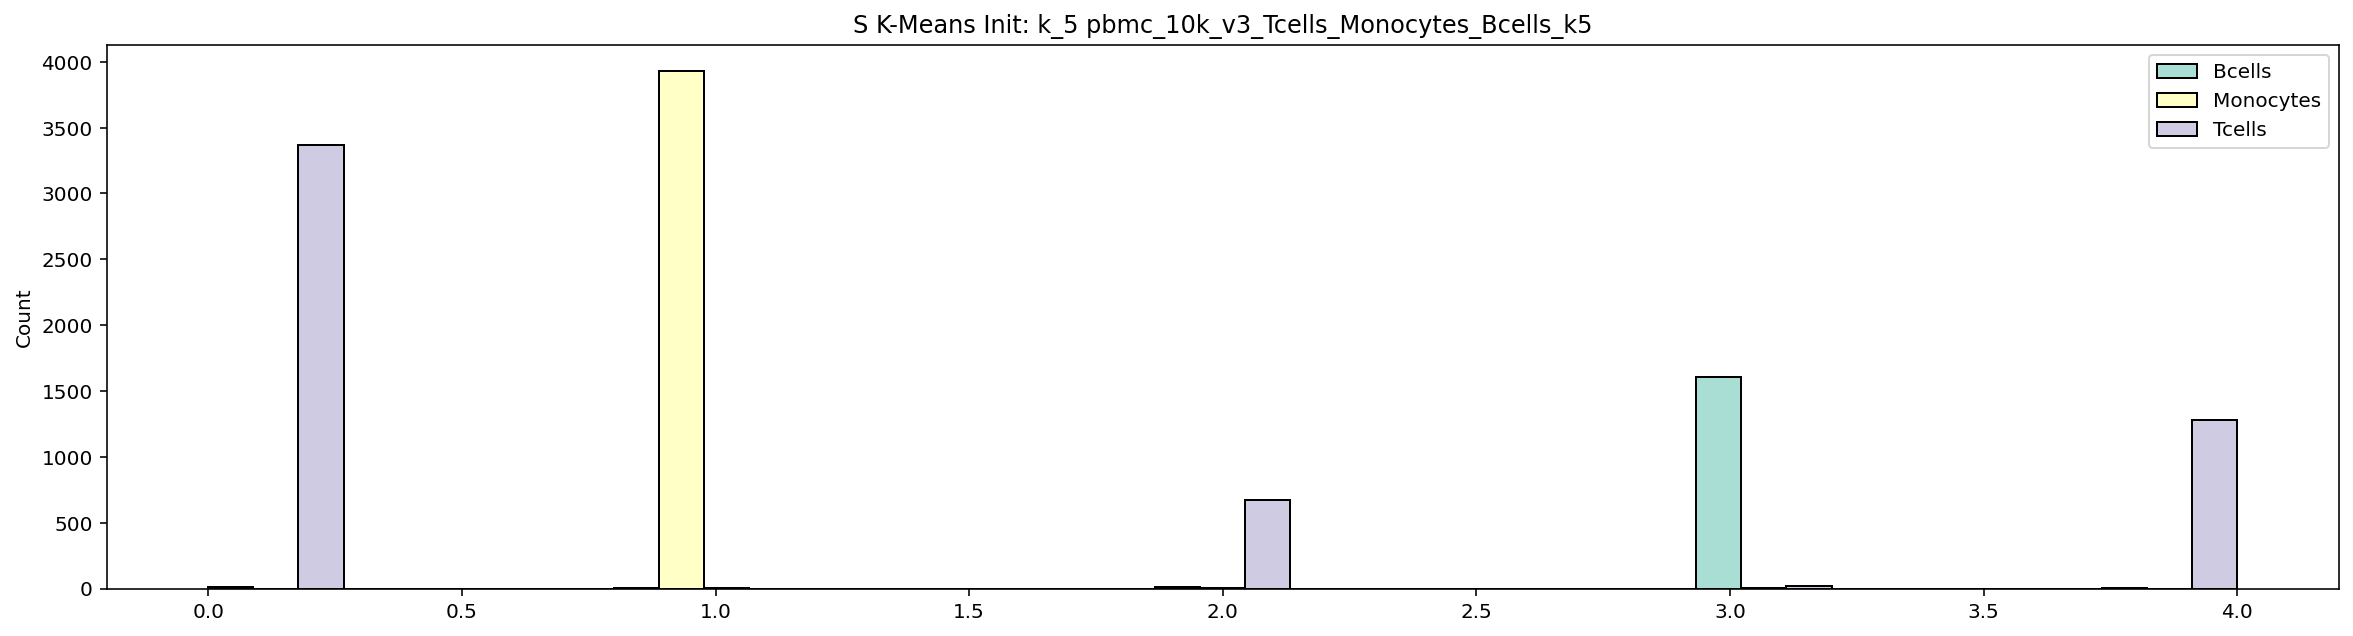

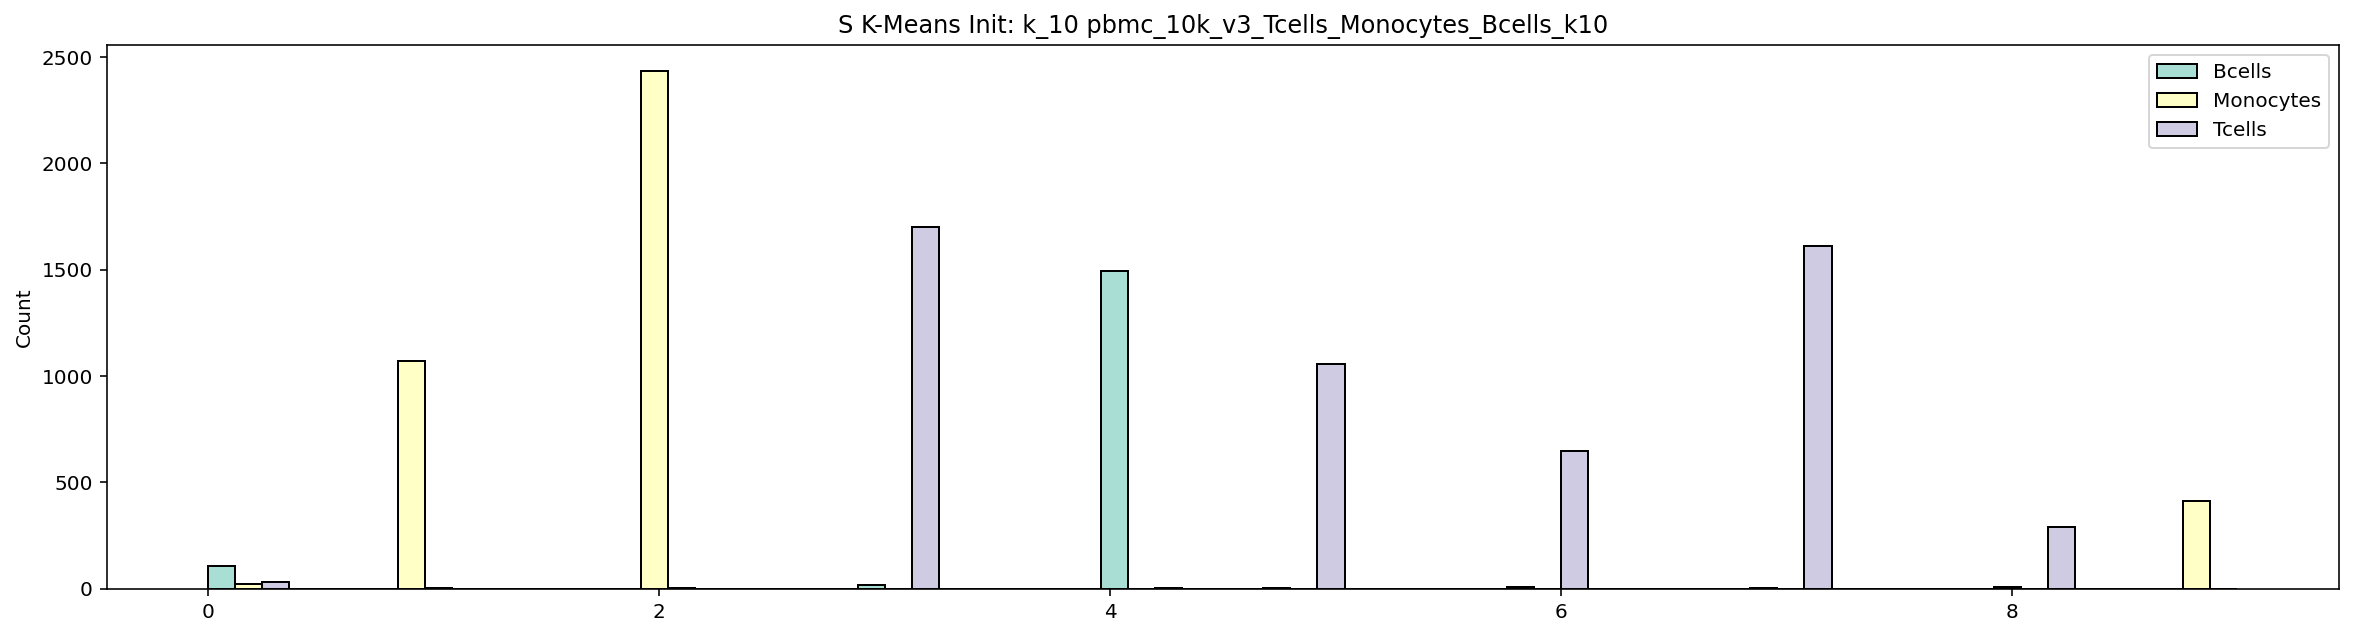

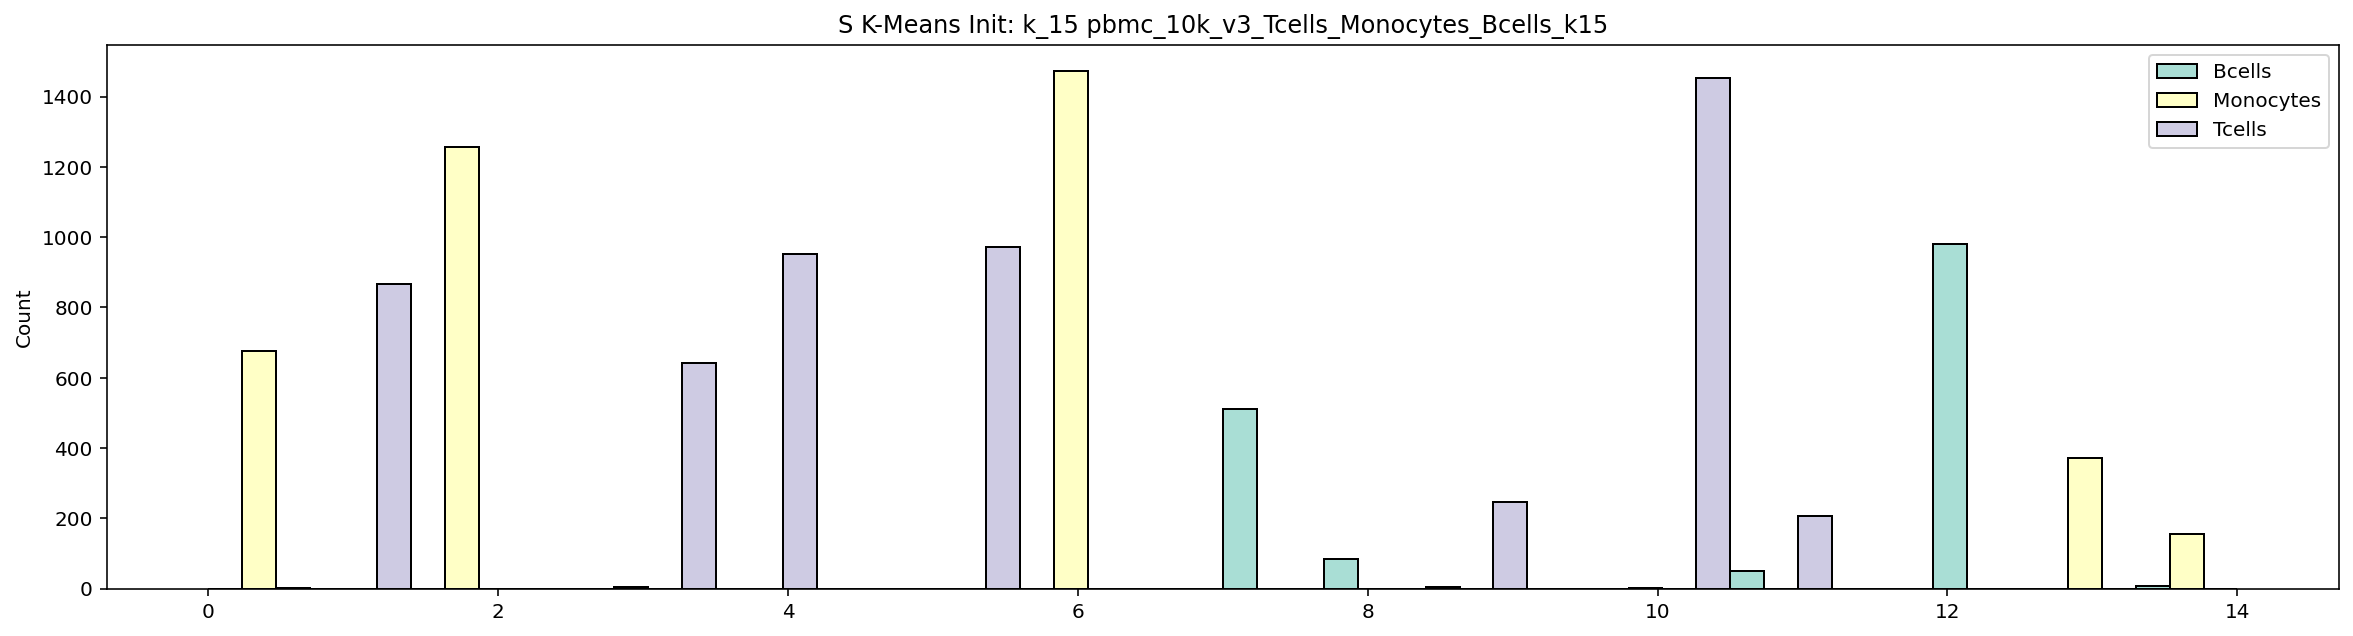

In [119]:
#For easier demonstration
#Check initializations of clusters
which = 0
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('S K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])




(10913, 1000)
(10913, 1000)
(10913, 1000)
(10913, 1000)
(10913, 1000)


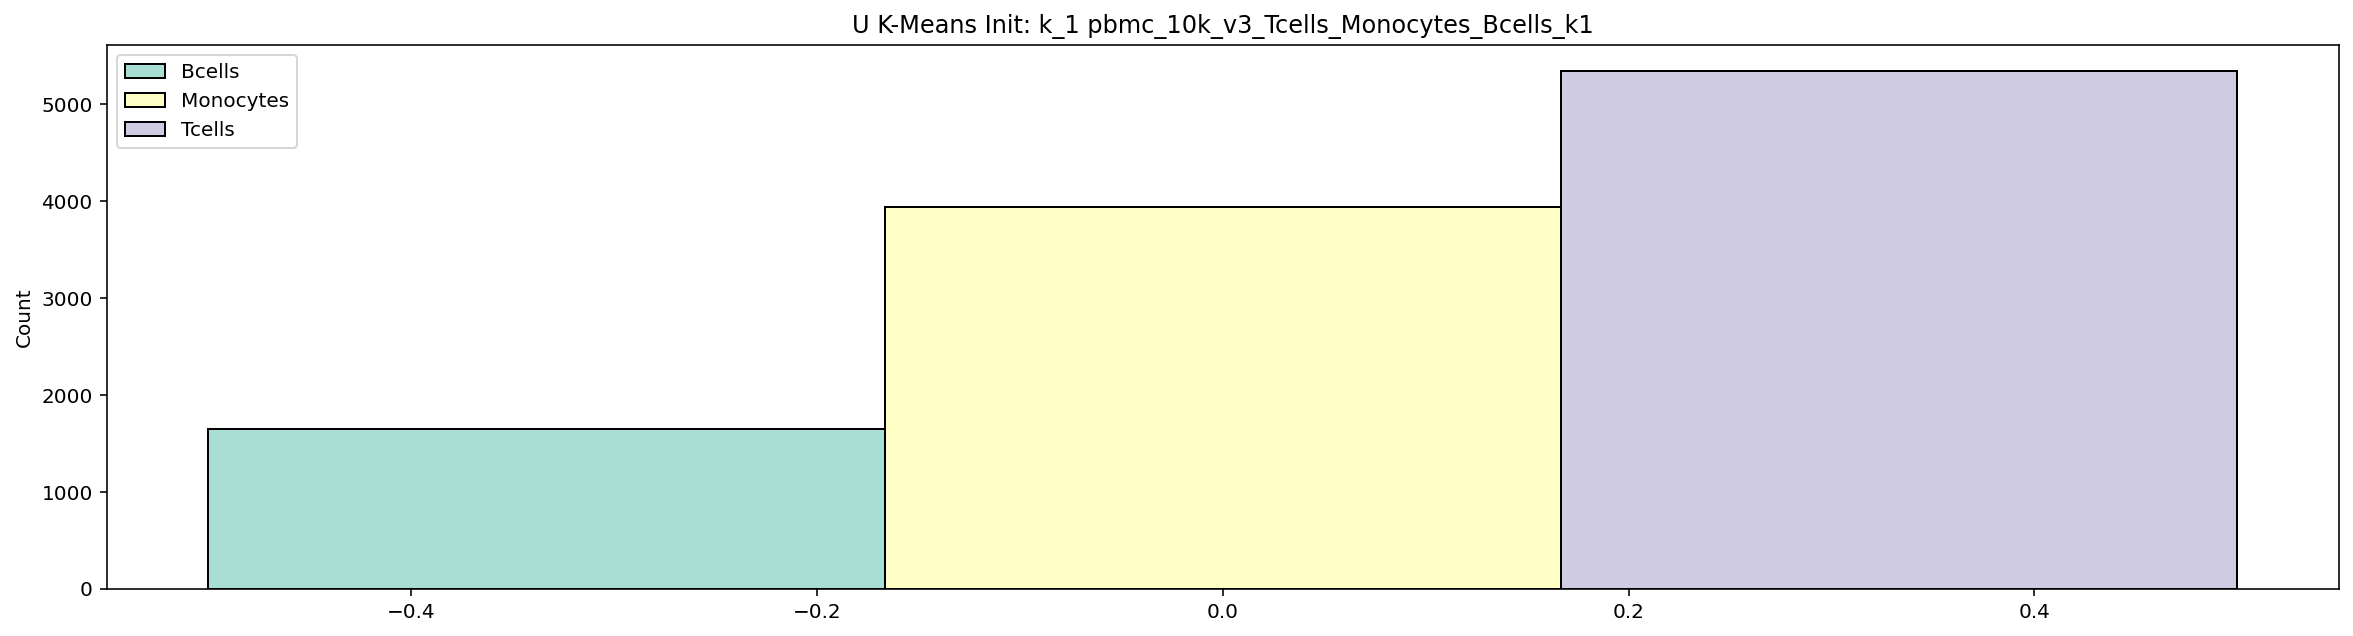

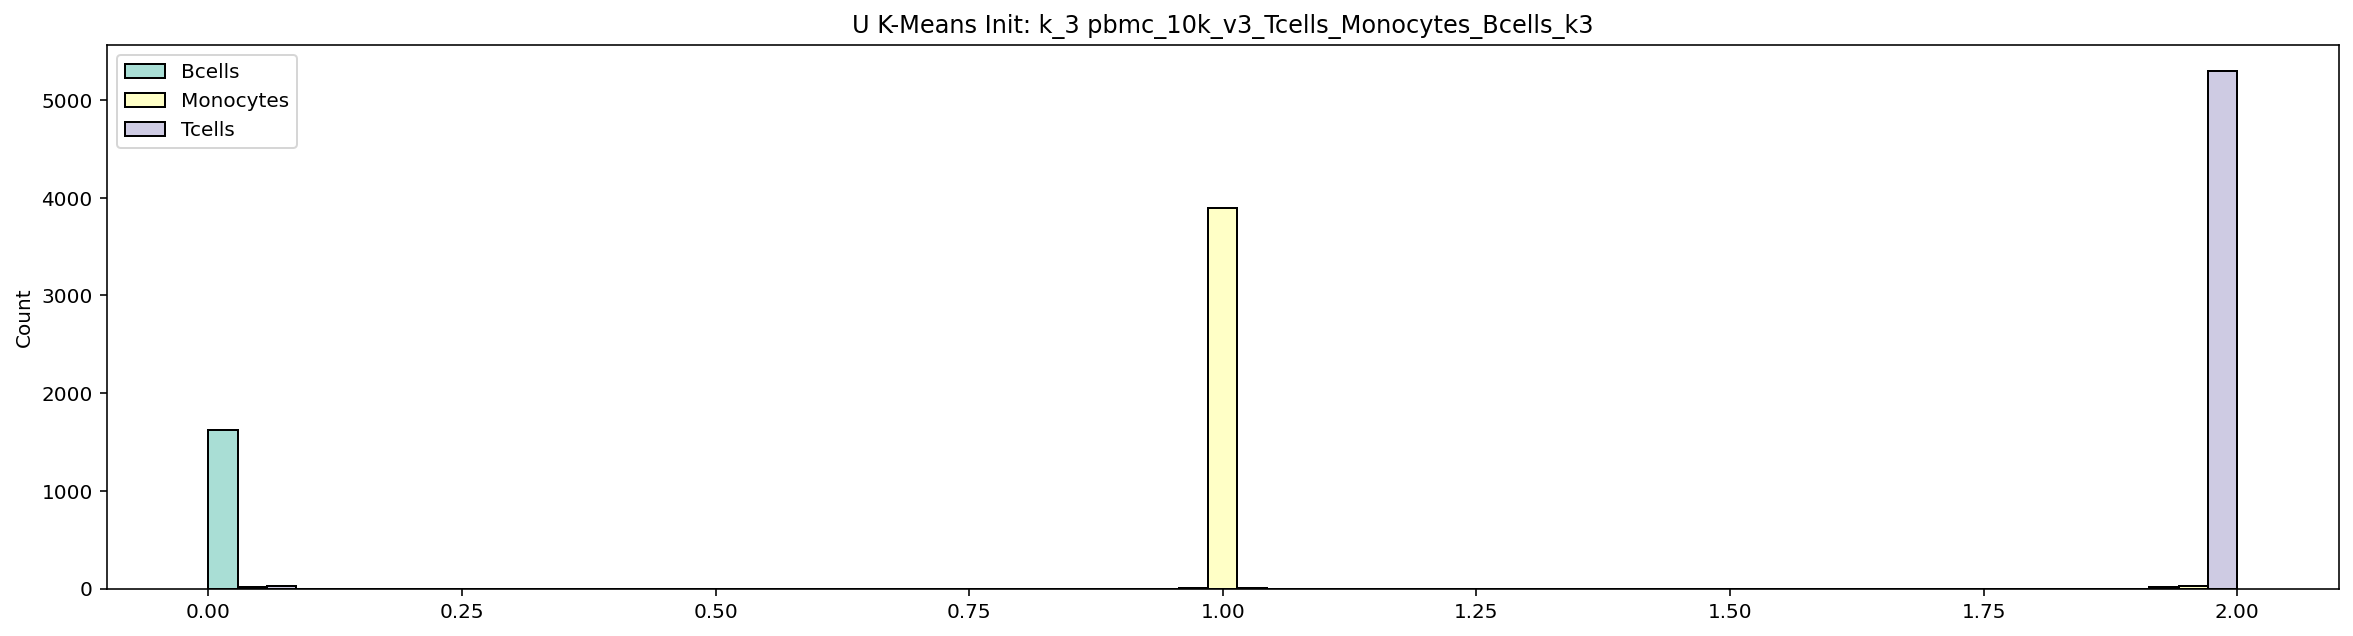

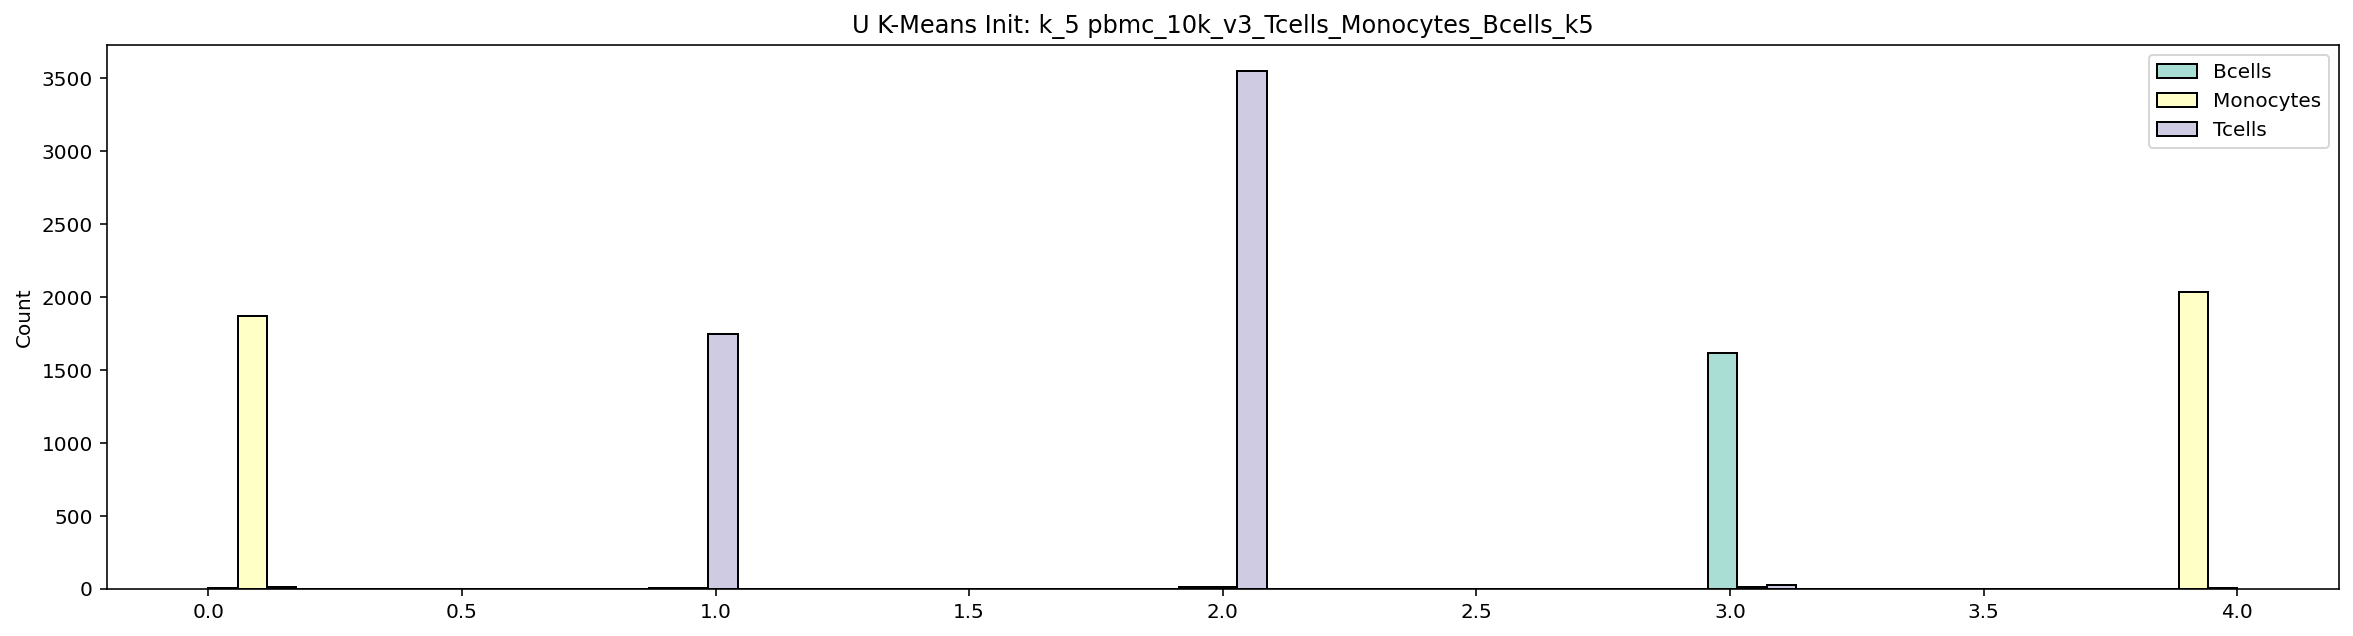

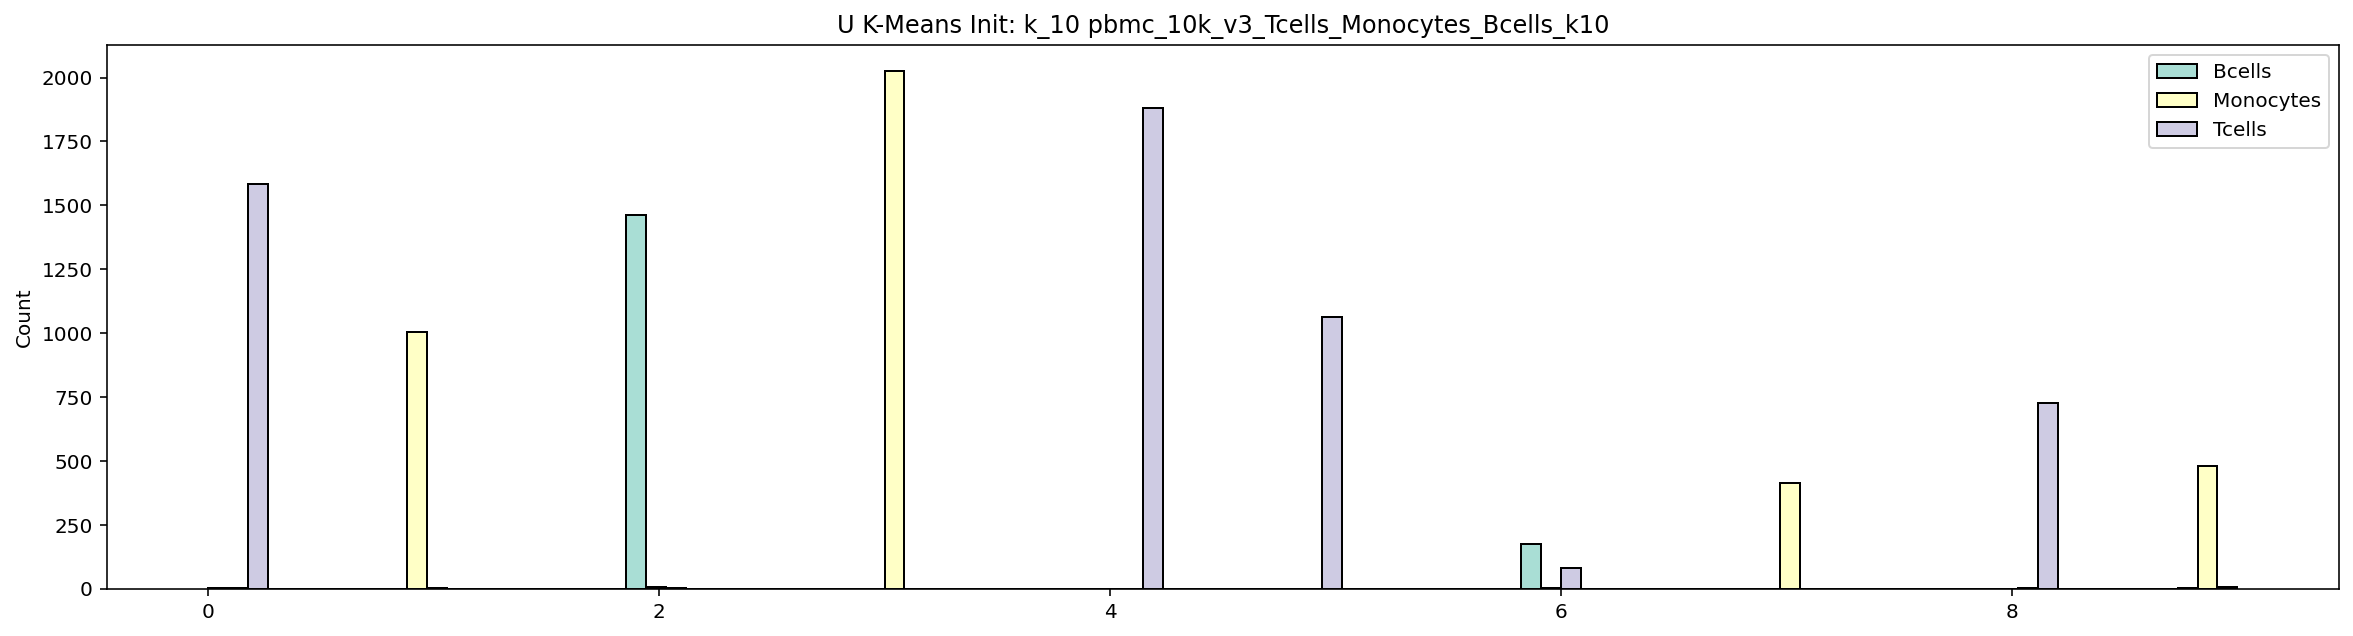

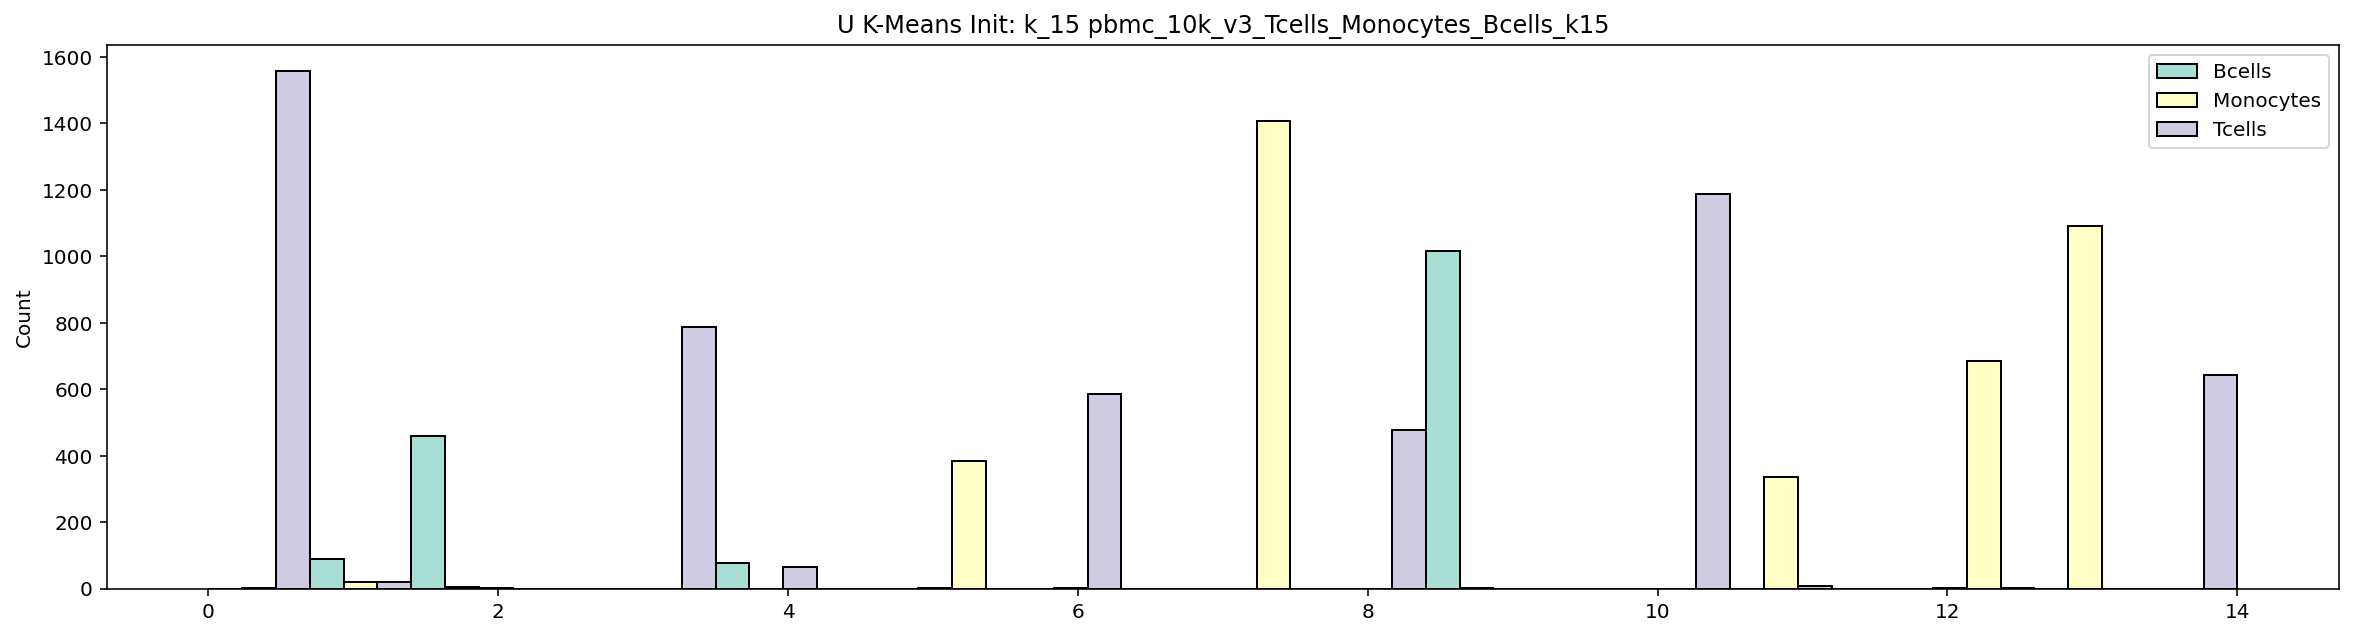

In [120]:
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)+1
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_groups_kmeans += [labs] 
    
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('U K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])


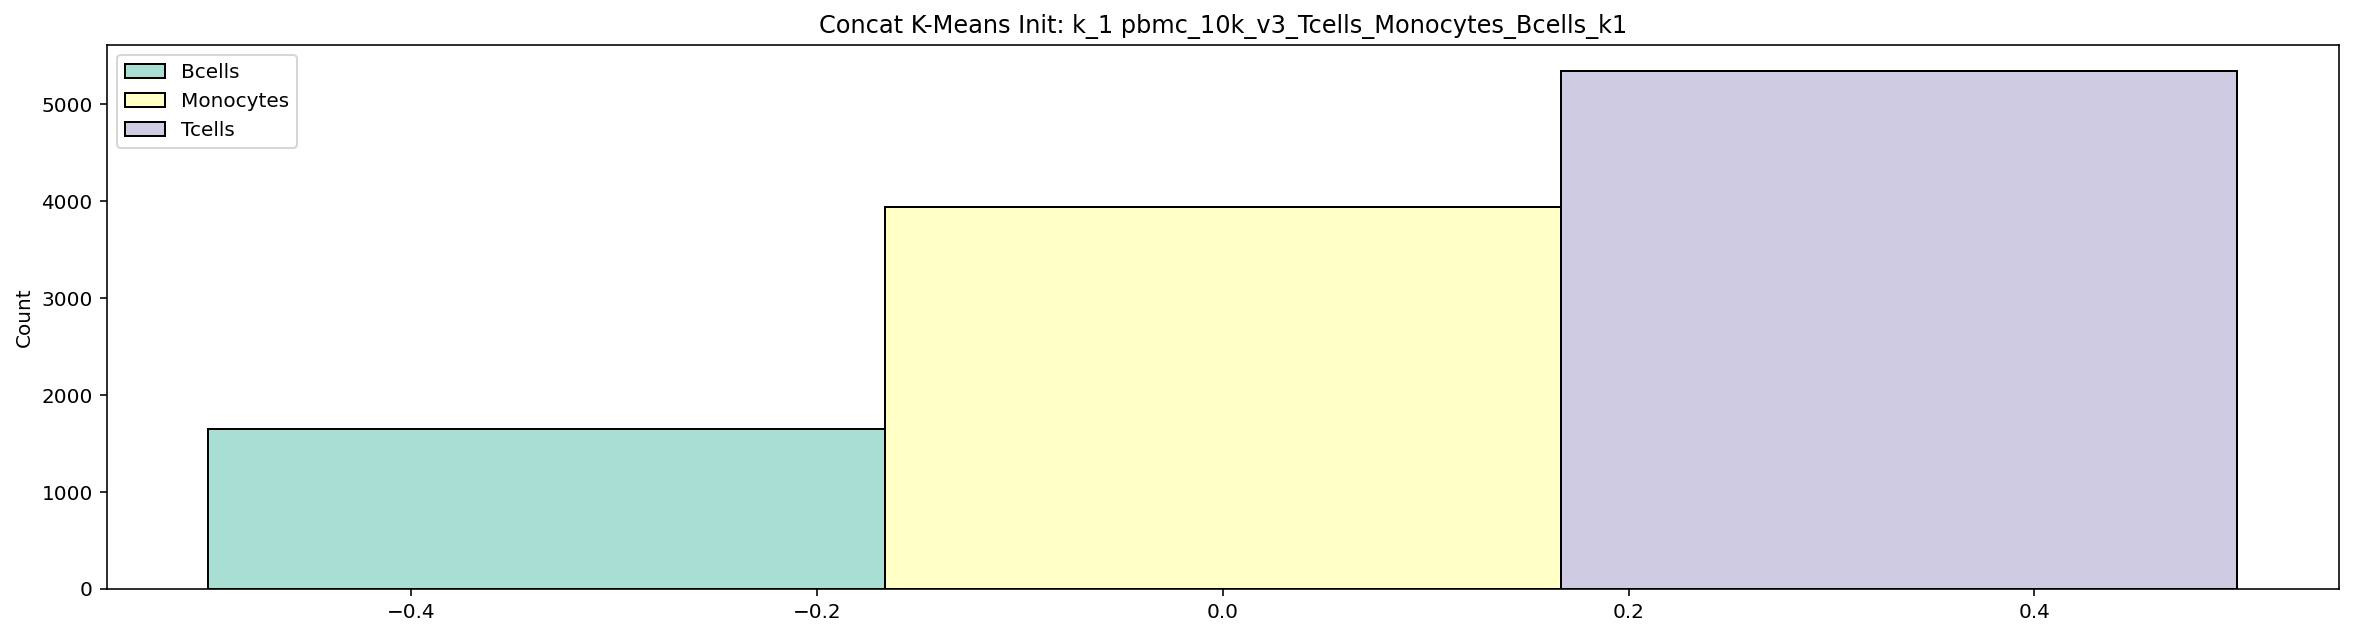

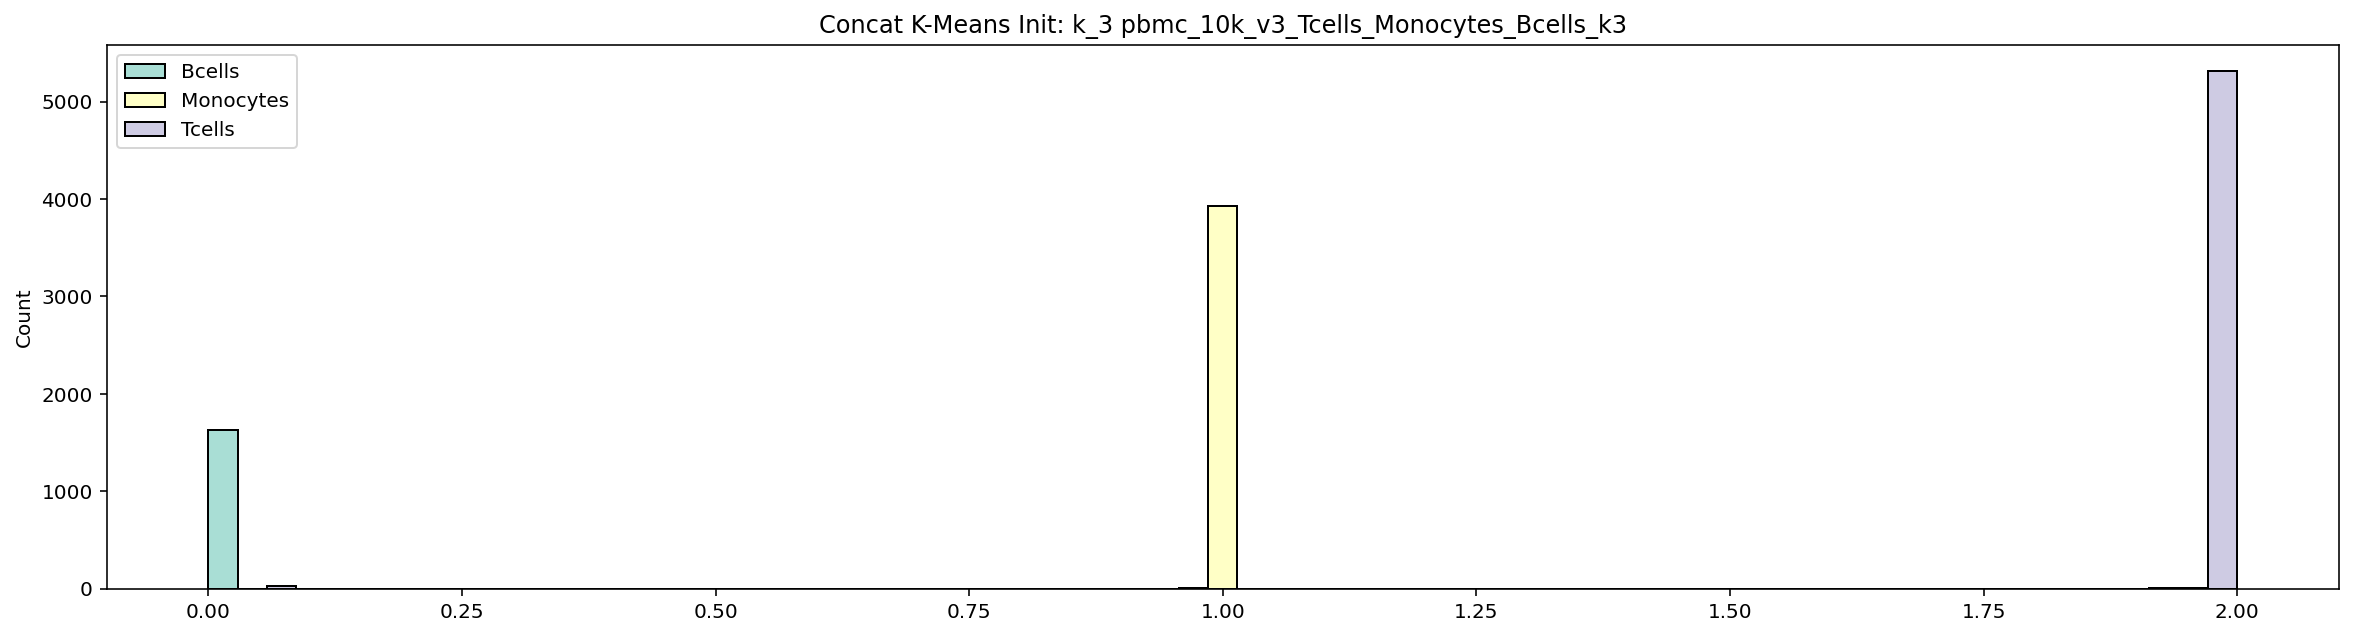

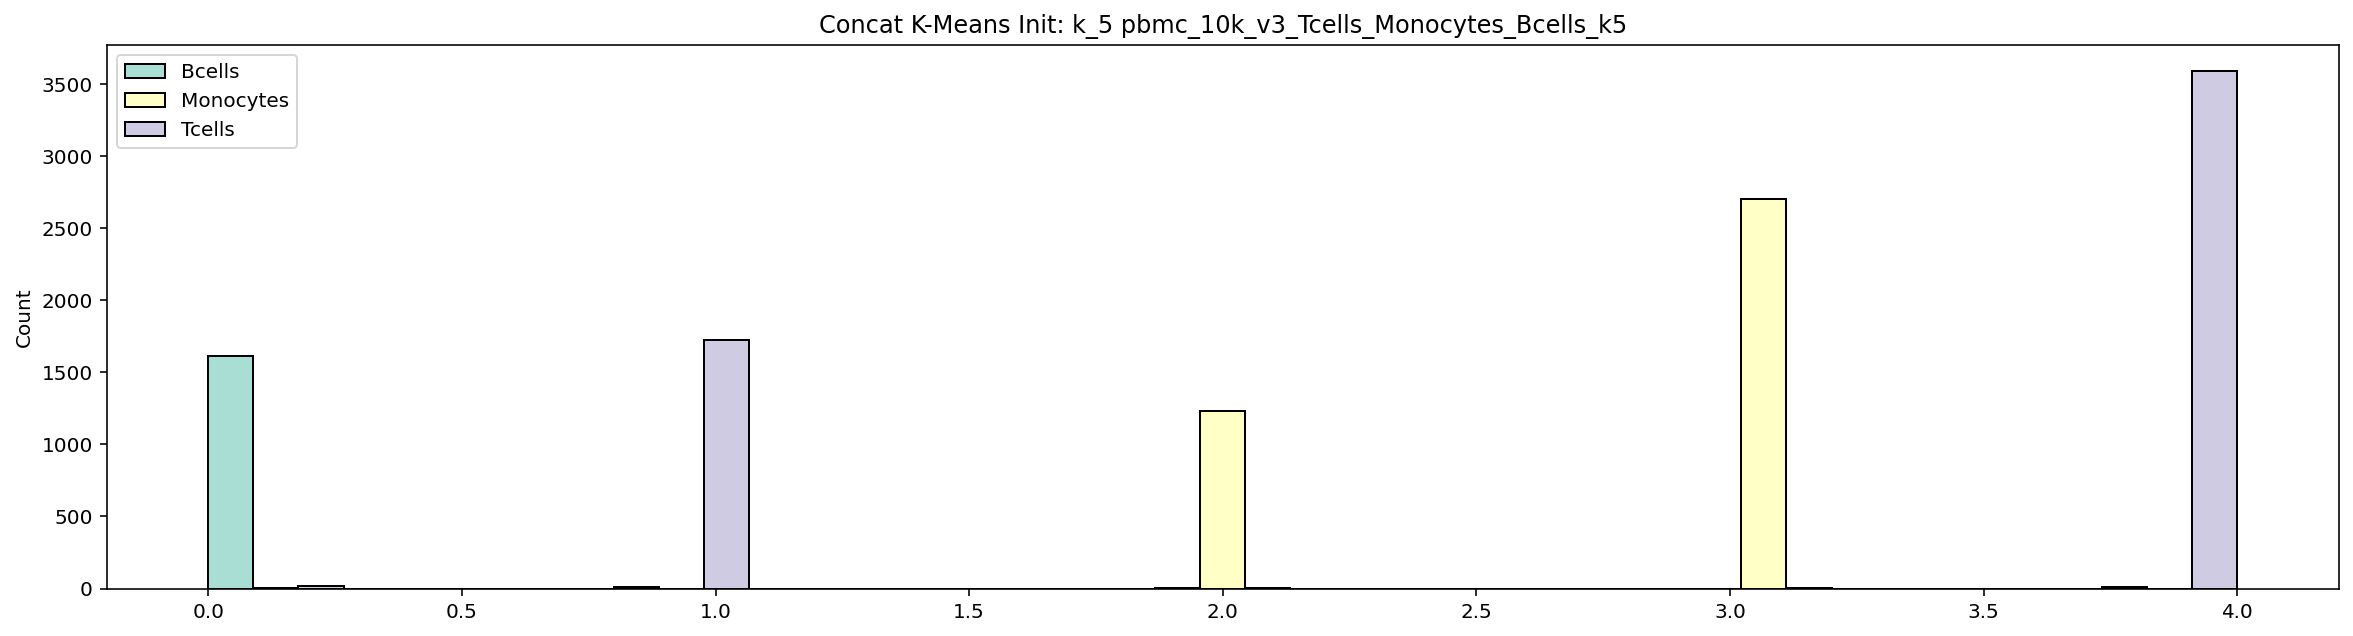

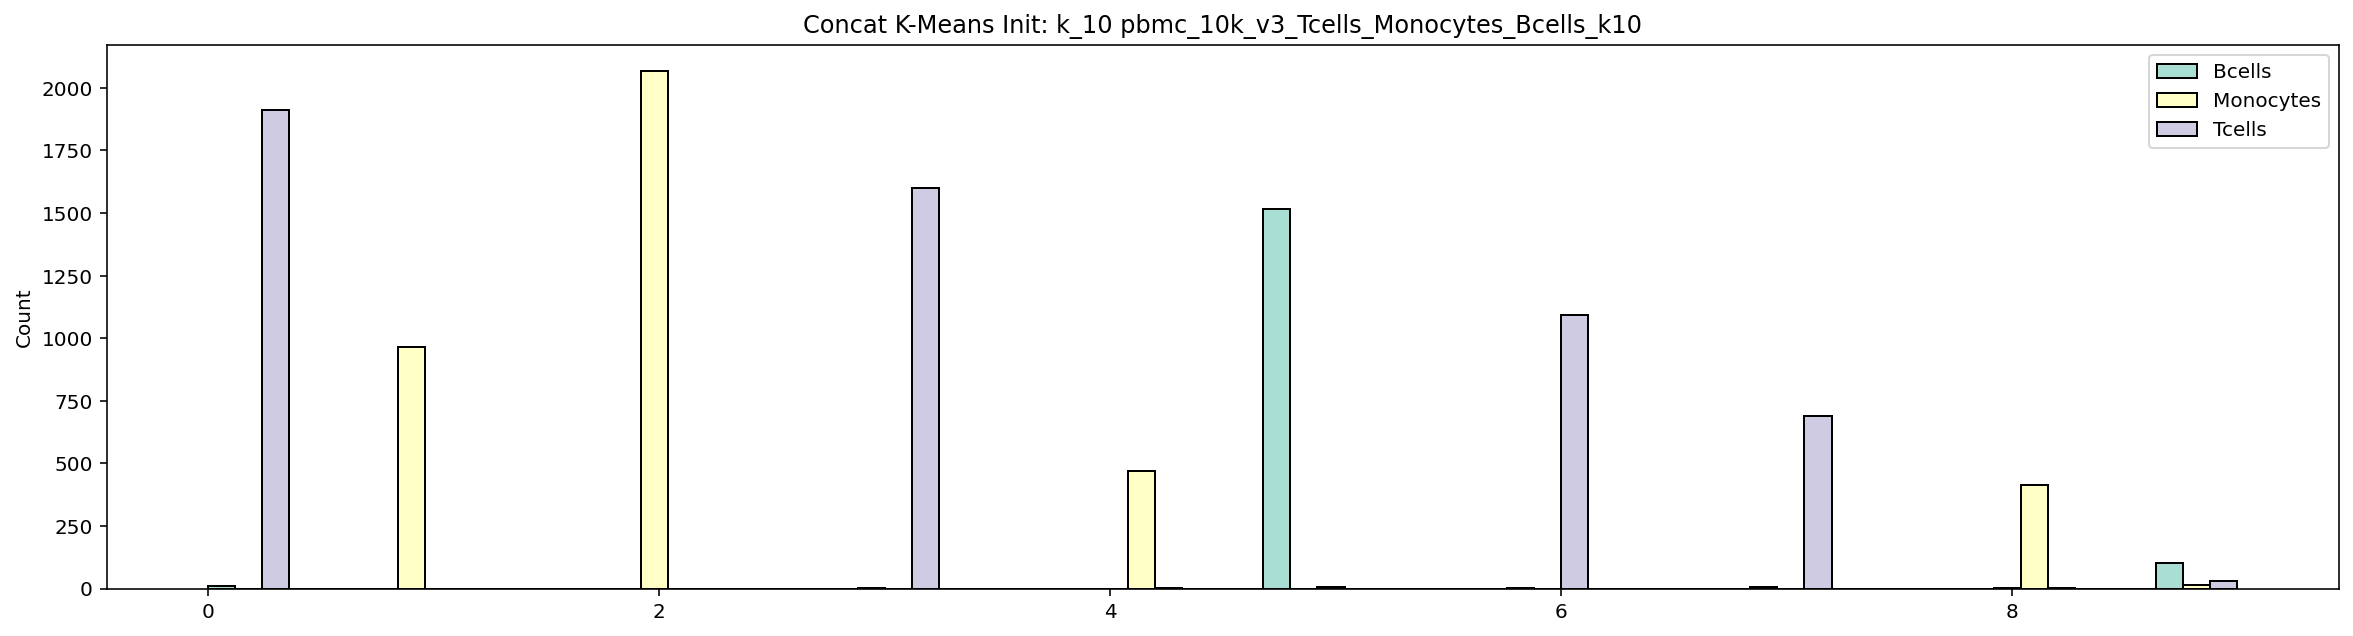

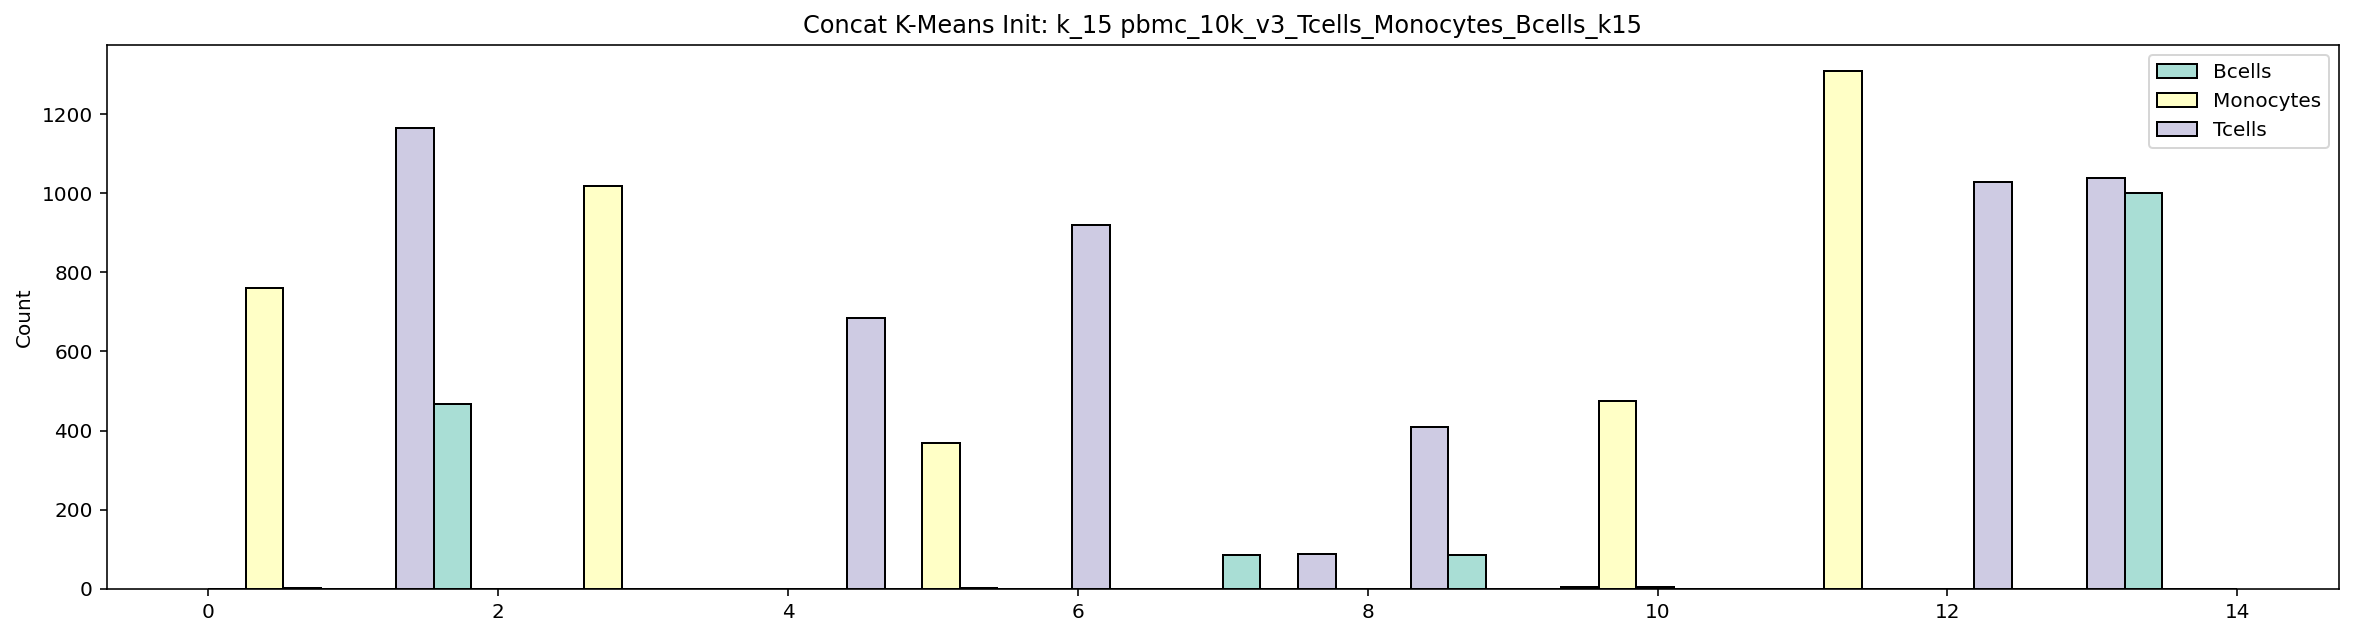

In [121]:
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('Concat K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[i])

    
    

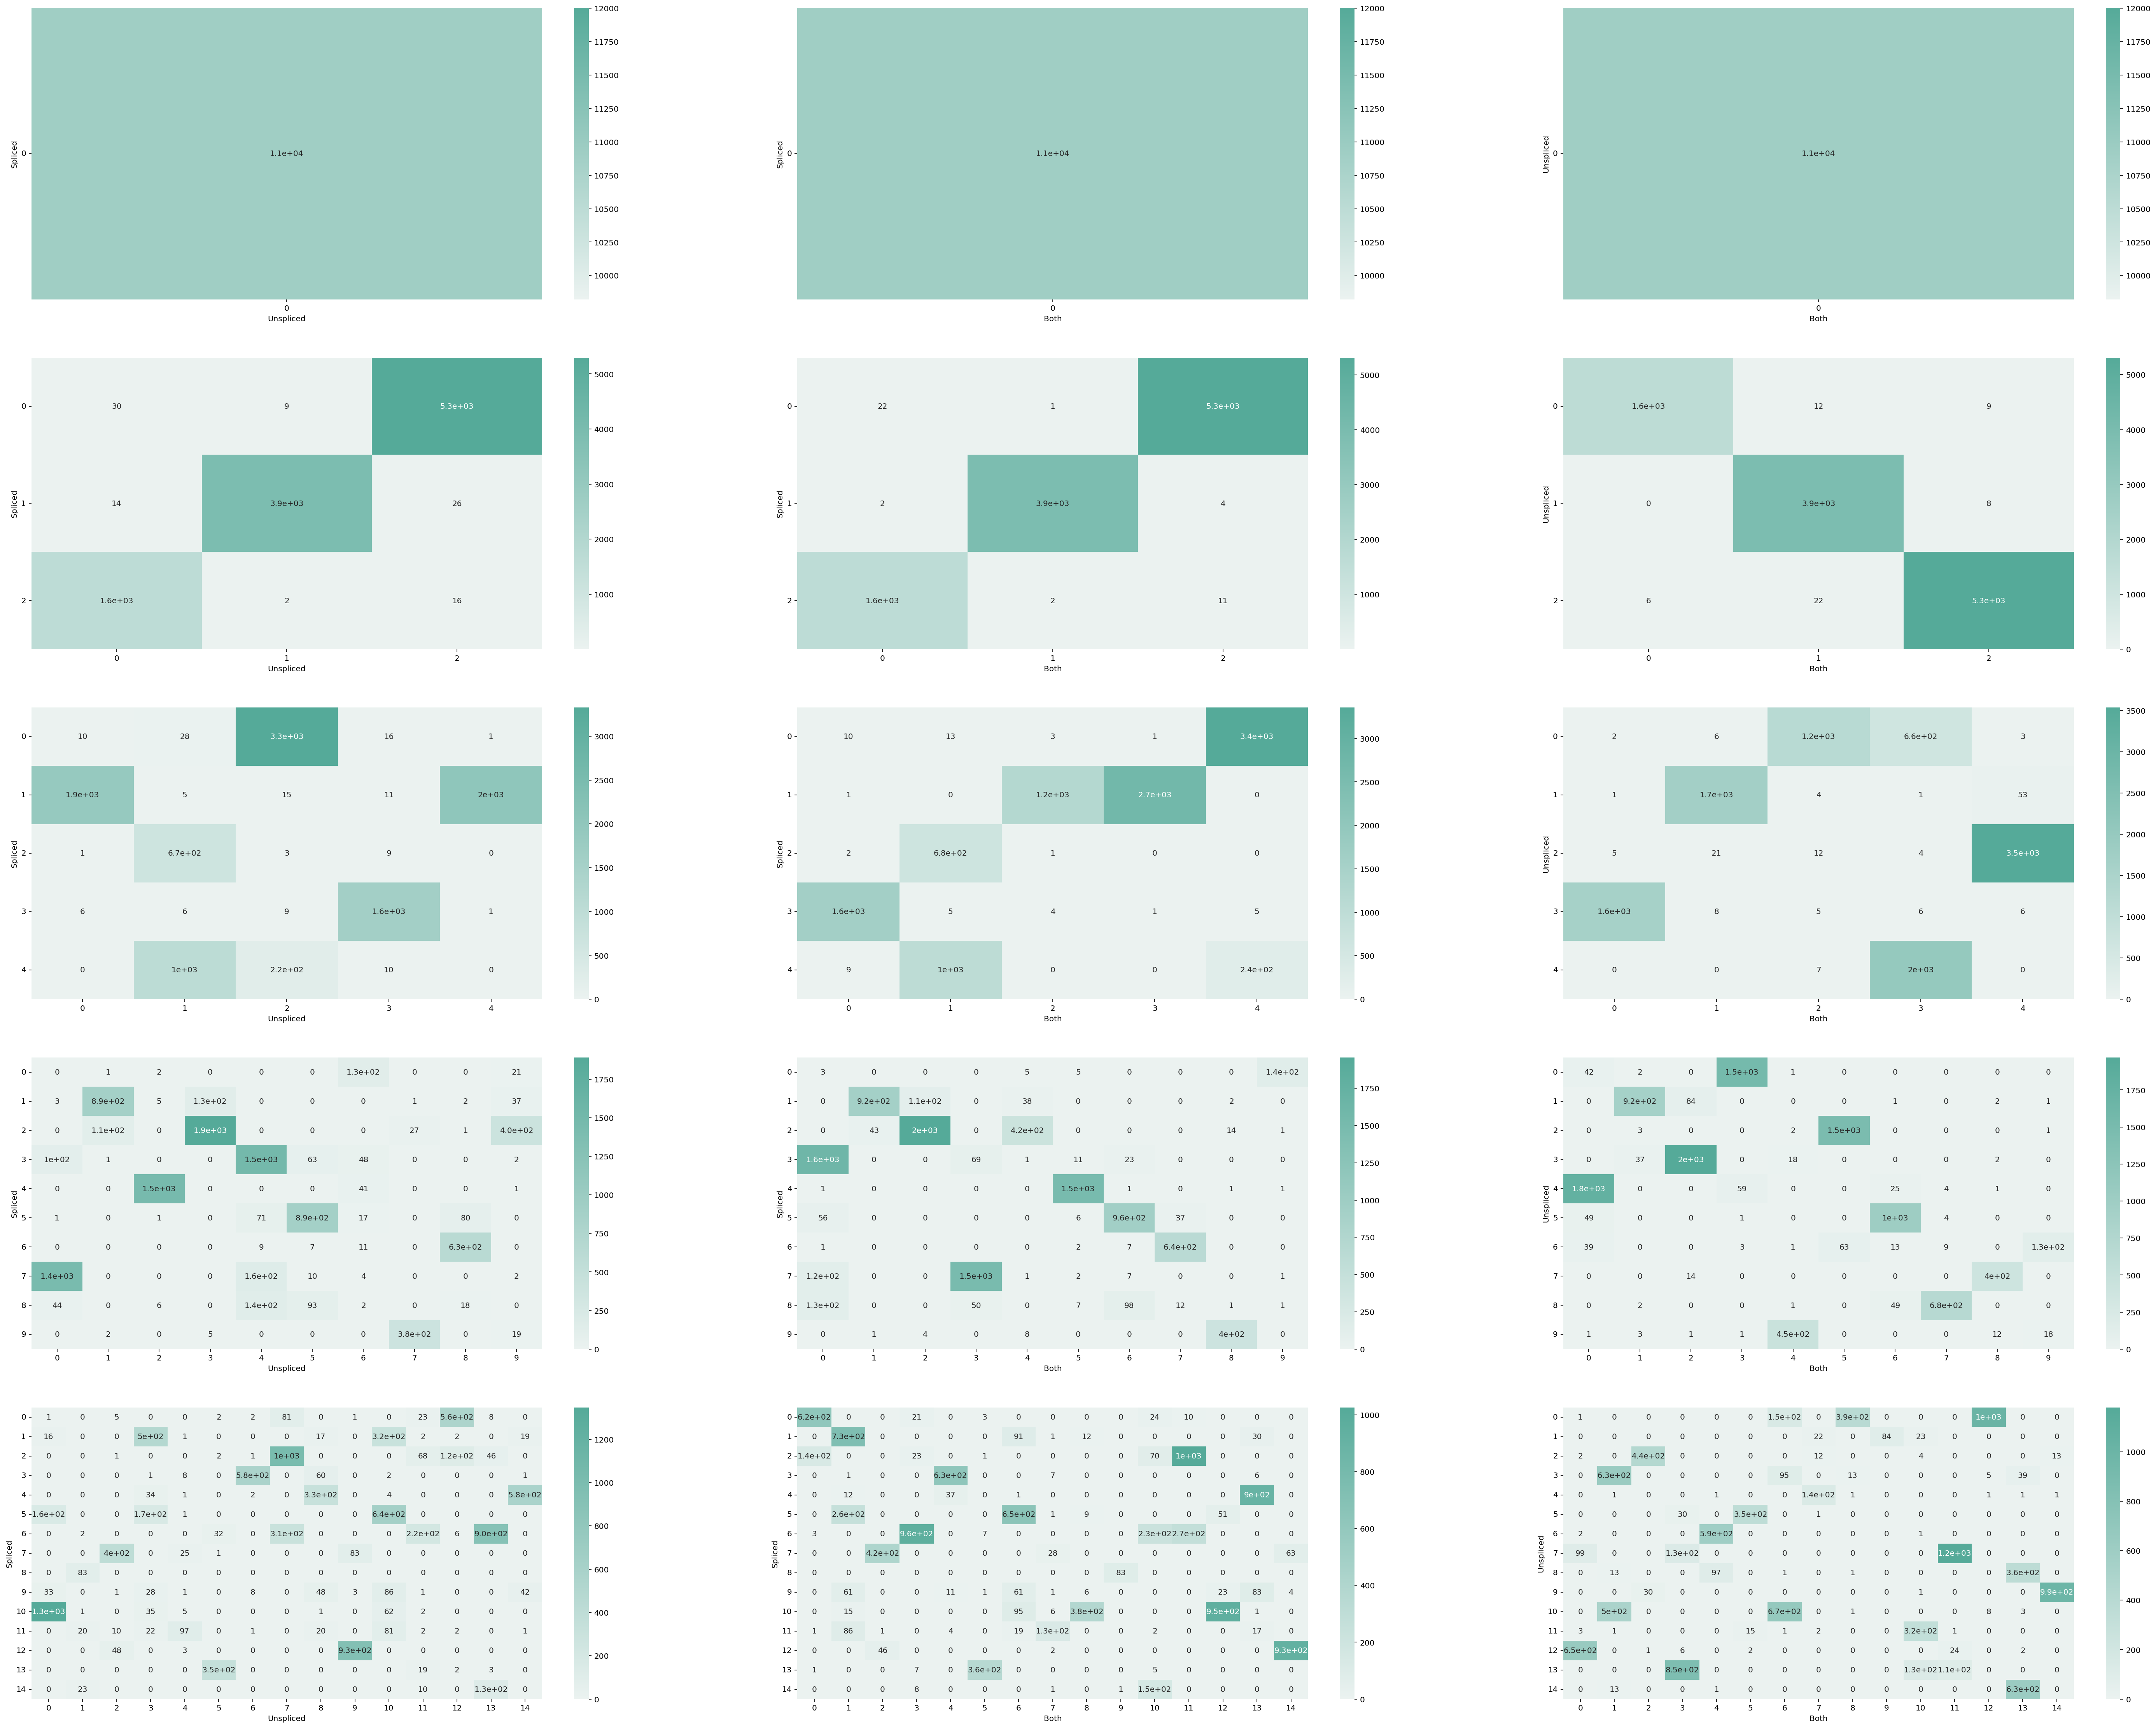

In [132]:
#compare overlap of all k-means assignments

num_per_set = num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,40))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

Leiden Clusters

In [125]:
neigh = 30
all_groups = []
res = [0.25,0.5,1,1.5,2.0]

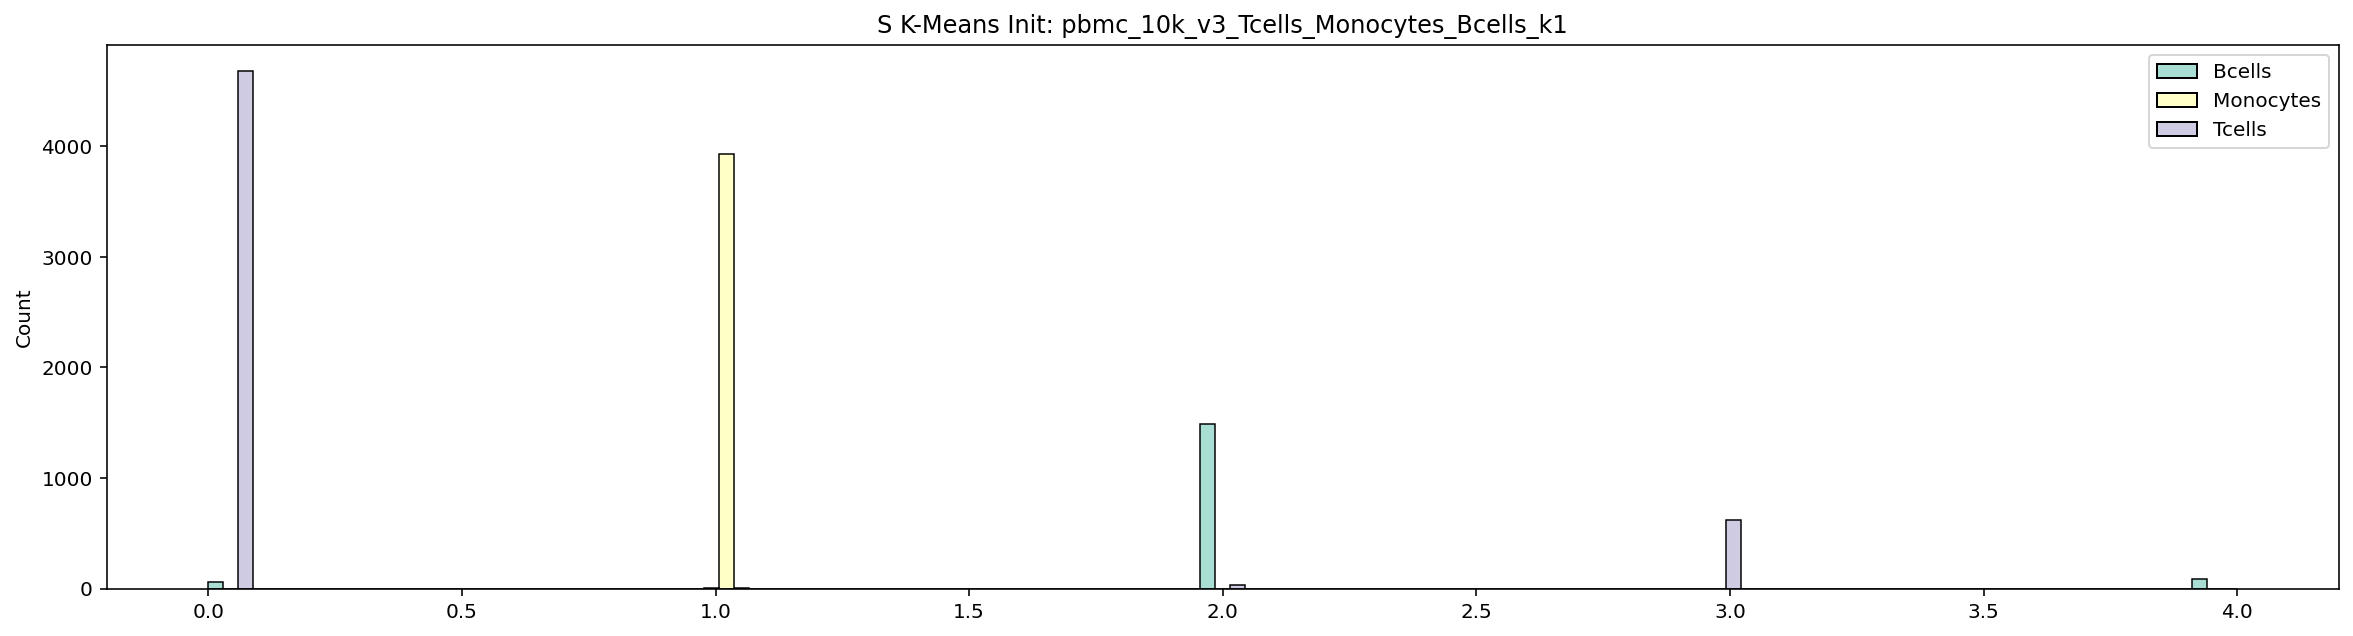

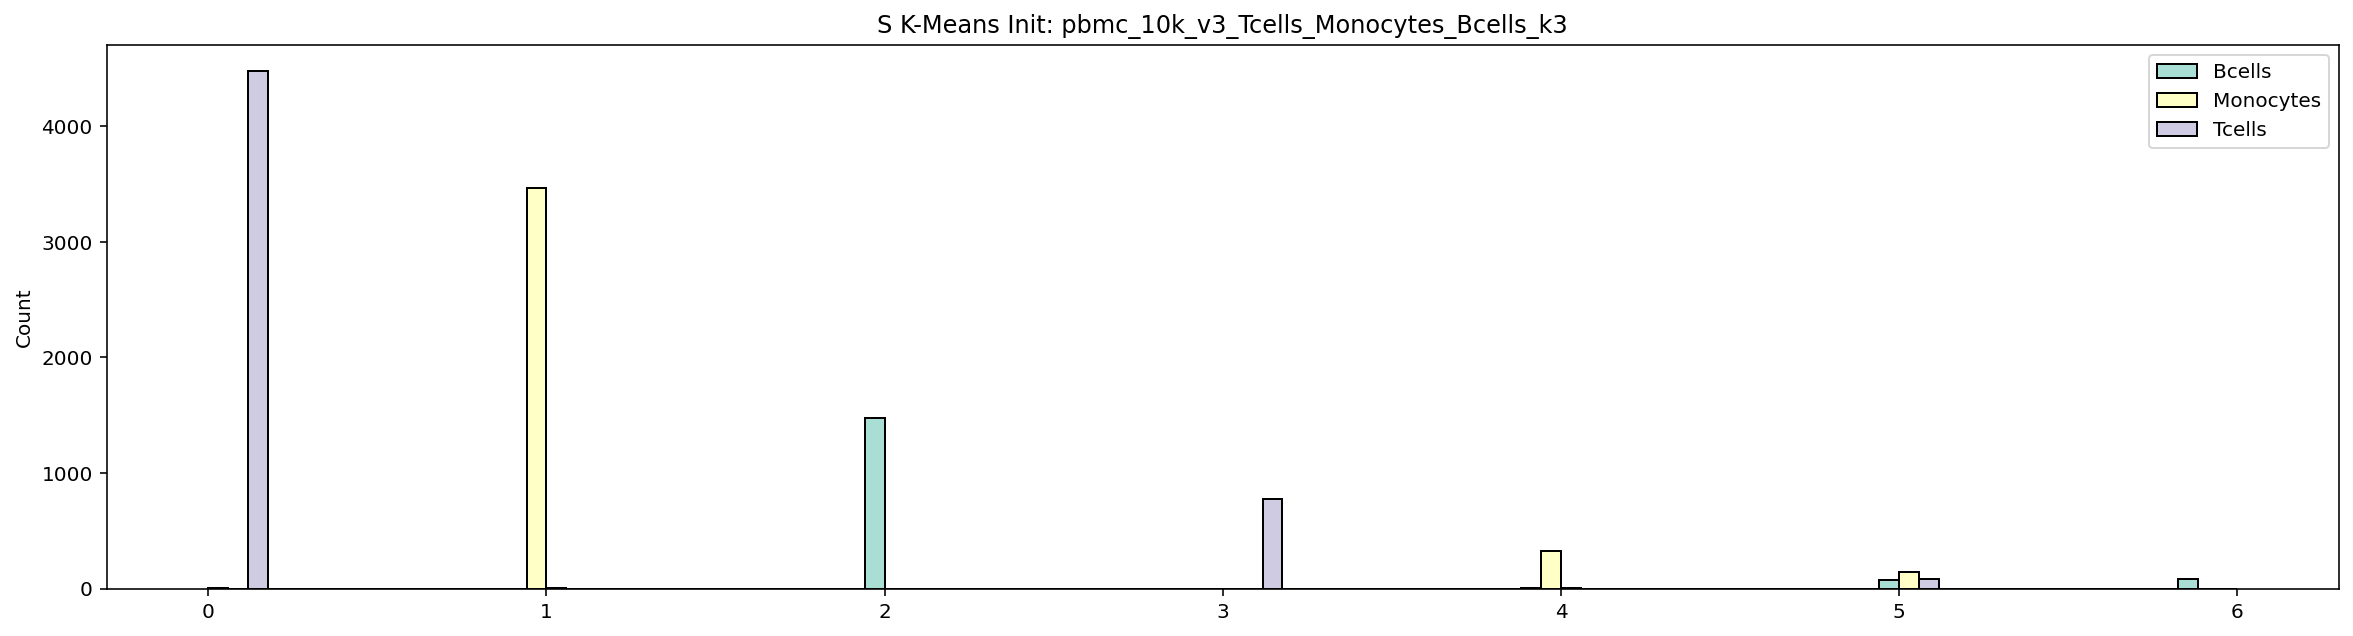

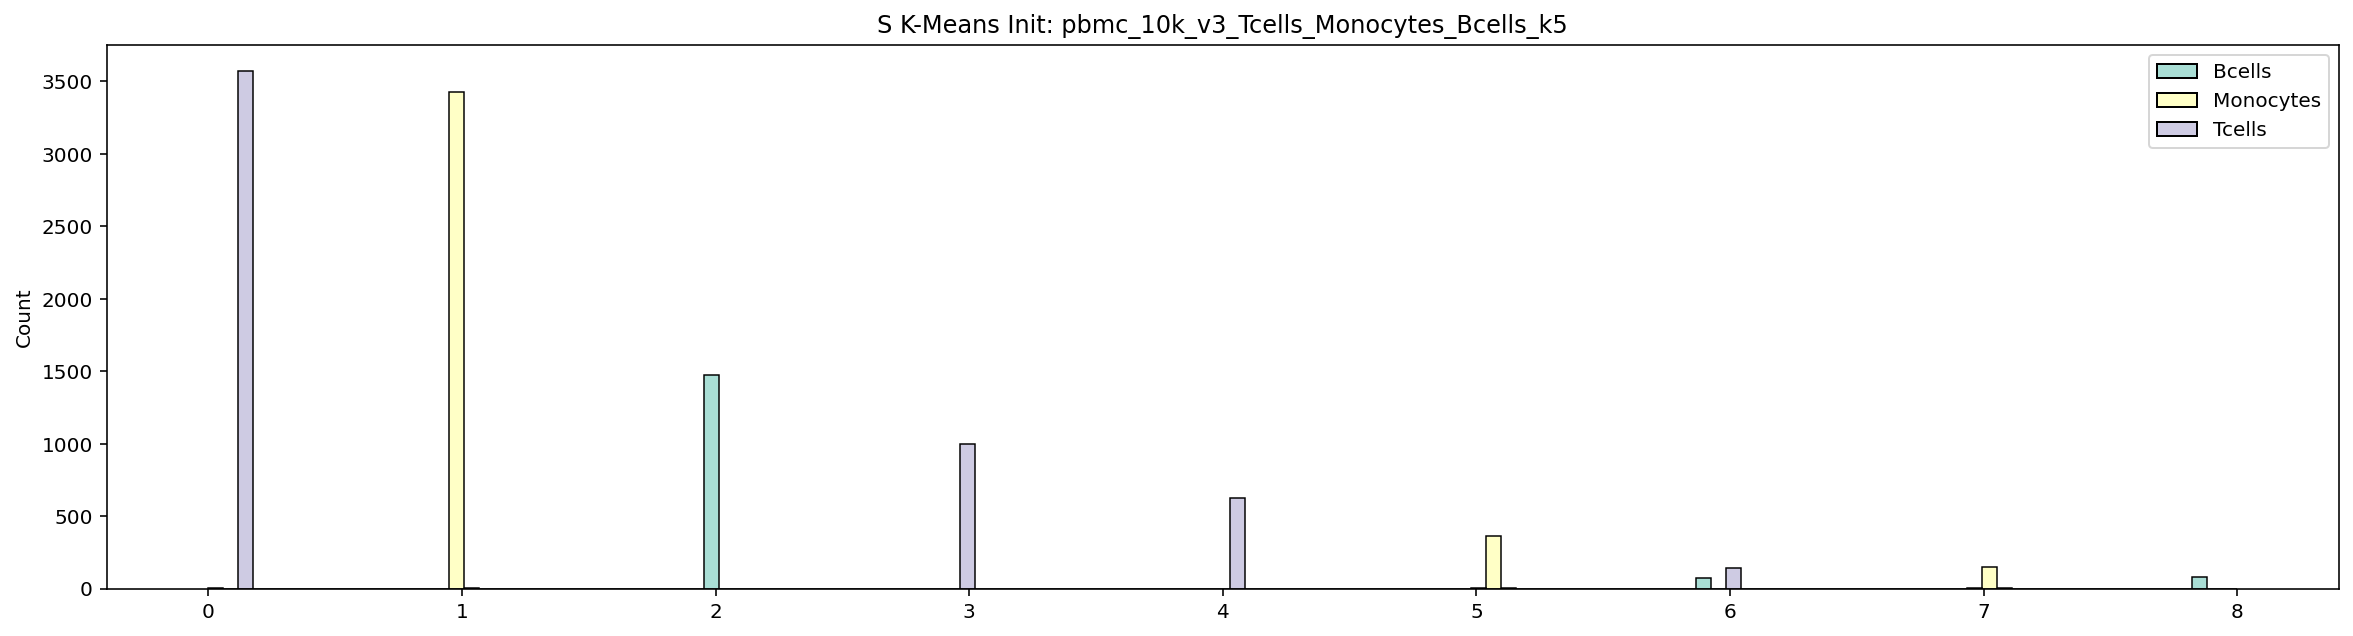

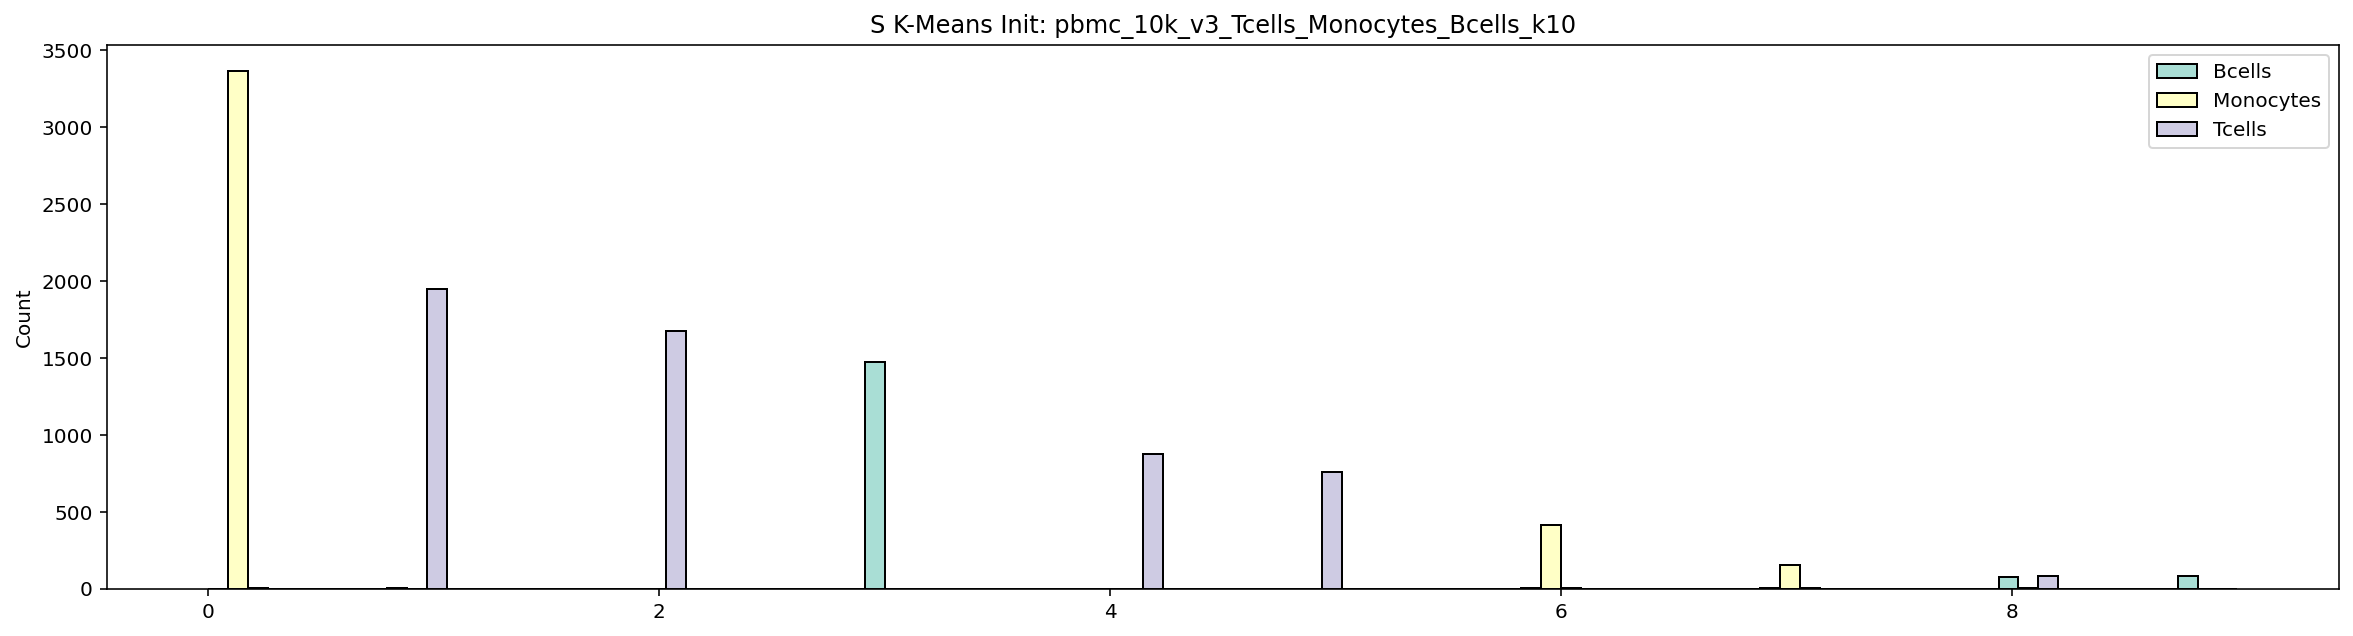

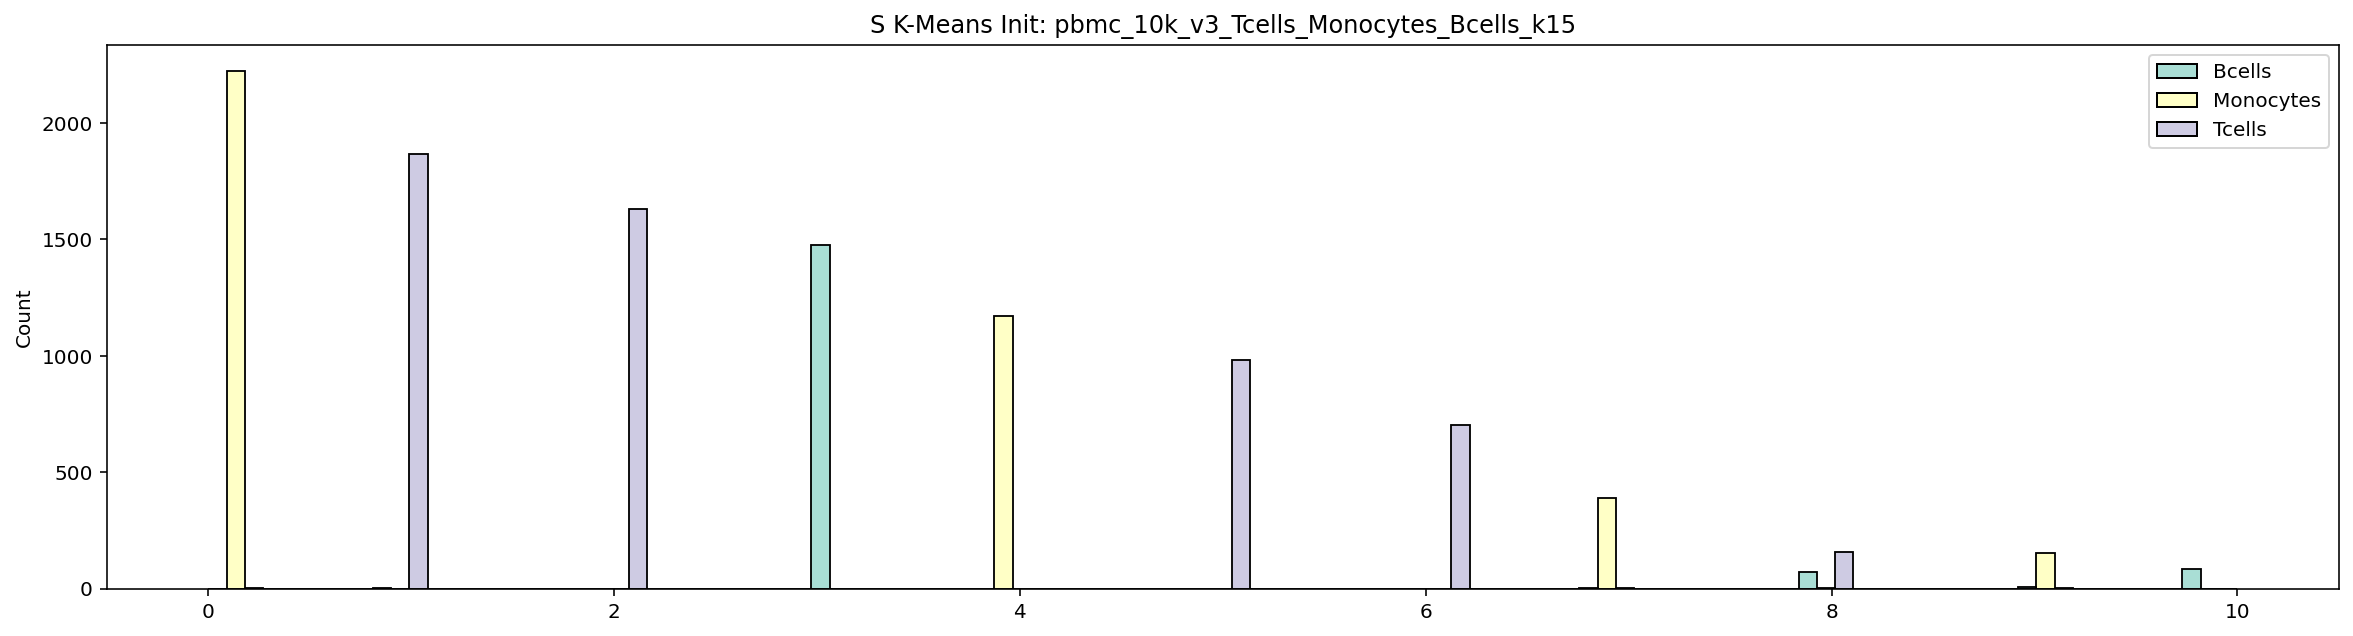

In [126]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('S Leiden: '+dataset_names[i])
    
    
    


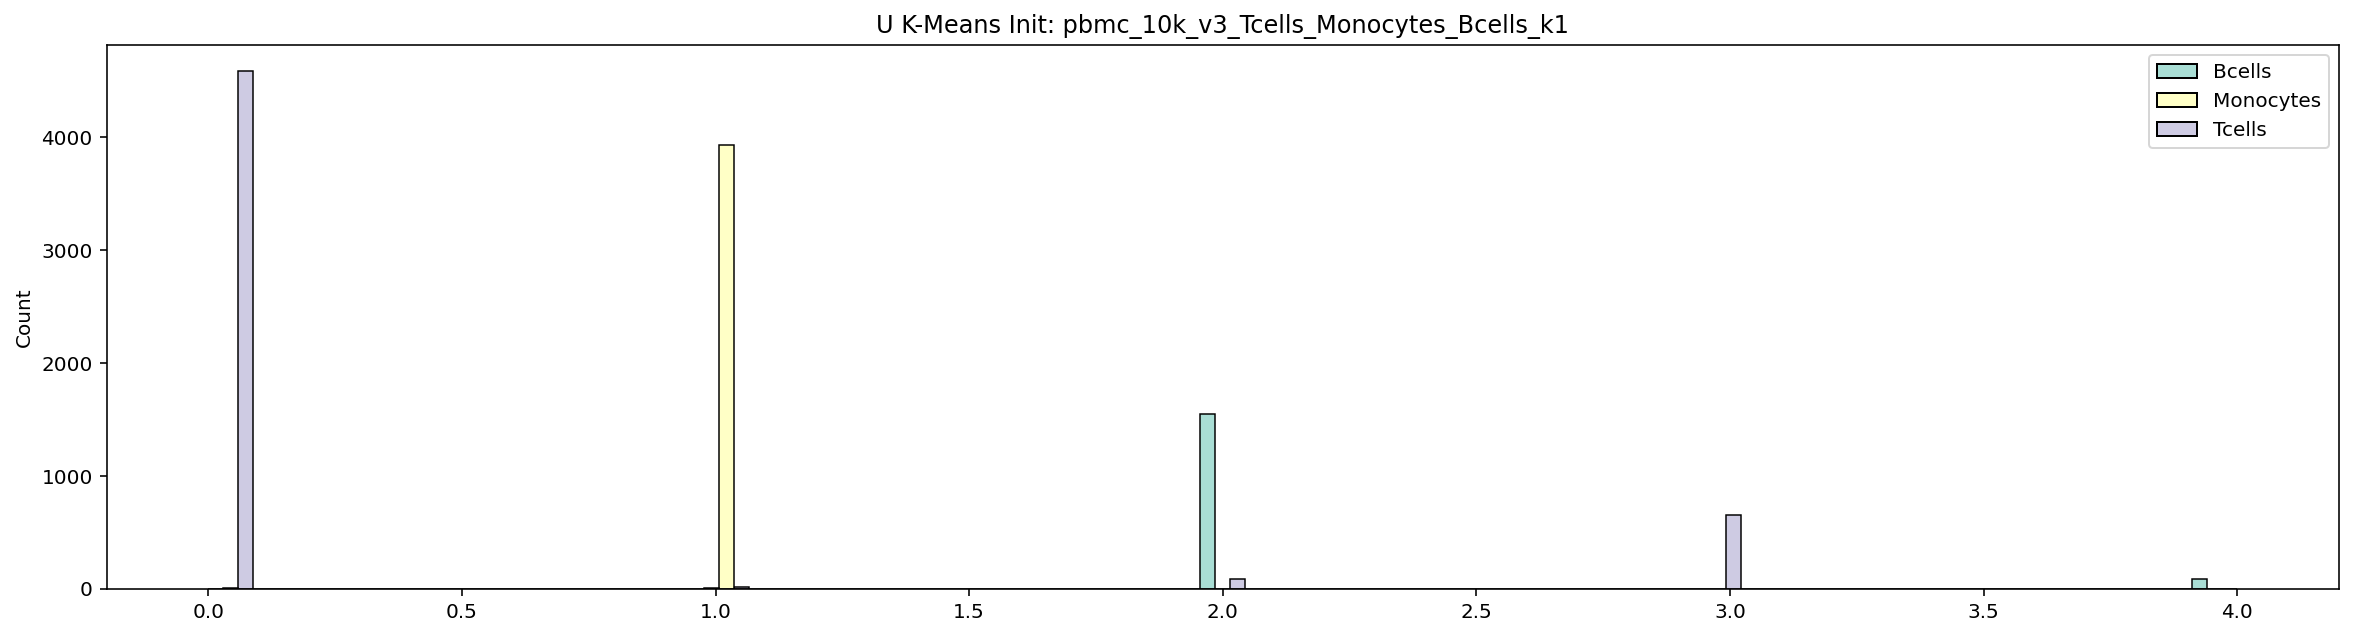

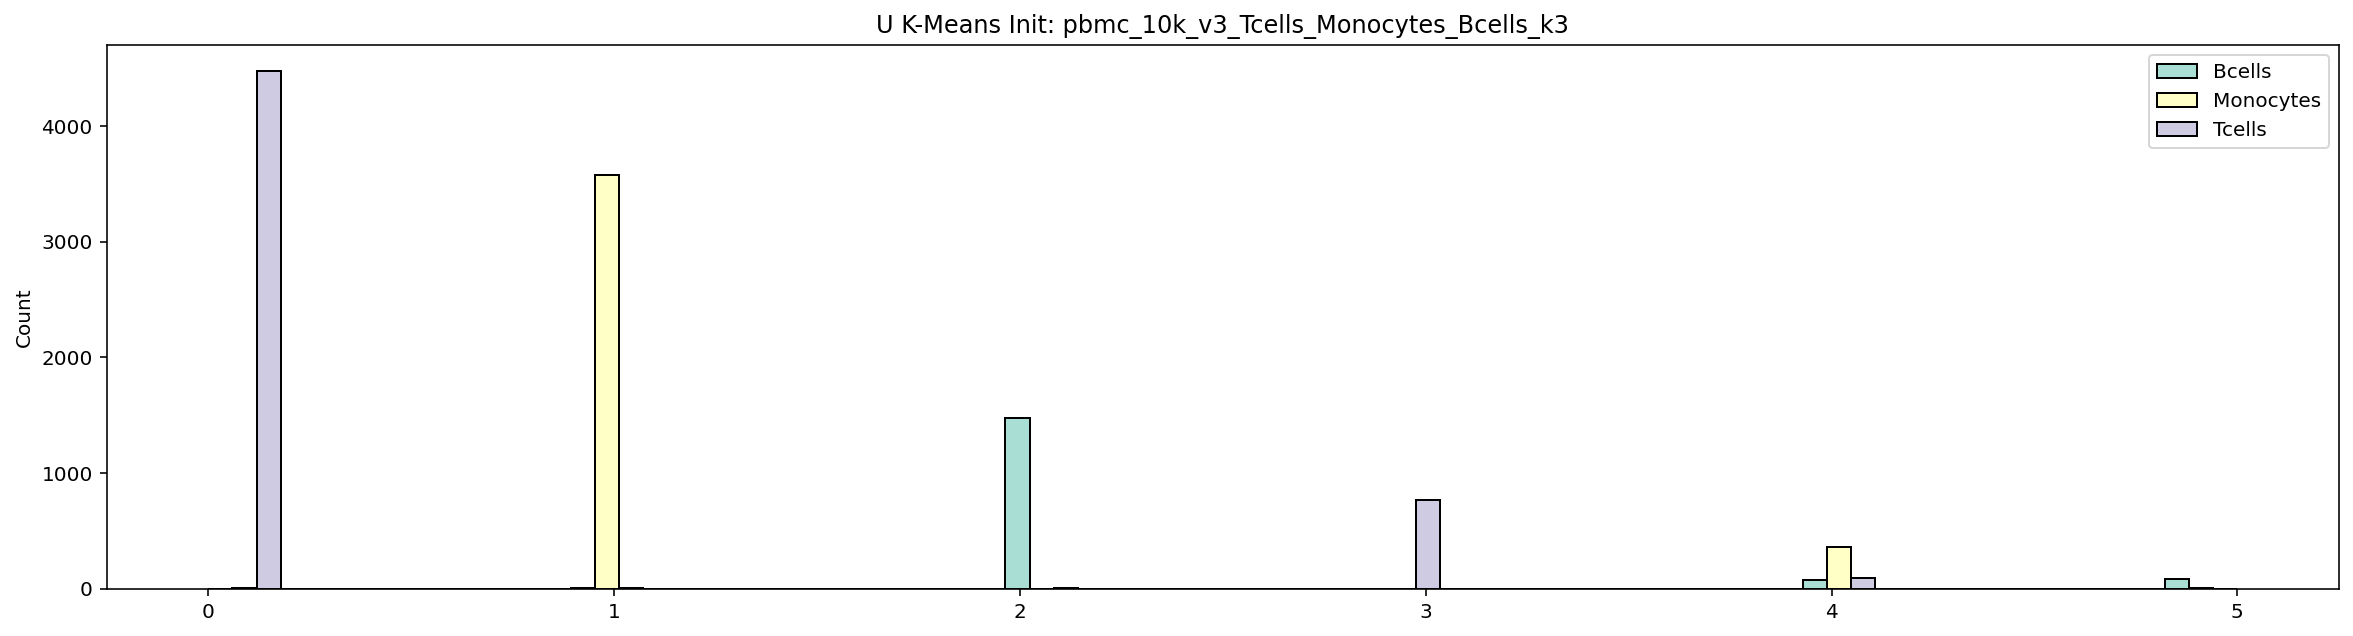

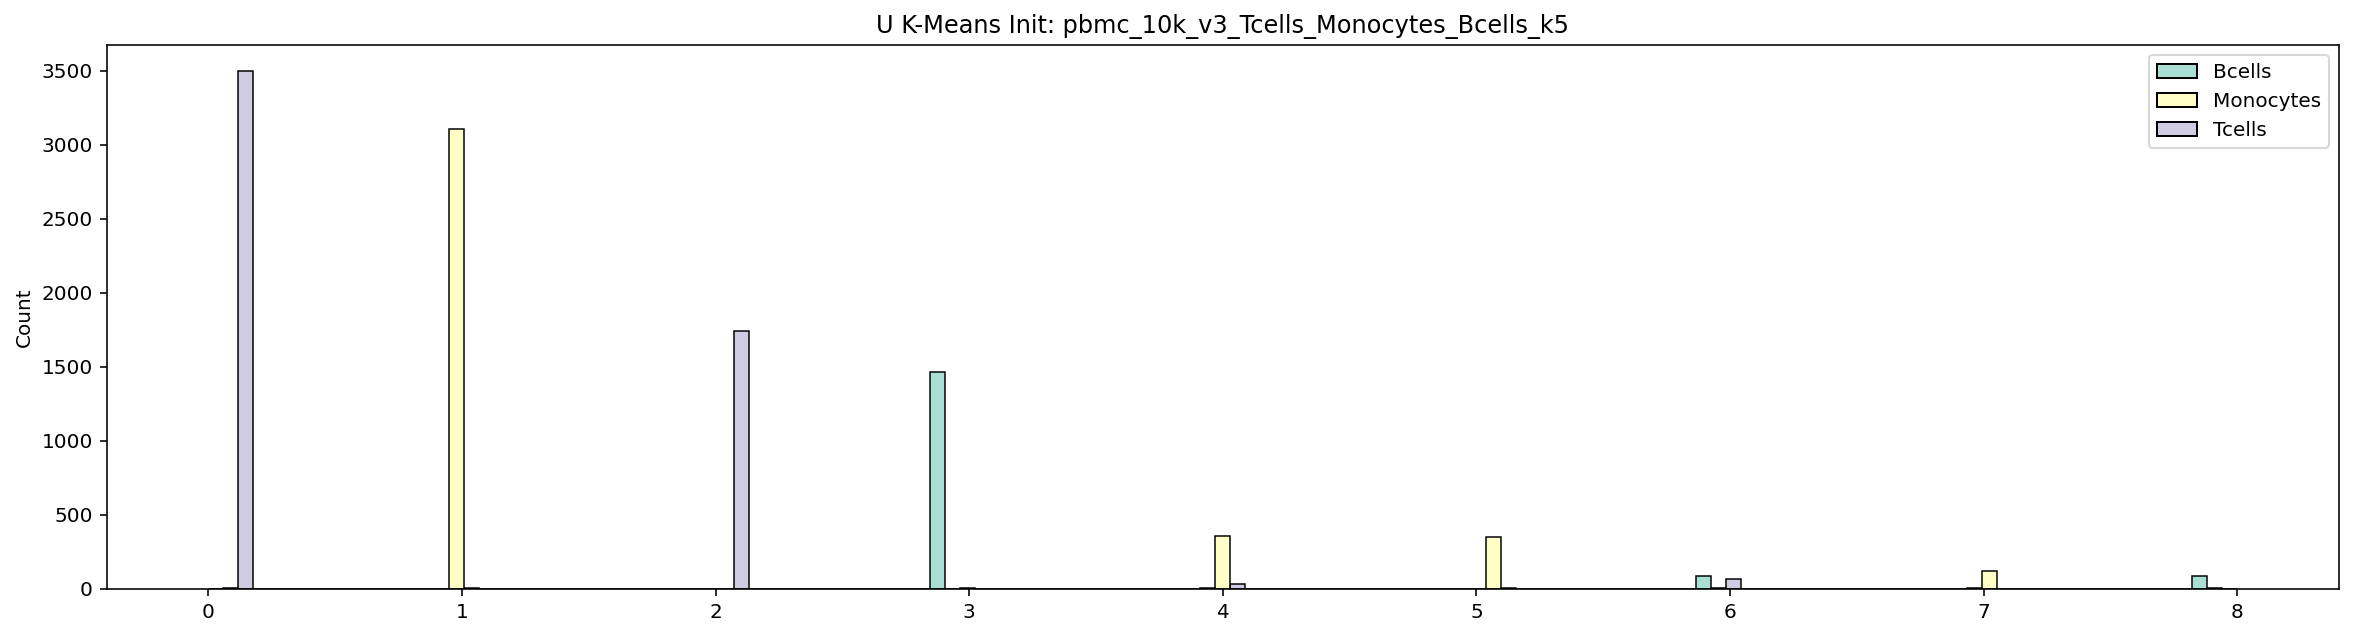

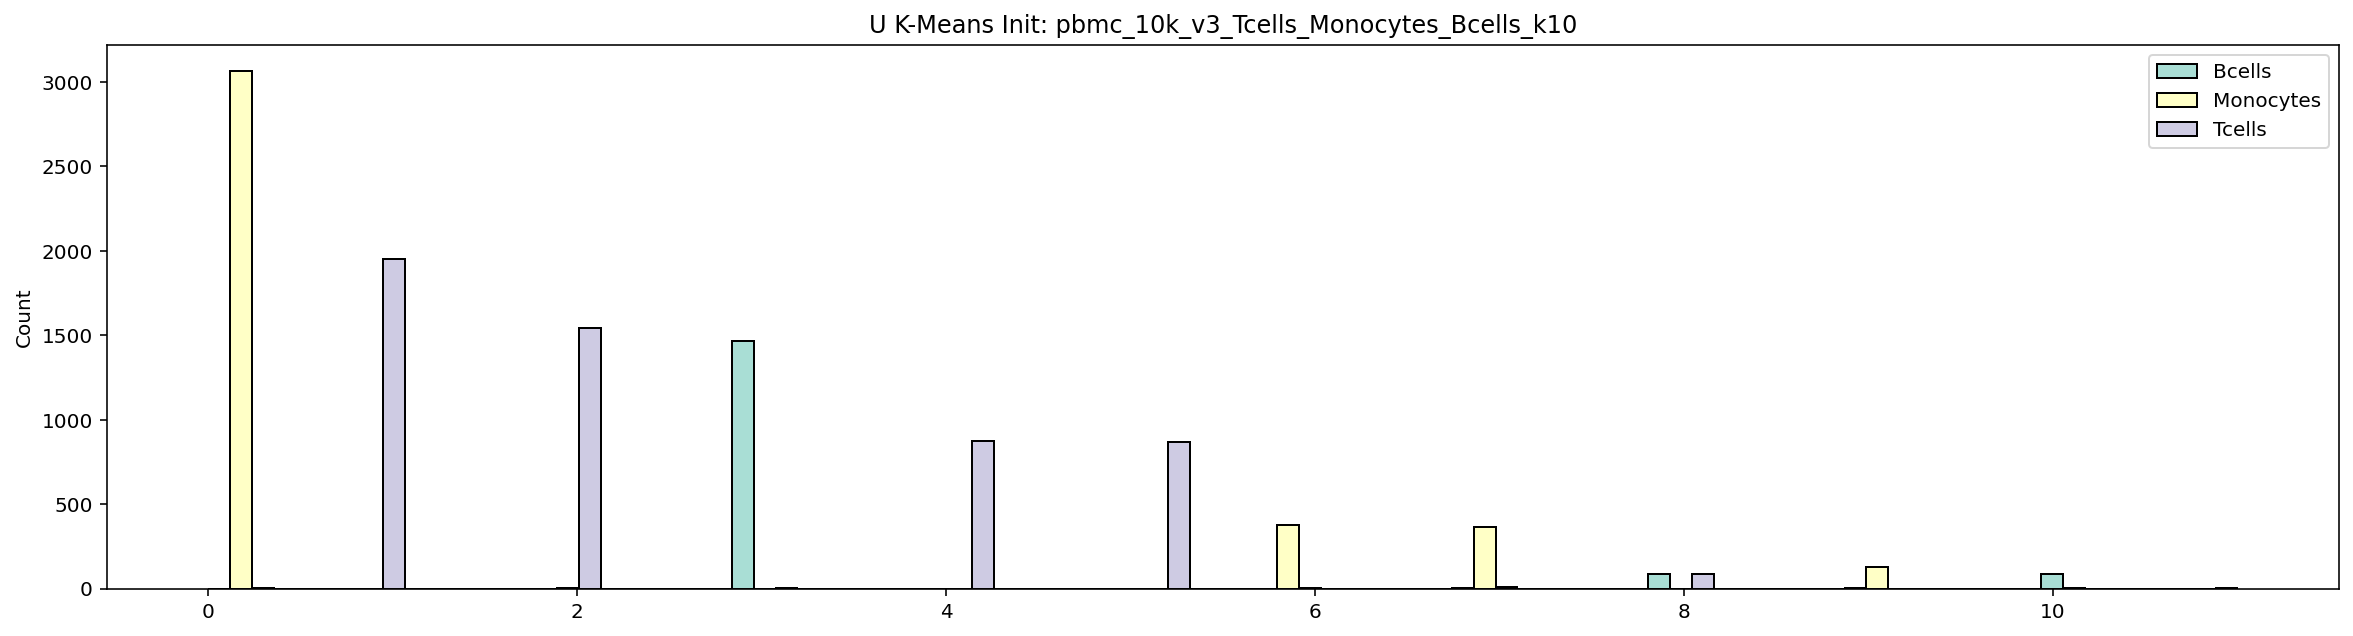

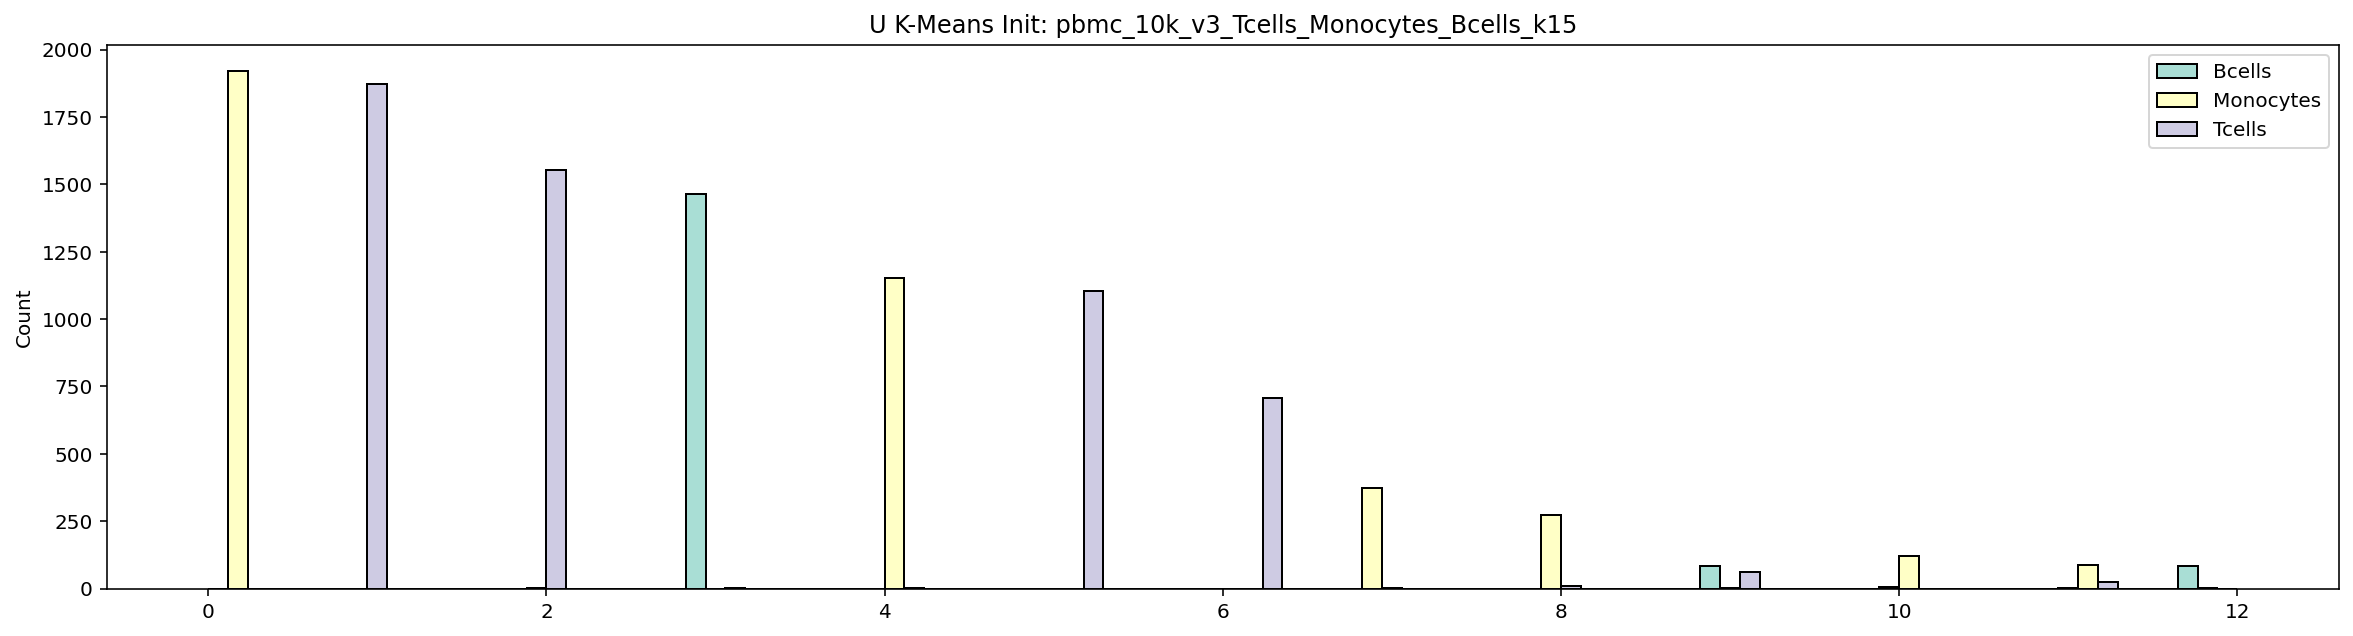

In [127]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('U Leiden: '+dataset_names[i])
    
    
    


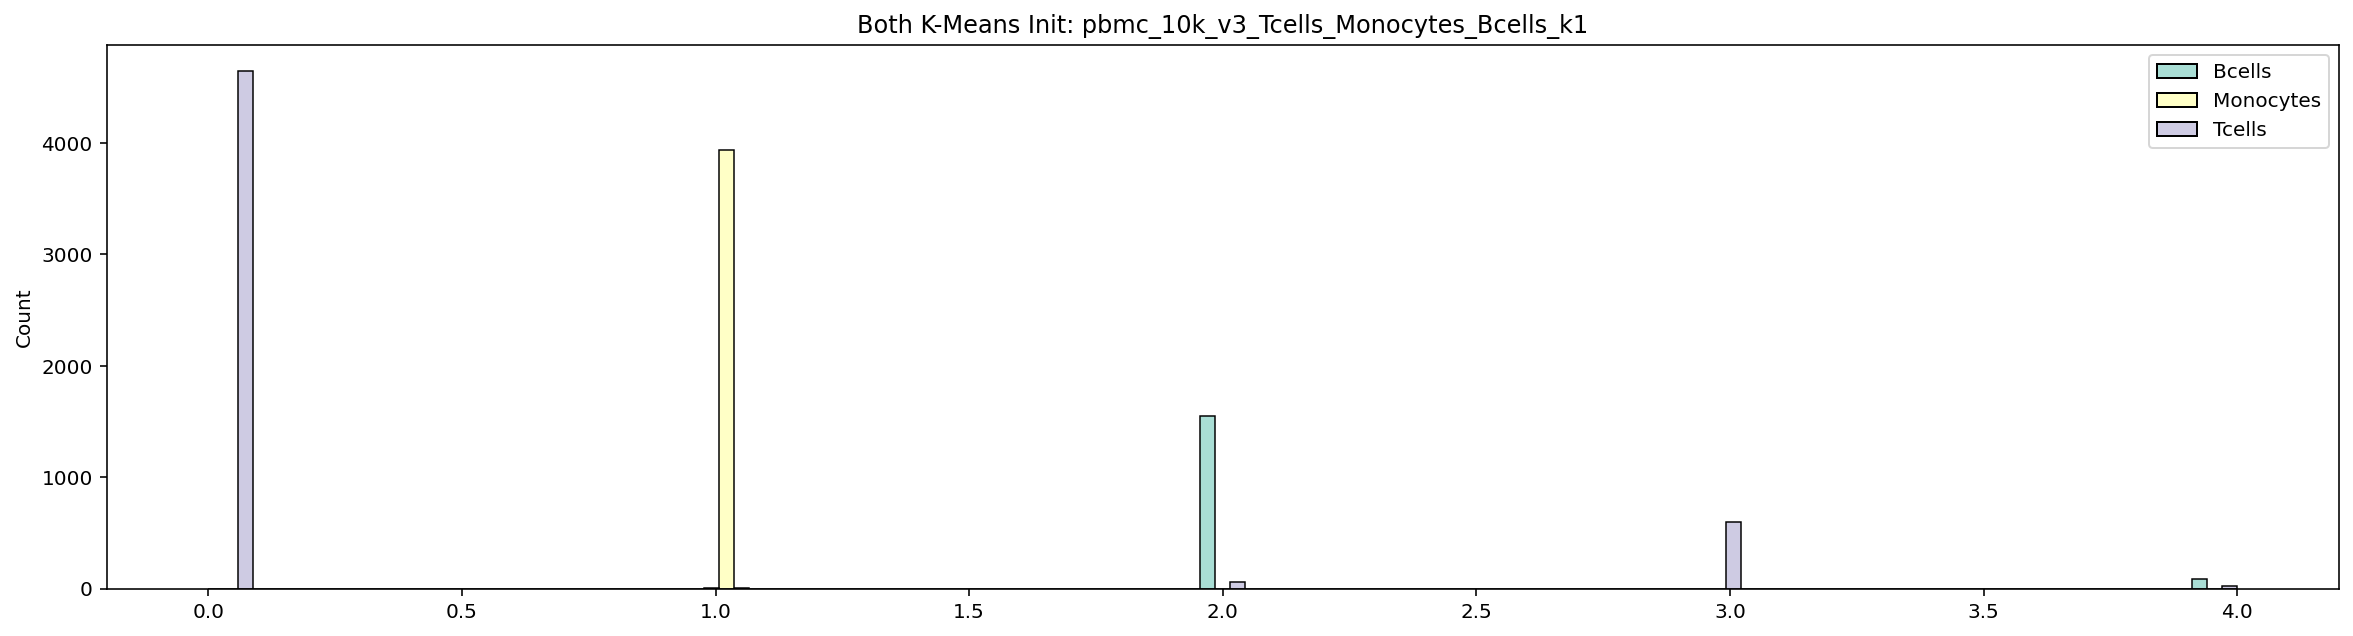

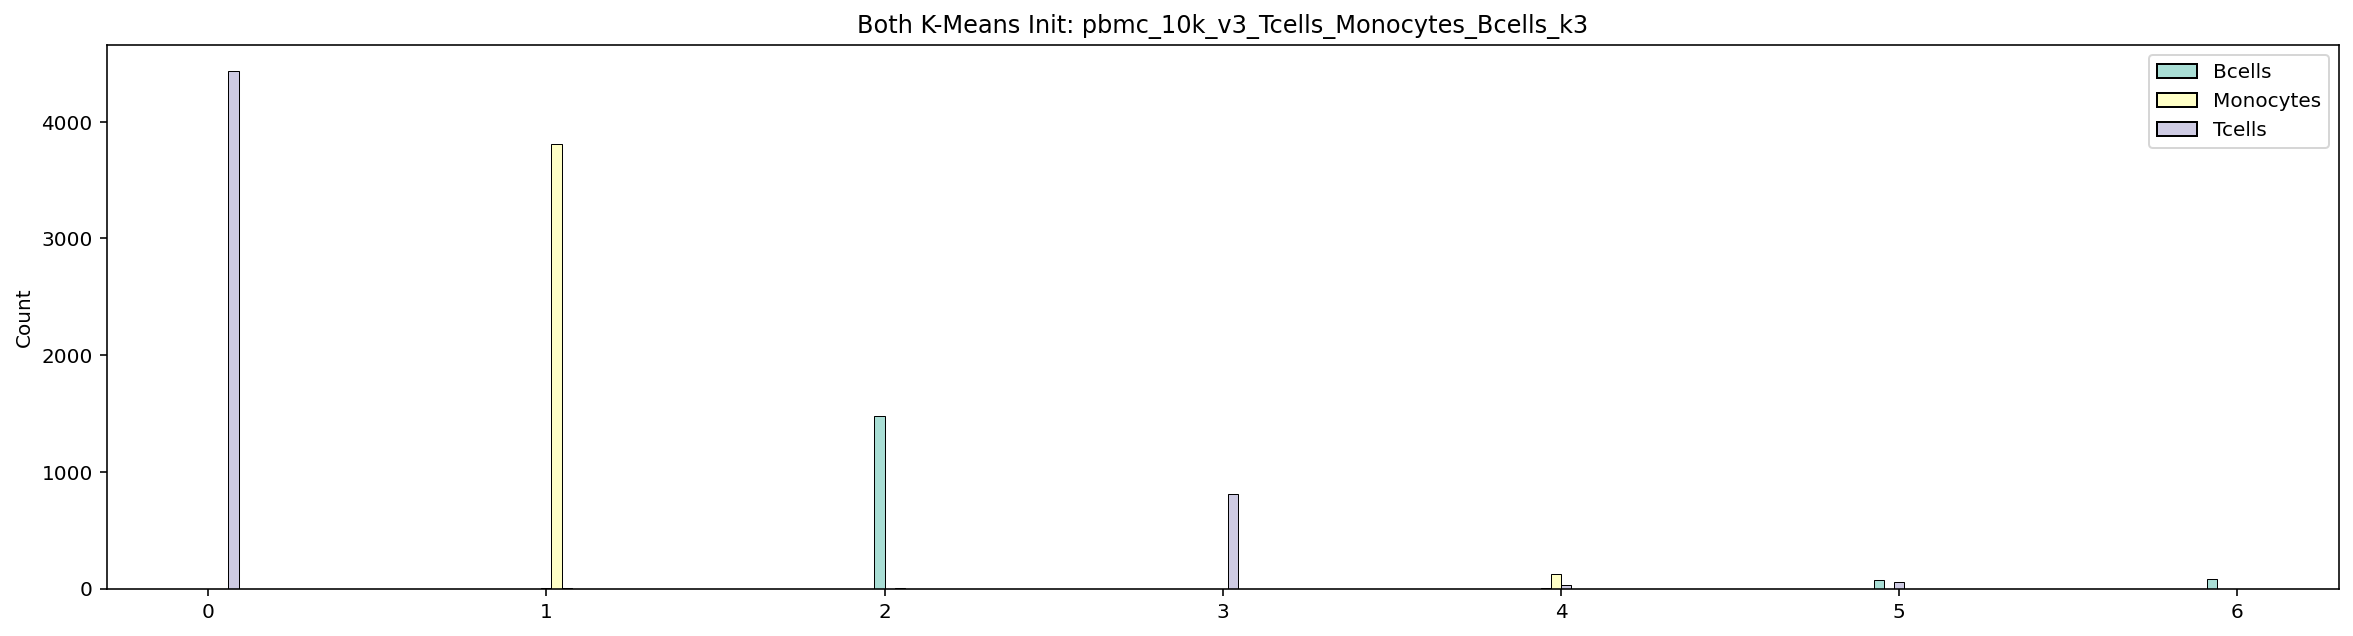

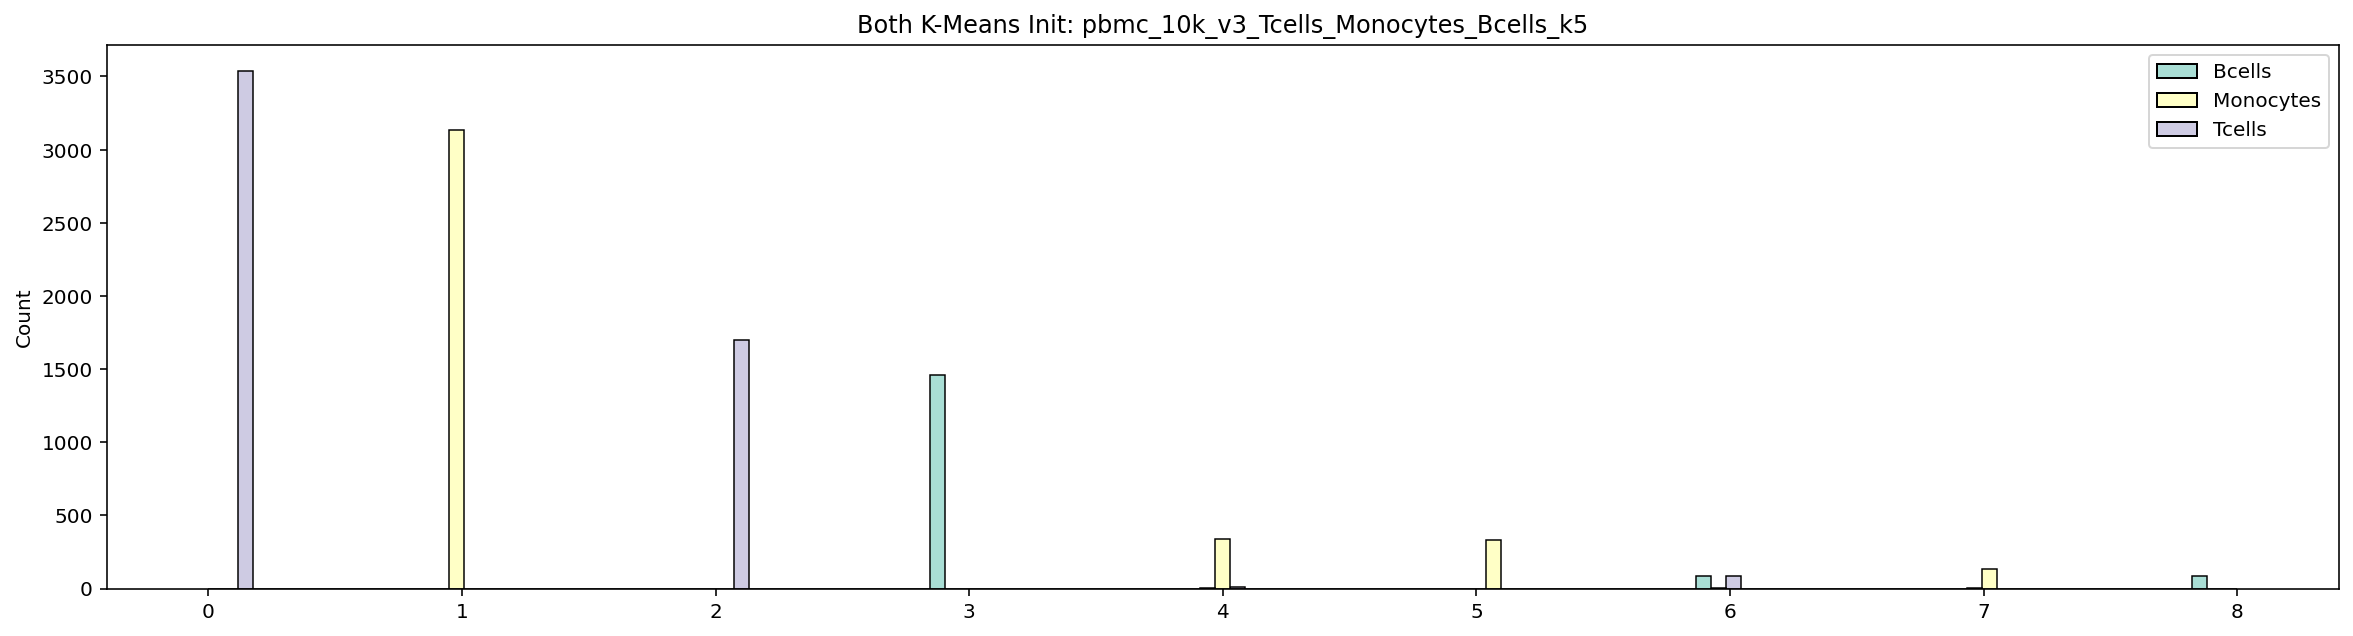

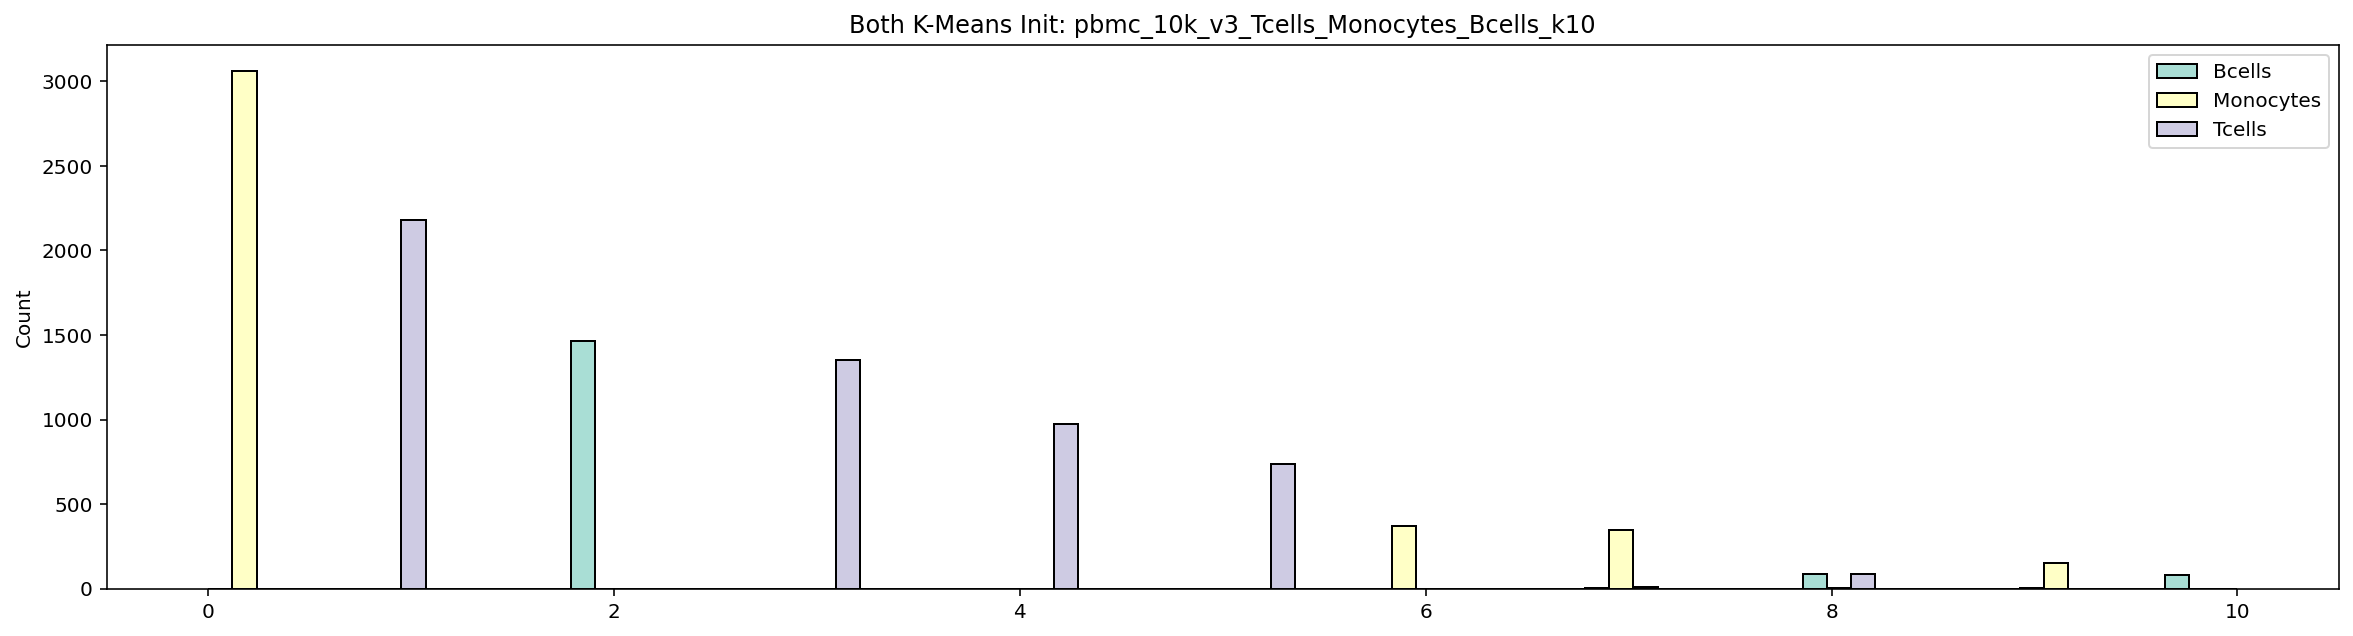

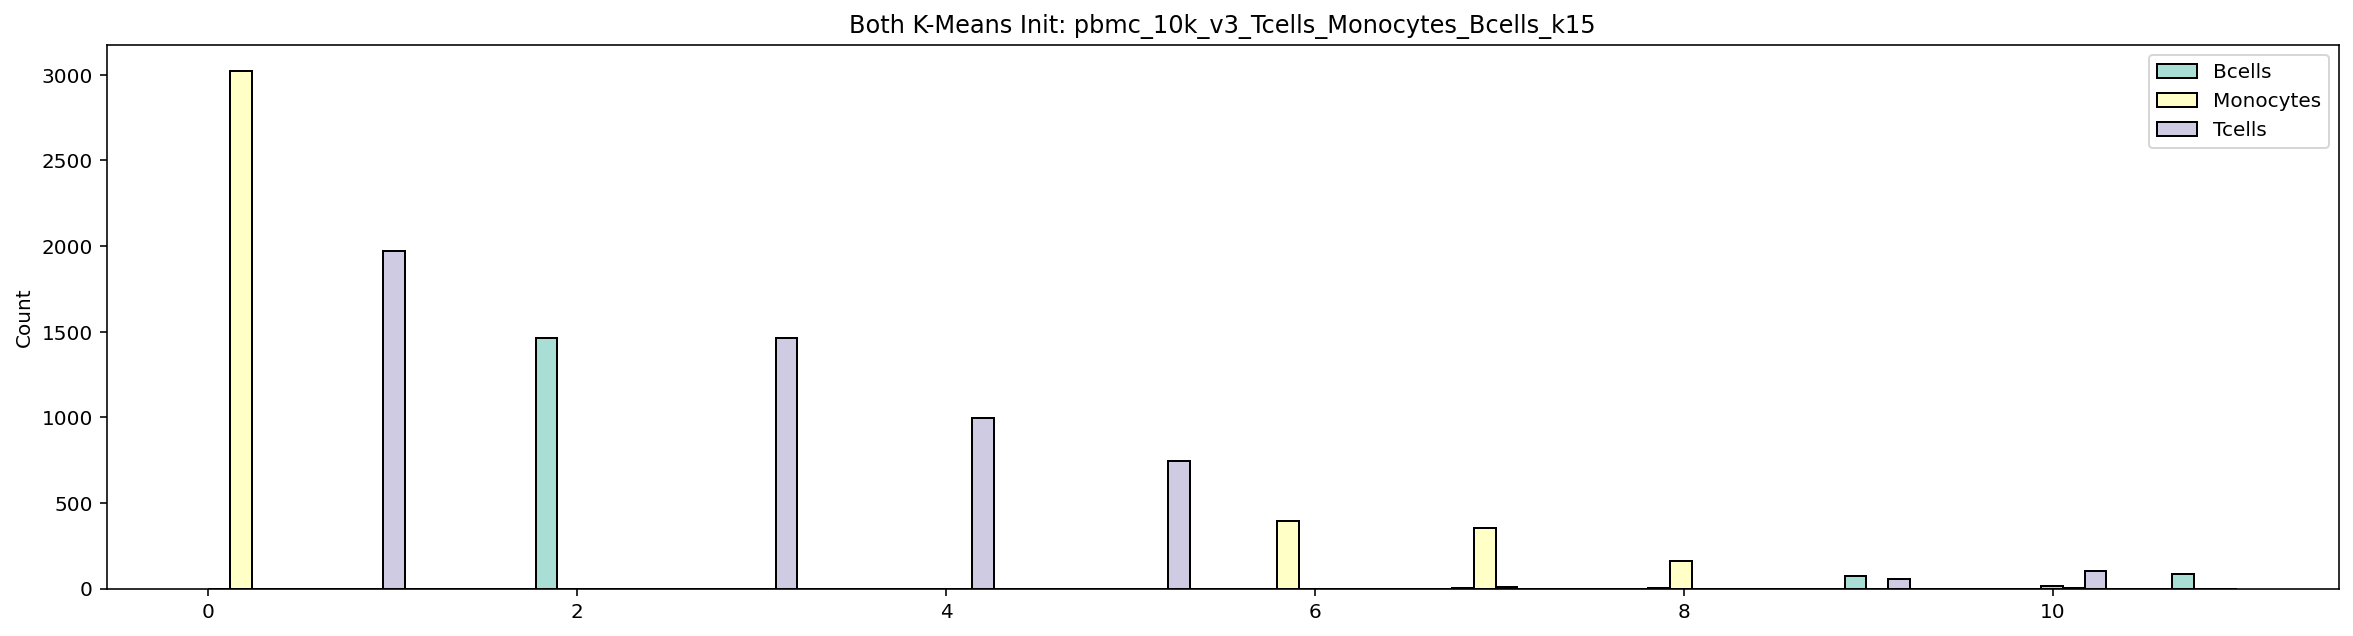

In [128]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('Both Leiden: '+dataset_names[i])
    
    
    


(7, 7)
(12, 12)
(12, 12)
(11, 11)
(13, 13)
(13, 13)
(12, 12)


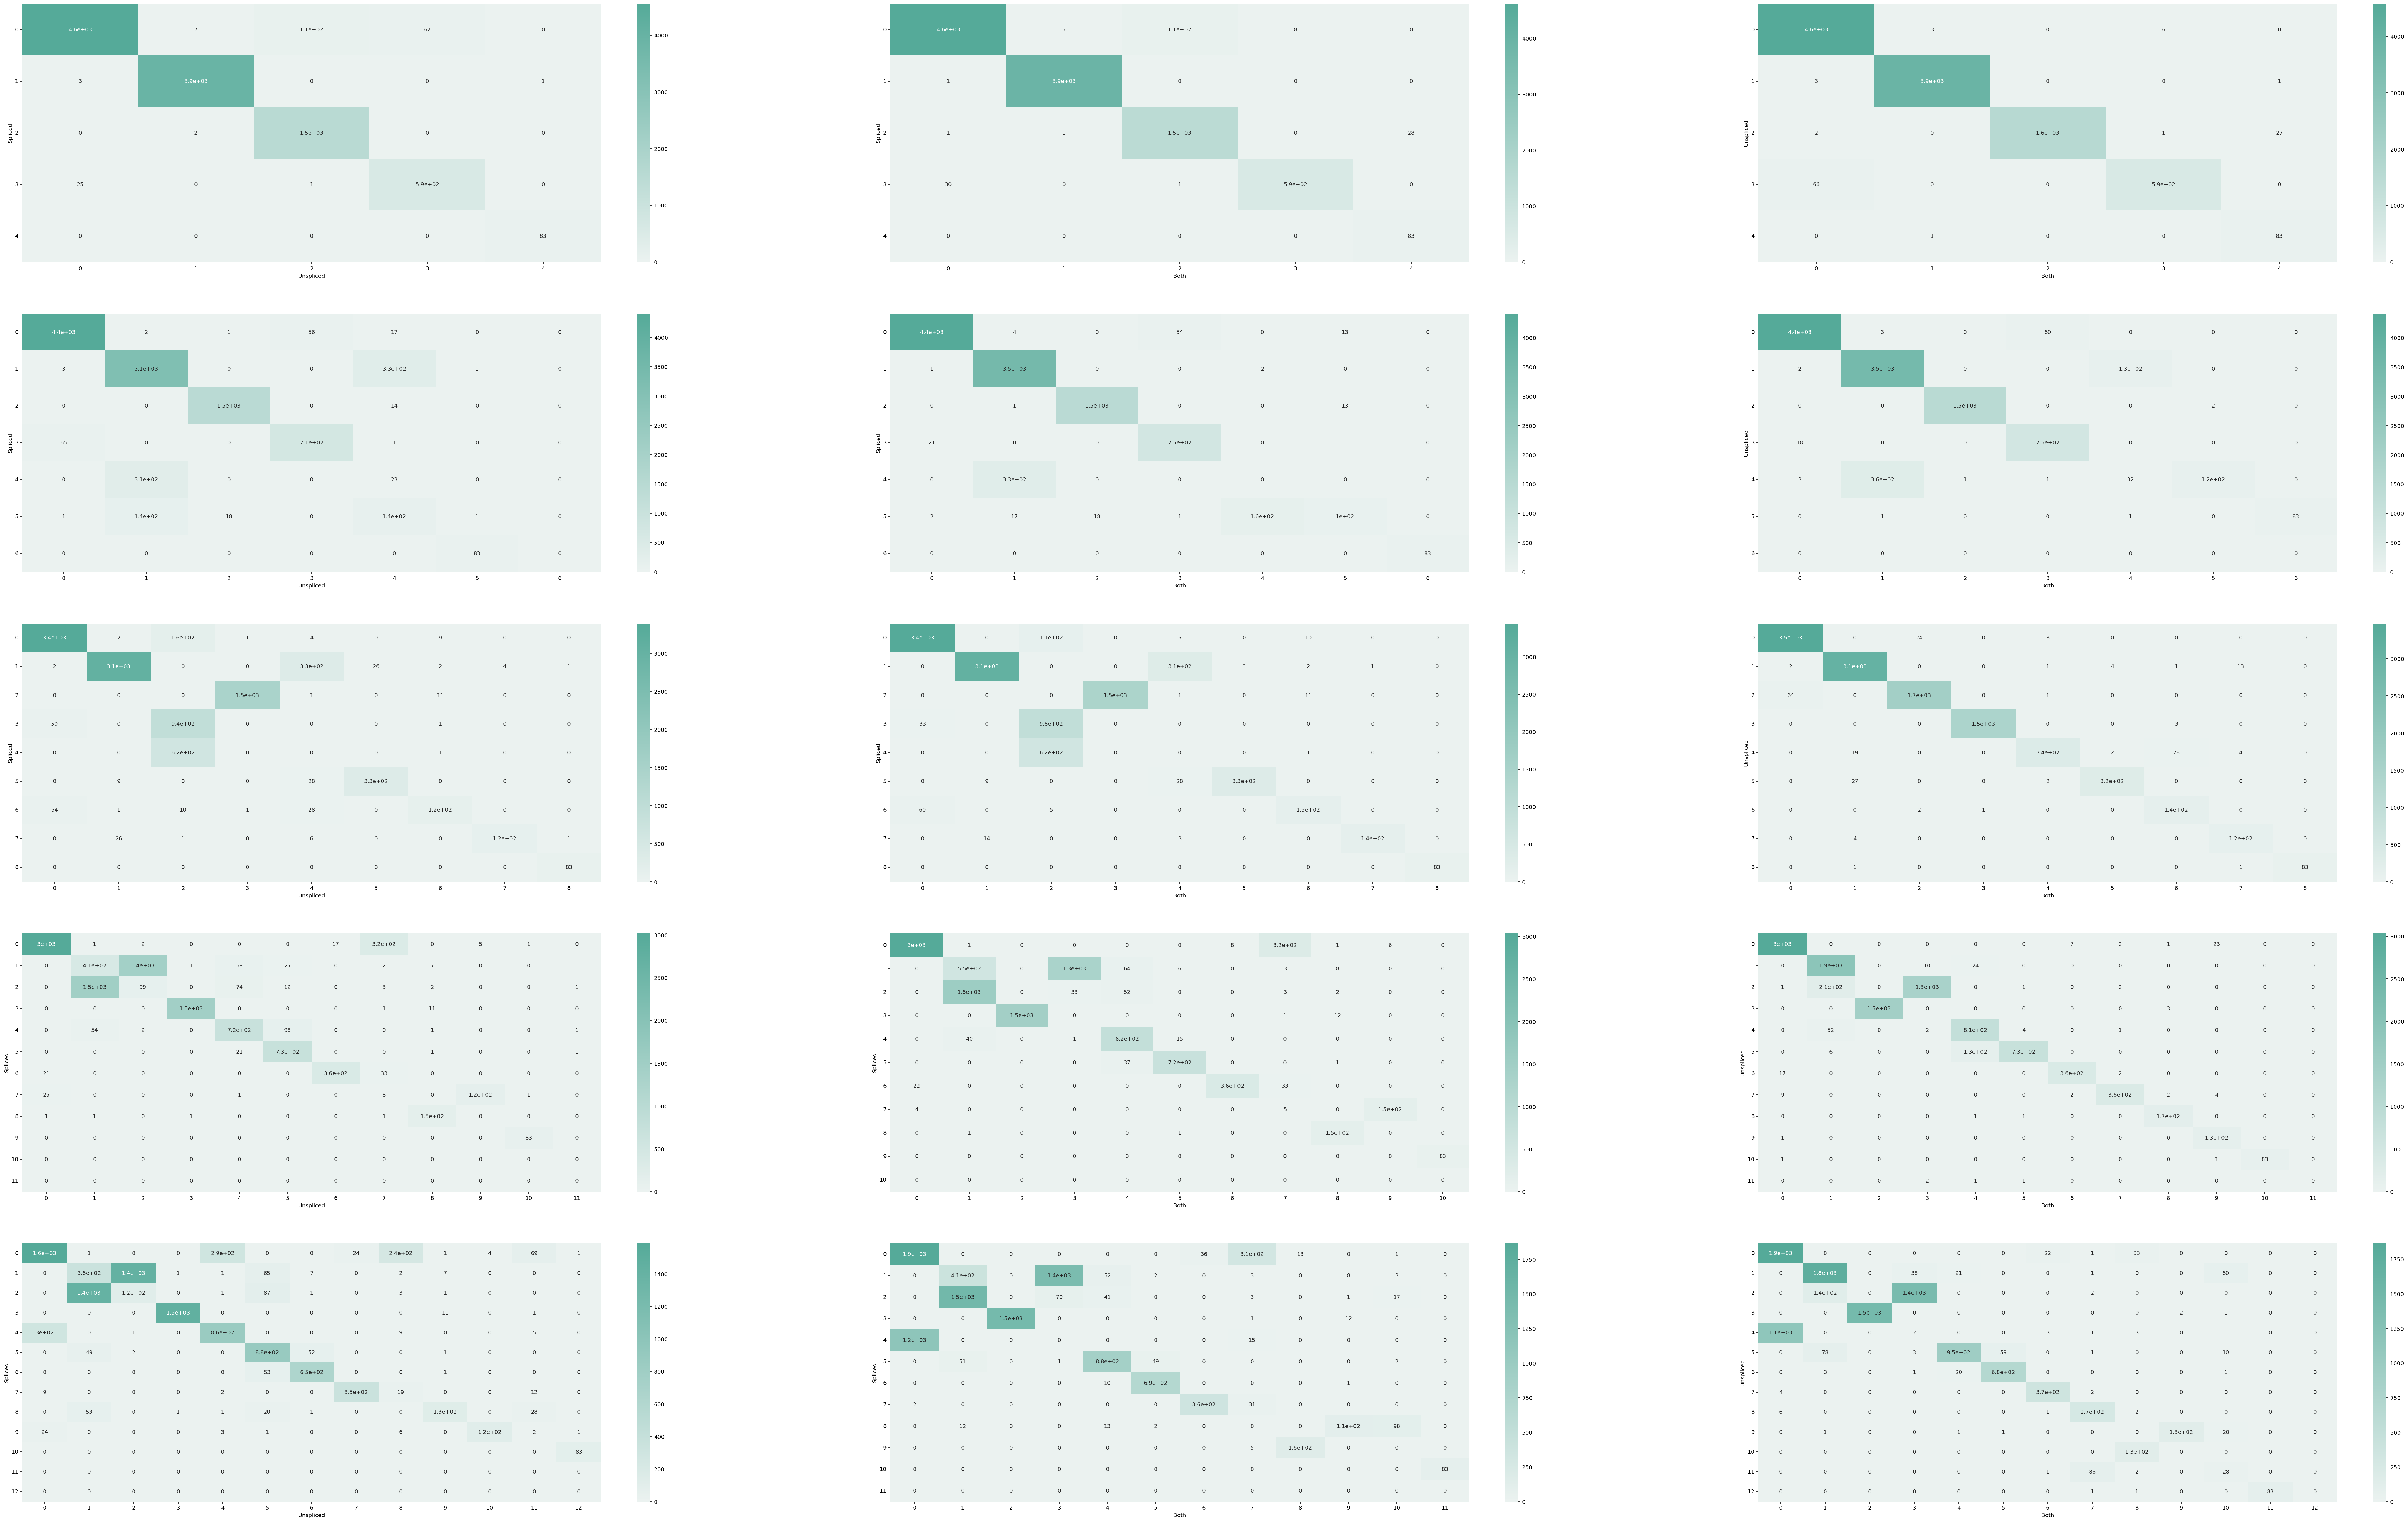

In [133]:
#compare overlap of all k-means assignments

num_per_set = num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(80,50))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

## **Run MM/Monod Inference**

v----------- Only Run Once -----------v

In [327]:
#Define bounds, 
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


In [328]:
len(dataset_names)

7

In [329]:
# dataset_names

In [330]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-3,len(dataset_names)): 

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string,viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230426_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [07:47<00:00,  4.25s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 469.6 seconds.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230426_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [08:12<00:00,  4.48s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 494.3 seconds.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [06:53<00:00,  3.76s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 415.6 seconds.


In [331]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-3):]]


INFO:root:Grid scan results loaded from ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11/grid_scan_results.res.
(-5.666666666666666, -0.6999999999999997)
(-5.666666666666666, -0.6999999999999997)
(-5.666666666666666, -0.6999999999999997)


Text(0, 0.5, '$\\log_{10} \\lambda_M$')

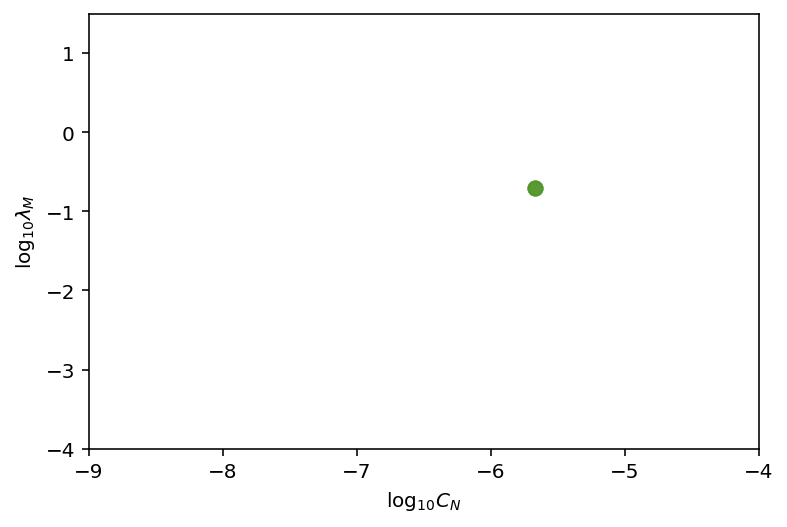

In [332]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
plt.figure()
for r in sr:
    r.find_sampling_optimum()
    print(r.samp_optimum)
    plt.scatter(r.samp_optimum[0],r.samp_optimum[1],alpha=0.7,s=50)
    
plt.xlim([-9,-4])
plt.ylim([-4,1.5])

plt.xlabel(r'$\log_{10} C_N$')
plt.ylabel(r'$\log_{10} \lambda_M$')

In [373]:
# #Find closest technical param in grid, to centroid of technical params on plot
# arbitrary_params = np.asarray([-8.5,-2.5]) #-8,-2.5
# arbitrary_ind = np.argmin(((sr[0].sp.sampl_vals-arbitrary_params)**2).sum(1))
# arbitrary_pars = sr[0].sp.sampl_vals[arbitrary_ind]
# print(arbitrary_pars)

(-8.444444444444445, -2.3499999999999996)


^----------- Only Run Once -----------^

In [130]:
#Define bounds, choose 'centroid'
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-5.666666666666666, -0.6999999999999997] 
samp_ub = [-5.666666666666666, -0.6999999999999997] 
# gridsize = [5,6]
gridsize = [1,1]

In [ ]:
#Run Monod as control on separate groups <---COME BACK TO THIS!!!!!!!
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-3,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)
    

In [ ]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[len(dataset_names)-4:]]

In [ ]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

**Run Mixture Model**

In [134]:
epochs = 30 

In [135]:
result_strings = []
for i in [1,2,3,4,0]: #range(num_ks-1,-1,-1): #rlen(chosen)*num_ks, 1,2,3,4,0
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k15
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230426_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:15<00:00, 21.05s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:43<00:00, 24.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.91873658e-02 2.30821685e-04 1.13150969e-01 5.71361621e-02
 9.08077352e-02 1.45213252e-01 2.15213401e-01 2.04710664e-02
 7.33162230e-03 2.58725825e-09 1.84030379e-01 1.29109572e-02
 1.18979215e-01 1.88223603e-03 3.45481461e-03]
Q Function:  -19082567.631695352

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:08<00:00, 22.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.44051560e-02 9.16338311e-11 1.29271692e-01 5.35715950e-02
 1.01335594e-01 1.33966840e-01 2.00393172e-01 2.41731027e-02
 7.33070658e-03 6.84707677e-03 1.83541148e-01 1.36280068e-02
 1.17340624e-01 2.74918939e-04 3.92036655e-03]
Q Function:  -17892319.62518255

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [04:47<00:00, 22.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.99079058e-02 9.16338311e-11 1.41959561e-01 5.30222767e-02
 1.08143132e-01 1.30812831e-01 1.91391712e-01 2.54724471e-02
 7.33070658e-03 7.33000189e-03 1.81088747e-01 1.17423550e-02
 1.17766435e-01 9.16338311e-11 4.03188866e-03]
Q Function:  -17879846.09437567

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [05:06<00:00, 23.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.08472597e-02 9.16338311e-11 1.36462834e-01 5.31780063e-02
 1.12868238e-01 1.27555108e-01 1.97592726e-01 2.18425560e-02
 7.33070658e-03 4.77019850e-03 1.79200093e-01 1.26688666e-02
 1.21743152e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17891844.1516653

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [05:28<00:00, 25.25s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.82393922e-02 9.16338311e-11 1.46056665e-01 5.34111187e-02
 1.14270221e-01 1.22340643e-01 1.92656750e-01 2.03220745e-02
 7.33070658e-03 2.70996578e-03 1.81902133e-01 1.34075256e-02
 1.23412549e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17871537.982434012

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [05:01<00:00, 23.19s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.94317658e-02 9.16338311e-11 1.43656133e-01 5.34408708e-02
 1.15310977e-01 1.20724241e-01 1.94278993e-01 2.02745139e-02
 7.33070658e-03 2.29589361e-03 1.82286790e-01 1.34372407e-02
 1.23591619e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17874776.80386845

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [04:43<00:00, 21.77s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.07748395e-02 9.16338311e-11 1.44388645e-01 5.33572430e-02
 1.16120260e-01 1.19805405e-01 1.93506163e-01 2.05888278e-02
 7.33070658e-03 9.01505848e-04 1.82444892e-01 1.32500124e-02
 1.23591245e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17874804.468631558

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [04:45<00:00, 21.96s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.93157527e-02 9.16338311e-11 1.51418359e-01 5.15059076e-02
 1.17297103e-01 1.15061210e-01 1.88653774e-01 2.07144026e-02
 7.33070658e-03 9.16340510e-05 1.87036557e-01 1.41172590e-02
 1.23517079e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17868072.171909902

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:42<00:00, 23.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.78804667e-02 9.16338311e-11 1.54638483e-01 5.08218242e-02
 1.17863053e-01 1.11247368e-01 1.86960570e-01 1.92215043e-02
 7.33070658e-03 9.16338311e-11 1.90880772e-01 1.42052503e-02
 1.25009748e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17871711.019174837

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:12<00:00, 26.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.80448367e-02 9.16338311e-11 1.55486861e-01 5.23726402e-02
 1.15815566e-01 1.08865688e-01 1.85947822e-01 1.83735592e-02
 7.33070658e-03 9.16338311e-11 1.93754363e-01 1.42032495e-02
 1.25864453e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17866168.735954065

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:31<00:00, 22.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.70818633e-02 9.16338311e-11 1.57635607e-01 5.25216039e-02
 1.16019981e-01 1.06914115e-01 1.84762049e-01 1.82346165e-02
 7.33070658e-03 9.16338311e-11 1.95358860e-01 1.41898175e-02
 1.26010525e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17873140.795300495

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:21<00:00, 26.77s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.61367877e-02 9.16338311e-11 1.58890227e-01 5.25253918e-02
 1.16665568e-01 1.07435588e-01 1.84452504e-01 1.81835660e-02
 7.33070658e-03 9.16338311e-11 1.94185413e-01 1.41967828e-02
 1.26057210e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17881266.20131956

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:15<00:00, 26.28s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60831380e-02 9.16338311e-11 1.59026423e-01 5.25314648e-02
 1.16989549e-01 1.07349688e-01 1.84369958e-01 1.81577866e-02
 7.33070658e-03 9.16338311e-11 1.93941423e-01 1.41846365e-02
 1.26094971e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879566.750909325

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:37<00:00, 23.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829747e-02 9.16338311e-11 1.59026763e-01 5.25450778e-02
 1.17312543e-01 1.07335945e-01 1.84369782e-01 1.81577710e-02
 7.33070658e-03 9.16338311e-11 1.93618501e-01 1.41846447e-02
 1.26095036e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879567.593381815

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:47<00:00, 23.92s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25532850e-02
 1.17458264e-01 1.07282355e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93518333e-01 1.41846446e-02
 1.26094866e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879533.82532957

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:39<00:00, 23.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25512057e-02
 1.17524172e-01 1.07232943e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503921e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.200937968

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:46<00:00, 23.88s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511435e-02
 1.17524468e-01 1.07232686e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503944e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20246572

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:51<00:00, 24.28s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.202471353

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:38<00:00, 23.21s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:44<00:00, 23.69s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.202471375

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:07<00:00, 25.60s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:14<00:00, 31.21s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:03<00:00, 30.29s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 24/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:40<00:00, 33.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:15<00:00, 31.27s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:38<00:00, 33.25s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:22<00:00, 26.90s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 28/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:52<00:00, 29.35s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:10<00:00, 30.86s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:18<00:00, 31.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.60829743e-02 9.16338311e-11 1.59026764e-01 5.25511431e-02
 1.17524469e-01 1.07232684e-01 1.84369781e-01 1.81577709e-02
 7.33070658e-03 9.16338311e-11 1.93503945e-01 1.41846443e-02
 1.26094862e-01 9.16338311e-11 3.94025483e-03]
Q Function:  -17879538.20247137

INFO:root:Non-parallelized grid scan complete.


## **Analysis of Results**

In [136]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_dict = dict(zip(np.unique(list(true)),range(len(np.unique(list(true))))))
    true = [true_dict[x] for x in true]                
    
    true_copy = list(true)

    
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Set3',multiple="dodge")
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [137]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [138]:
#Plot param distributions for specified clusters

def vis_params(param_estimates,assigns_toplot = [],title='',figsize=(18, 5)):
    
    #Plot param distributions
    pal = sns.color_palette('tab20')
    palette = {0:pal[0], 1:pal[1] ,2:pal[2] , 3:pal[3] , 4:pal[4] , 
               5:pal[5] , 6:pal[6] , 7:pal[7] , 8:pal[8] , 9:pal[9],
              10:pal[10], 11:pal[11] ,12:pal[12] , 13:pal[13] , 14:pal[14] , 
               15:pal[15] , 16:pal[16] , 17:pal[17] , 18:pal[18] , 19:pal[19]}

    if len(assigns_toplot) < 1:
        assigns_toplot = range(param_estimates.shape[2])
       
    bs = []
    betas = []
    gammas = []
    clus = []
    for a in assigns_toplot:
        bs += list(param_estimates[:,0,a])
        betas += list(param_estimates[:,1,a])
        gammas += list(param_estimates[:,2,a])
        clus += [a]*param_estimates[:,0,a].shape[0]
        
    res = pd.DataFrame()
    res['b'] = bs
    res['beta'] = betas
    res['gamma'] = gammas
    res['Assignment'] = clus
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.histplot(data=res, x='b',hue='Assignment', kde=True,ax=ax[0],
                 palette=palette,multiple="dodge")
    ax[0].set_xlabel('b')
    ax[0].set_title(title)
    
    sns.histplot(data=res, x='beta',hue='Assignment', kde=True,ax=ax[1],
                 palette=palette,multiple="dodge")
    ax[1].set_xlabel('beta')
    
    sns.histplot(data=res, x='gamma',hue='Assignment', kde=True,ax=ax[2],
                 palette=palette,multiple="dodge")
    ax[2].set_xlabel('gamma')
    
    return res
    

In [139]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[0:num_ks]] #0:len(chosen)*num_ks
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [140]:
assign_dict = dict(zip(np.unique(list(all_assigns)),range(len(np.unique(list(all_assigns))))))
new_assigns = [assign_dict[x] for x in all_assigns]
print(assign_dict)

{'Bcells': 0, 'Monocytes': 1, 'Tcells': 2}


INFO:root:Search data loaded from ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd.


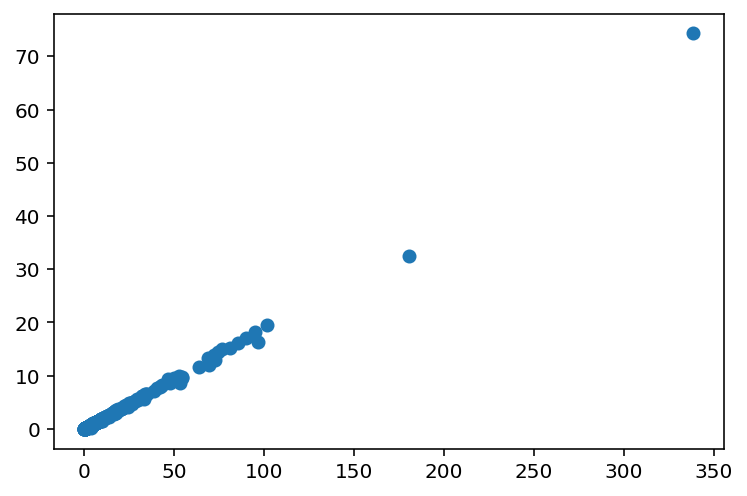

In [153]:
# #Check correlations of means
# #pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/

# #test_fit = monod.analysis.load_search_results('./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/grid_point_0.gp')
# test_fit = grid_point_results[1]
# test_raw = monod.analysis.load_search_data('./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd')


# monod_mu = test_fit.param_estimates[:,0,1] - test_fit.param_estimates[:,2,1]
# means = np.mean(test_raw.layers[1,:,:],axis=1)

# plt.scatter(10**monod_mu,means)
# # 



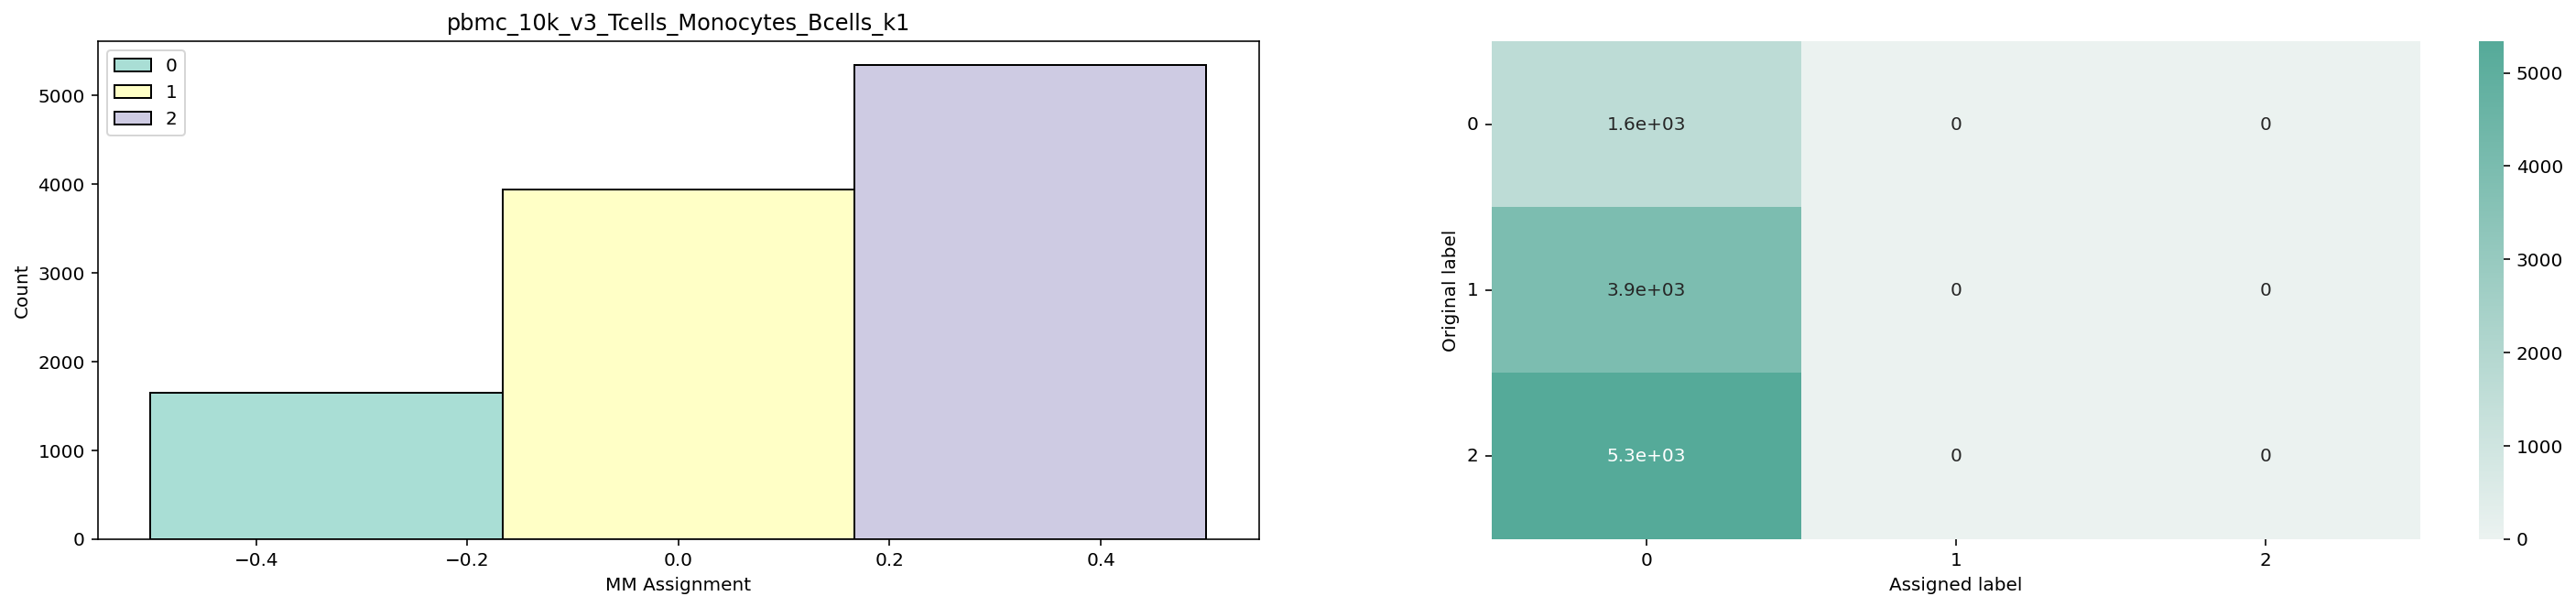

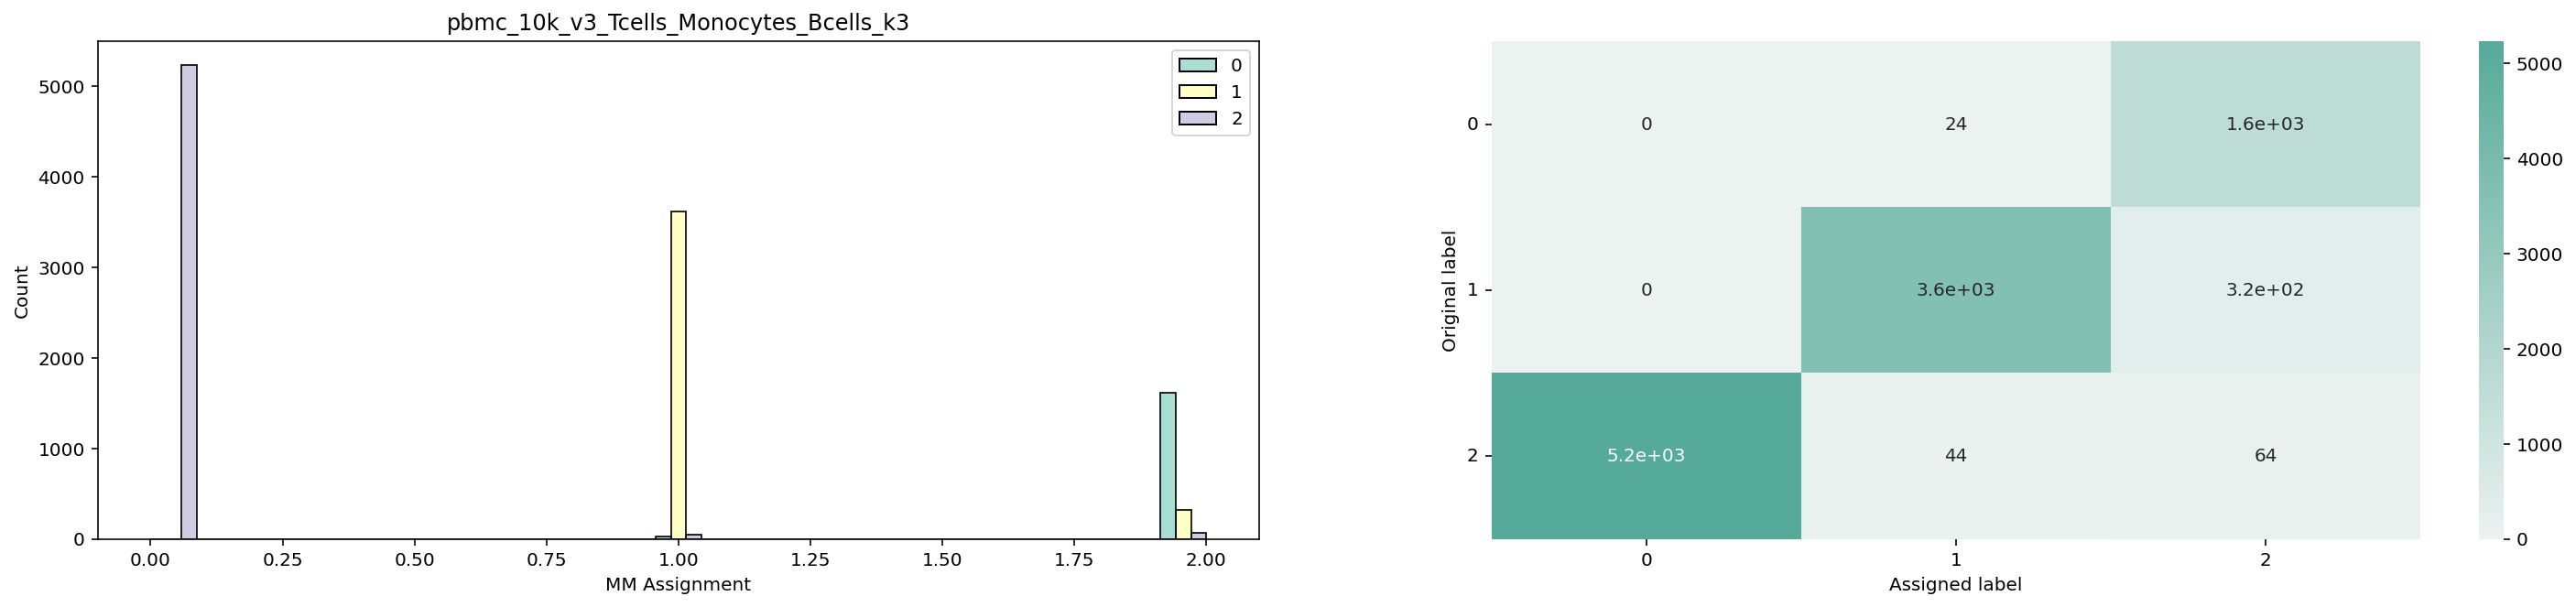

(5, 5)
(5, 5)


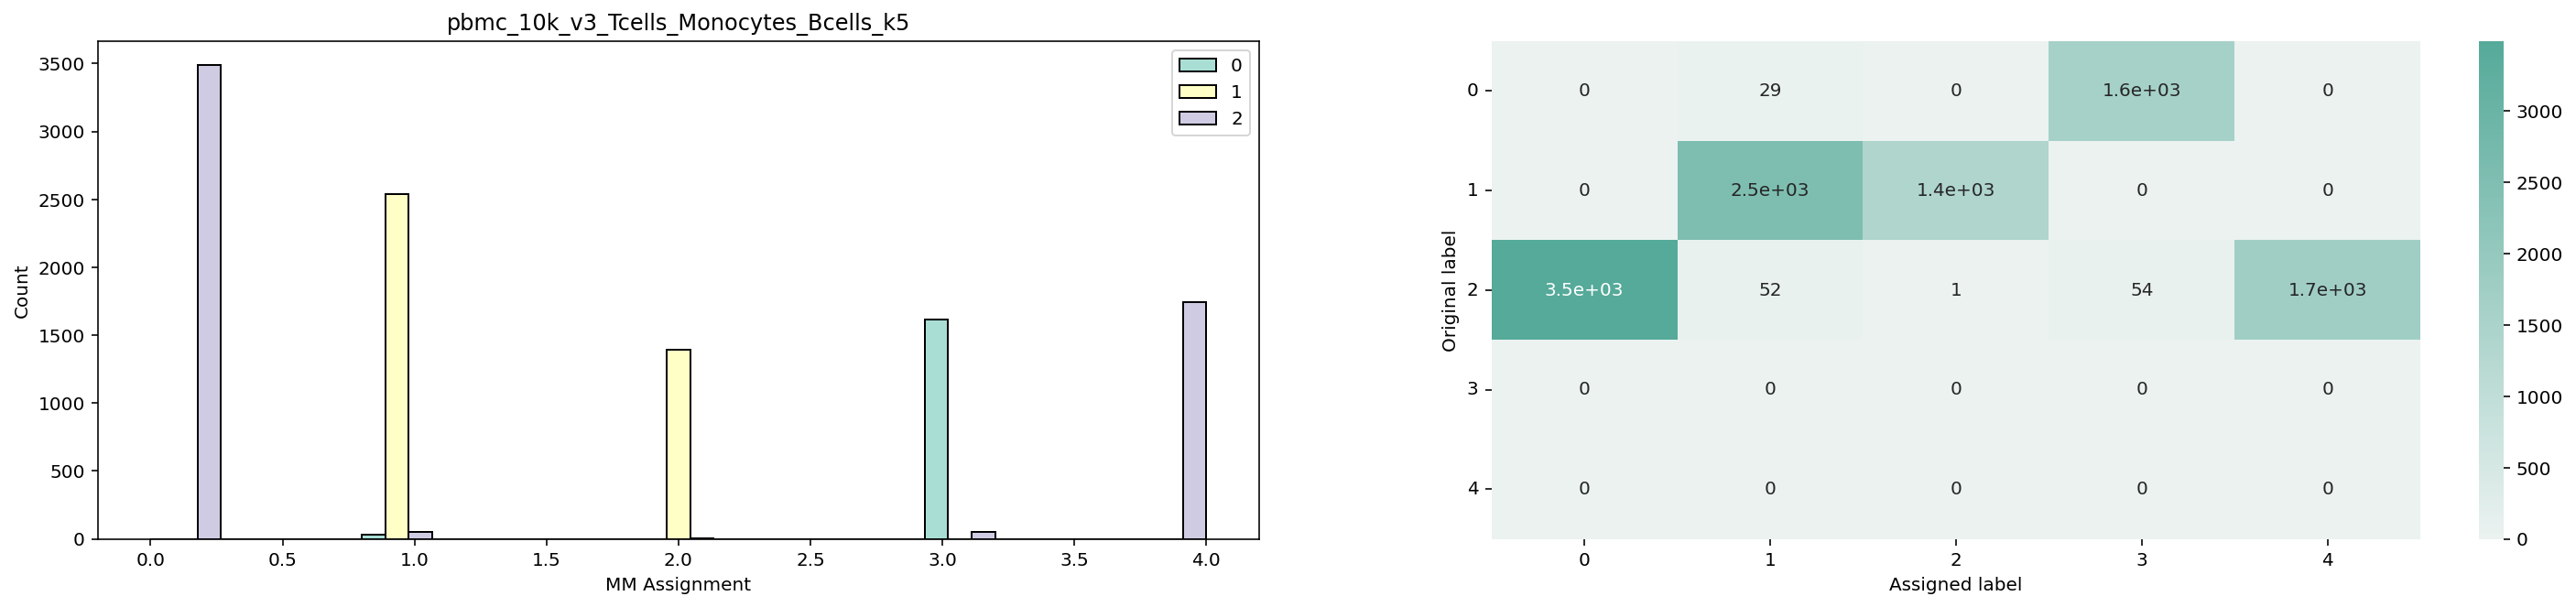

(9, 9)
(9, 9)
(9, 9)
(9, 9)
(9, 9)
(9, 9)


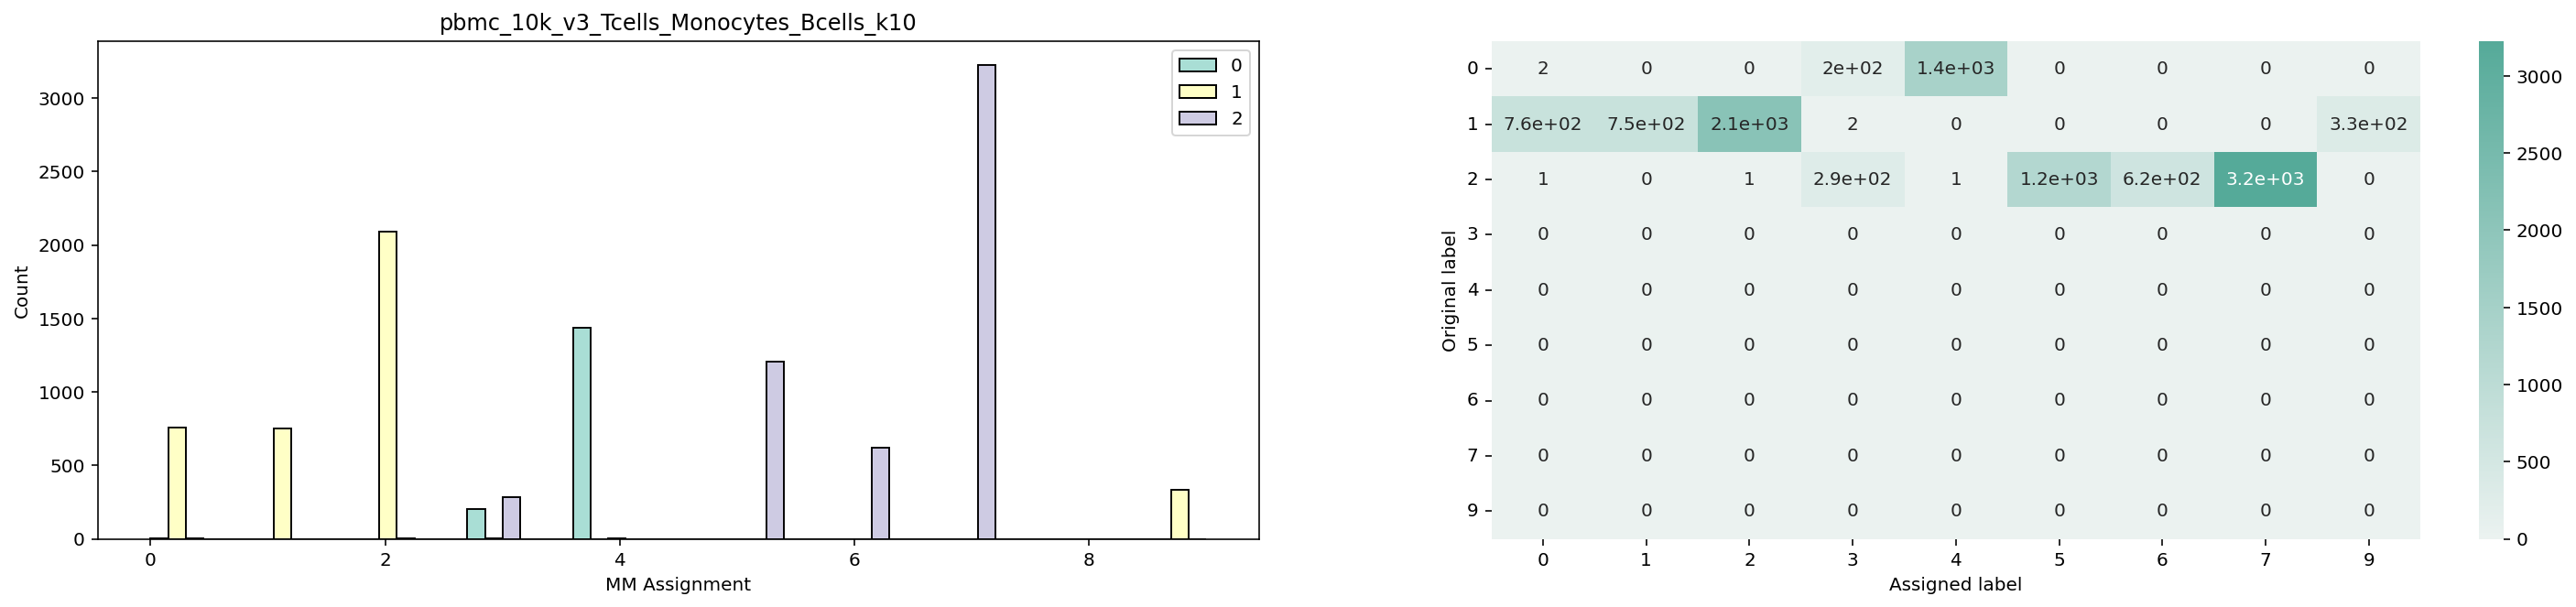

(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)


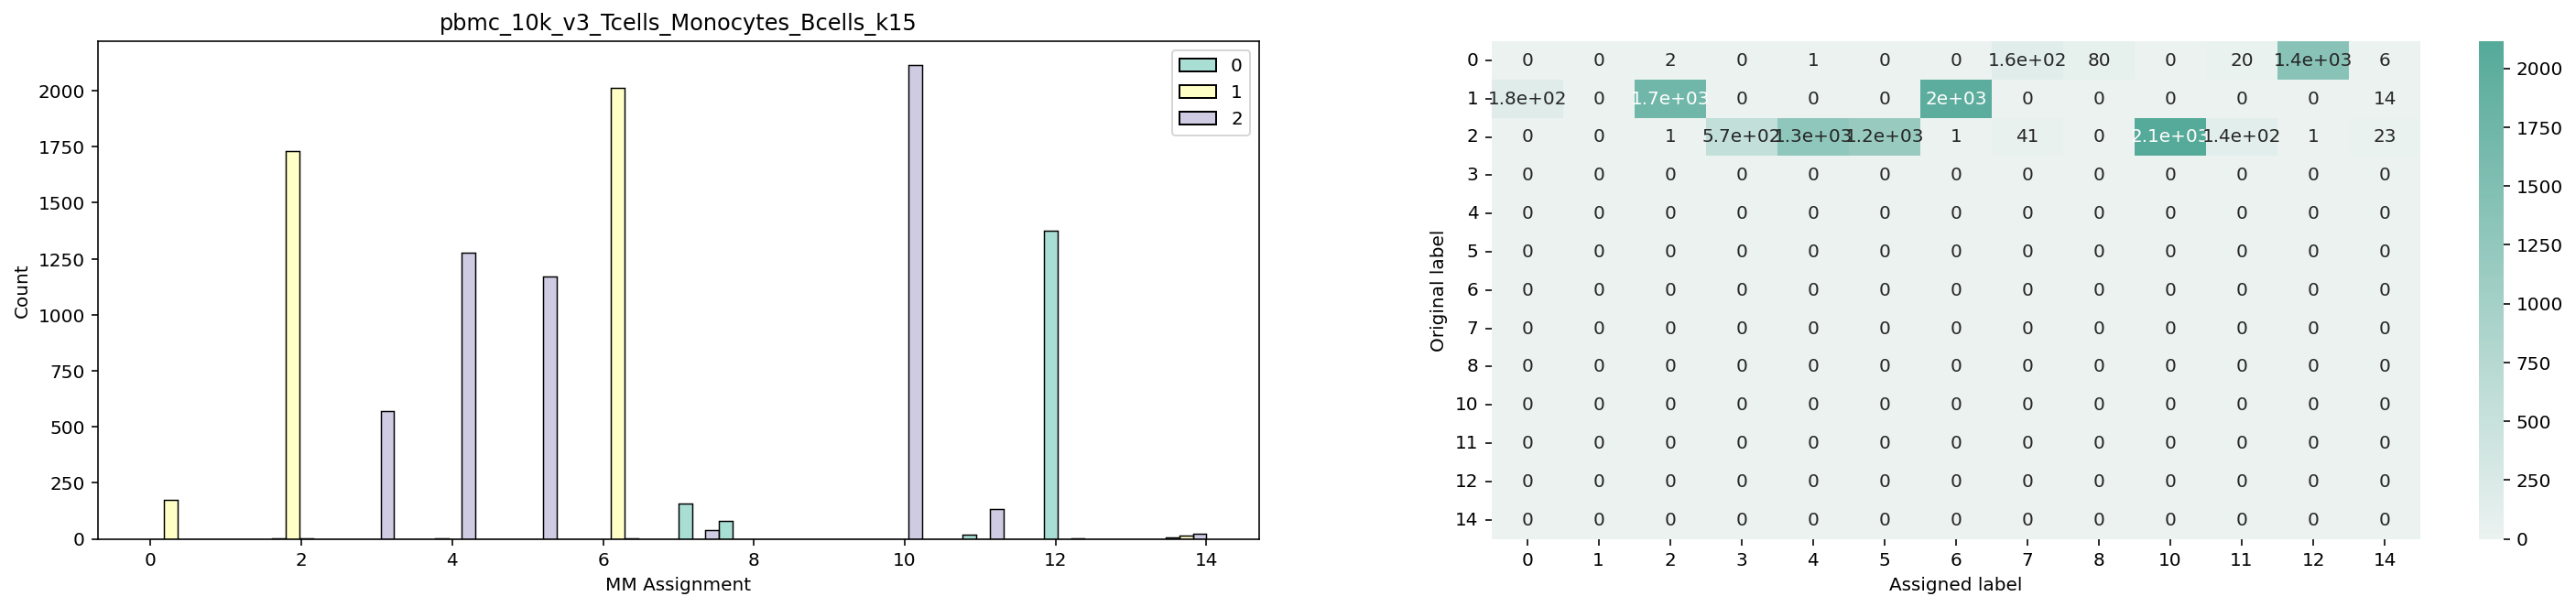

In [143]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    title = r.inference_string.replace('./fits/gg_230426_025_pbmc_MM_1/','')
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(new_assigns),r.assigns,title,figsize=(25, 5))


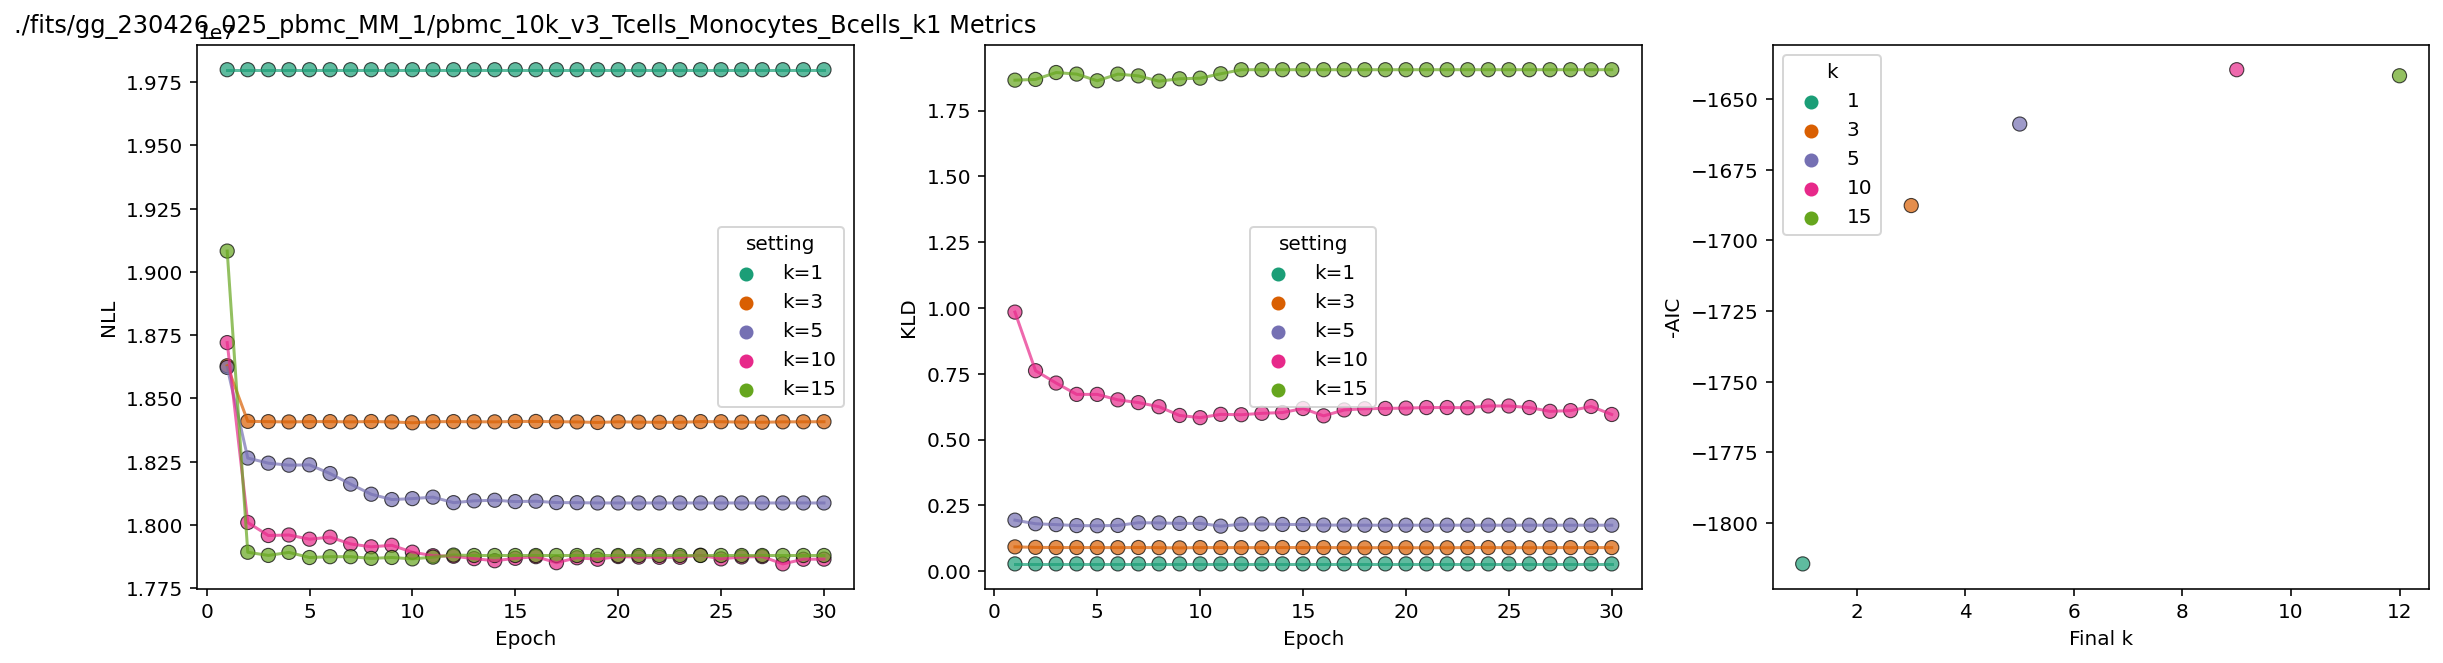

In [144]:
for i in range(0, len(grid_point_results), num_ks):
    r = grid_point_results[i:i+num_ks]
    title = dataset_strings[i]+' Metrics'
    vis_metrics(r,title,ks[0:num_ks],figsize=(20,5))

In [81]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    all_groups_kmeans += [r.assigns]



In [82]:
len(all_groups_kmeans)

16

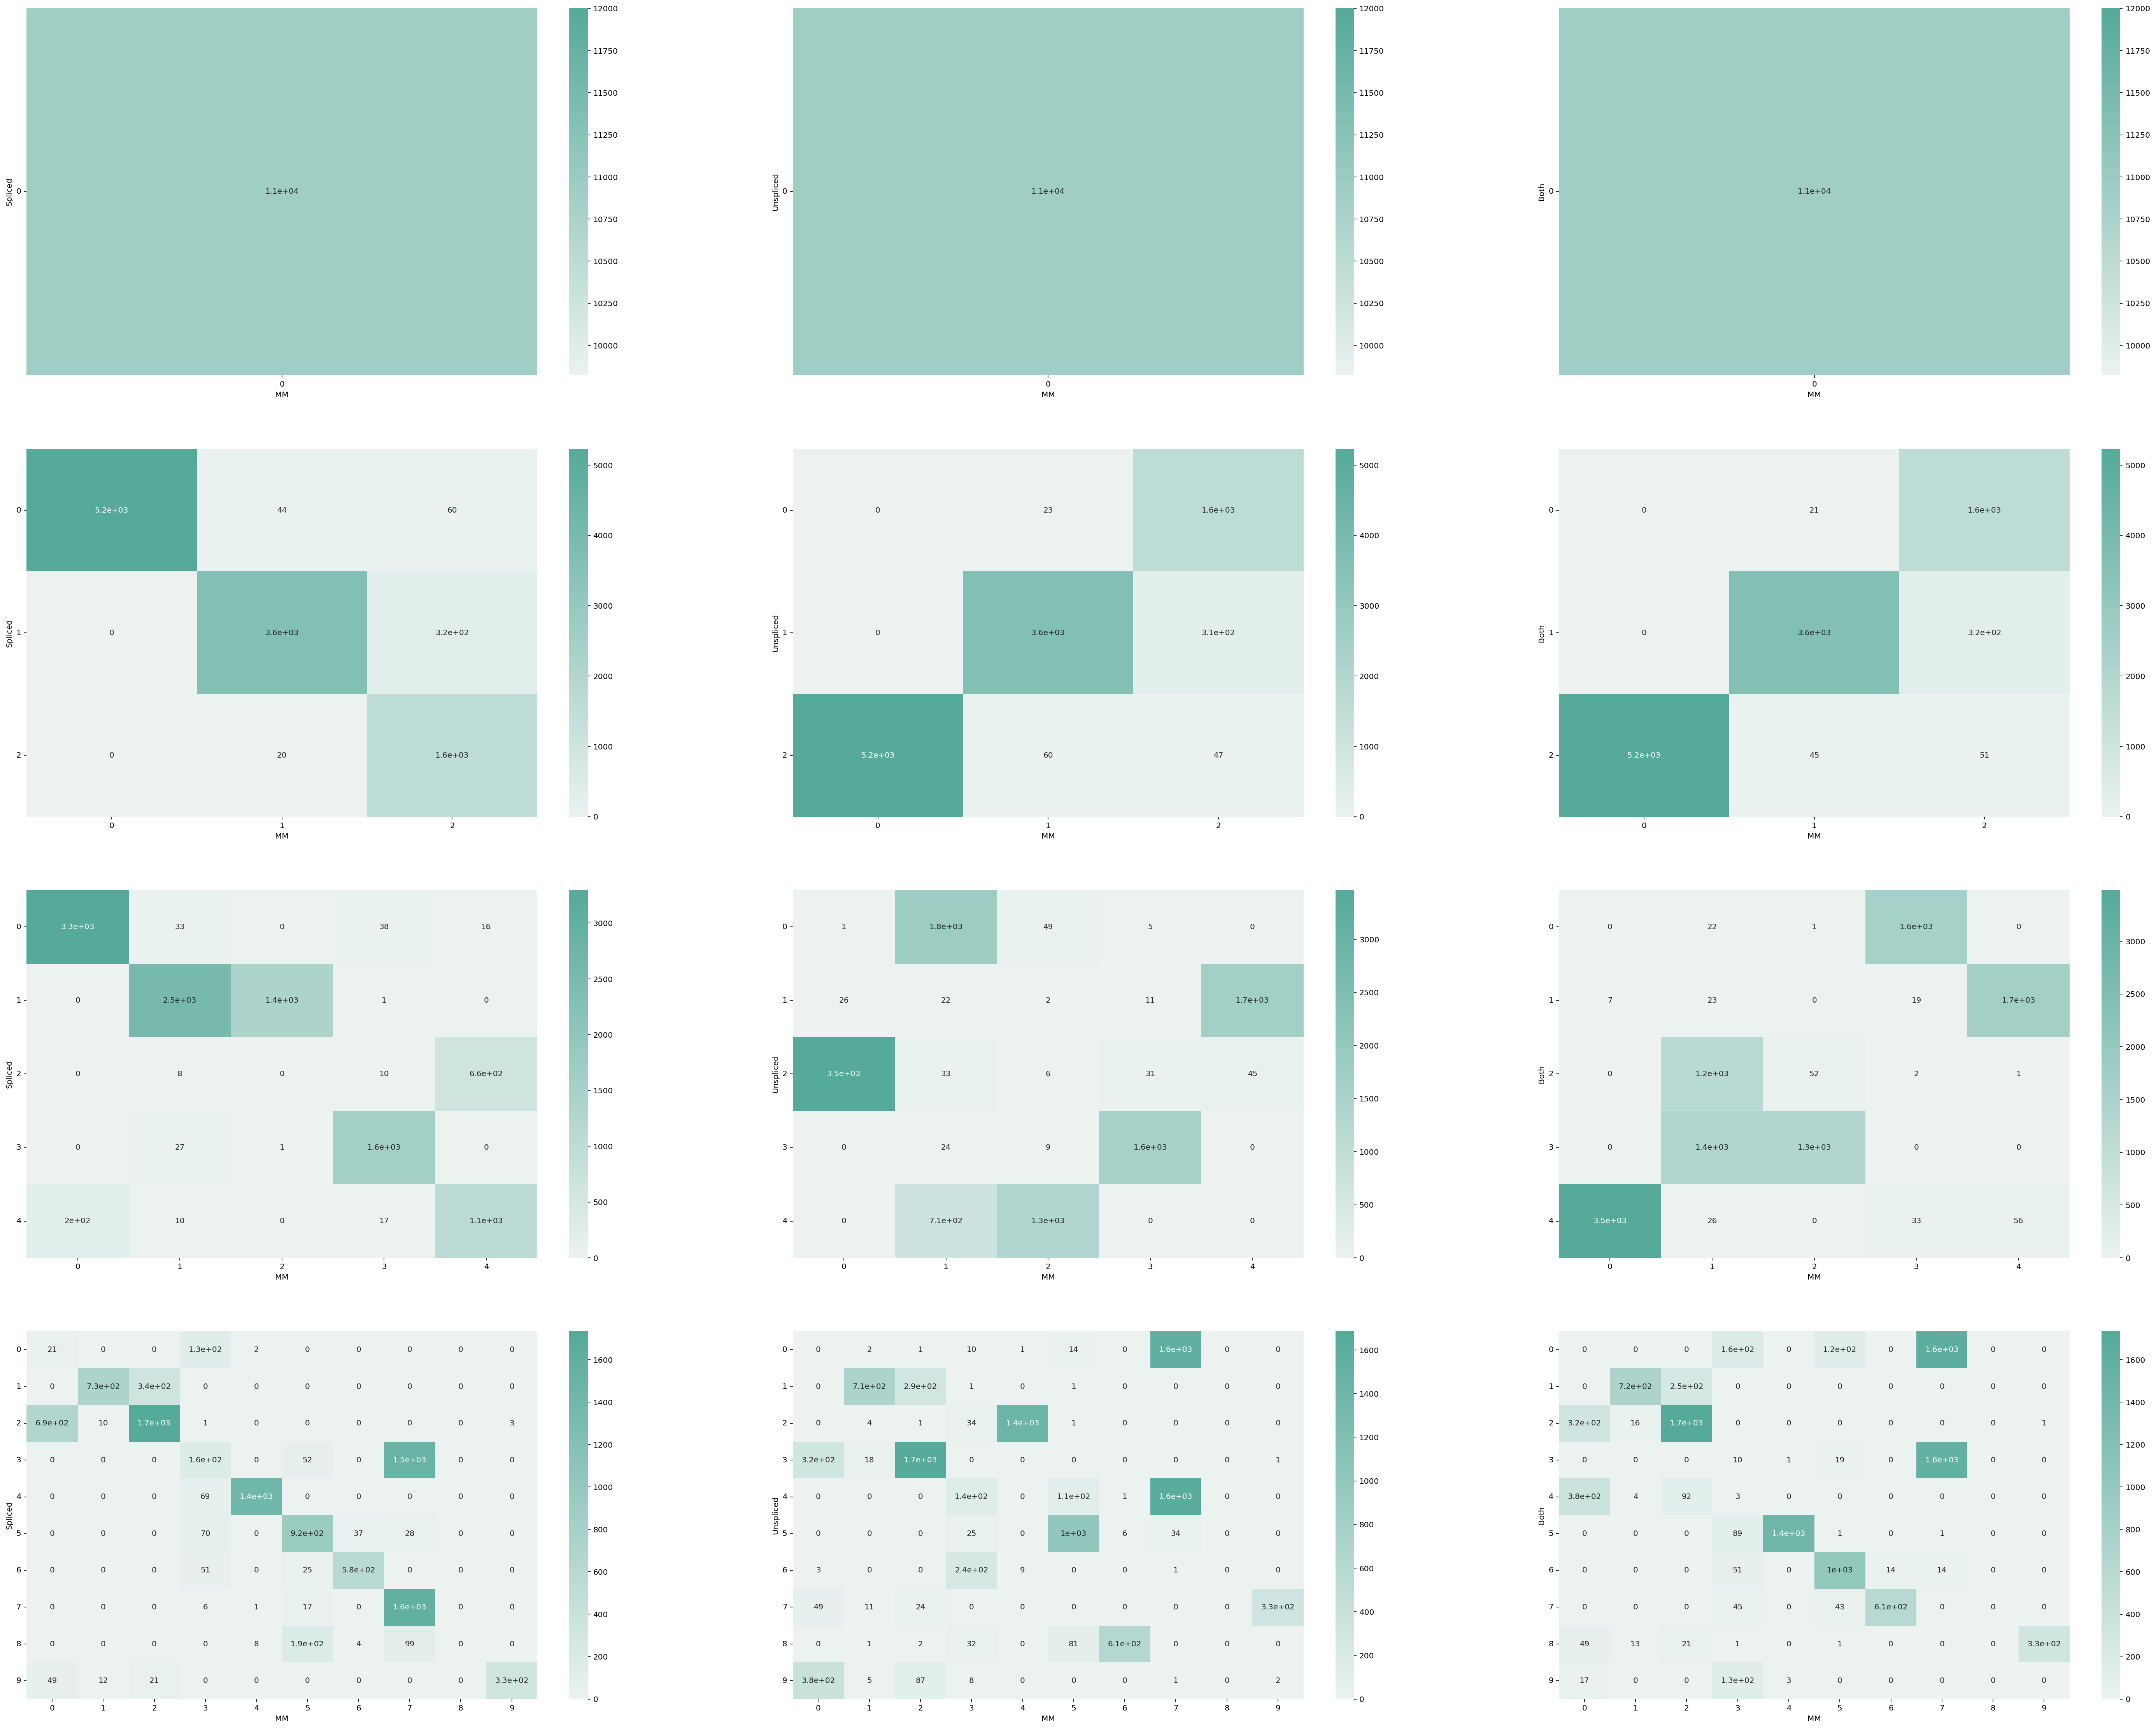

In [83]:
#Compare assignments to k-means inits
#compare overlap of all k-means assignments

num_per_set = num_ks

pairs = [(0,3),(1,3),(2,3)]
labs = [('Spliced','MM'),('Unspliced','MM'),('Both','MM')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,40))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()


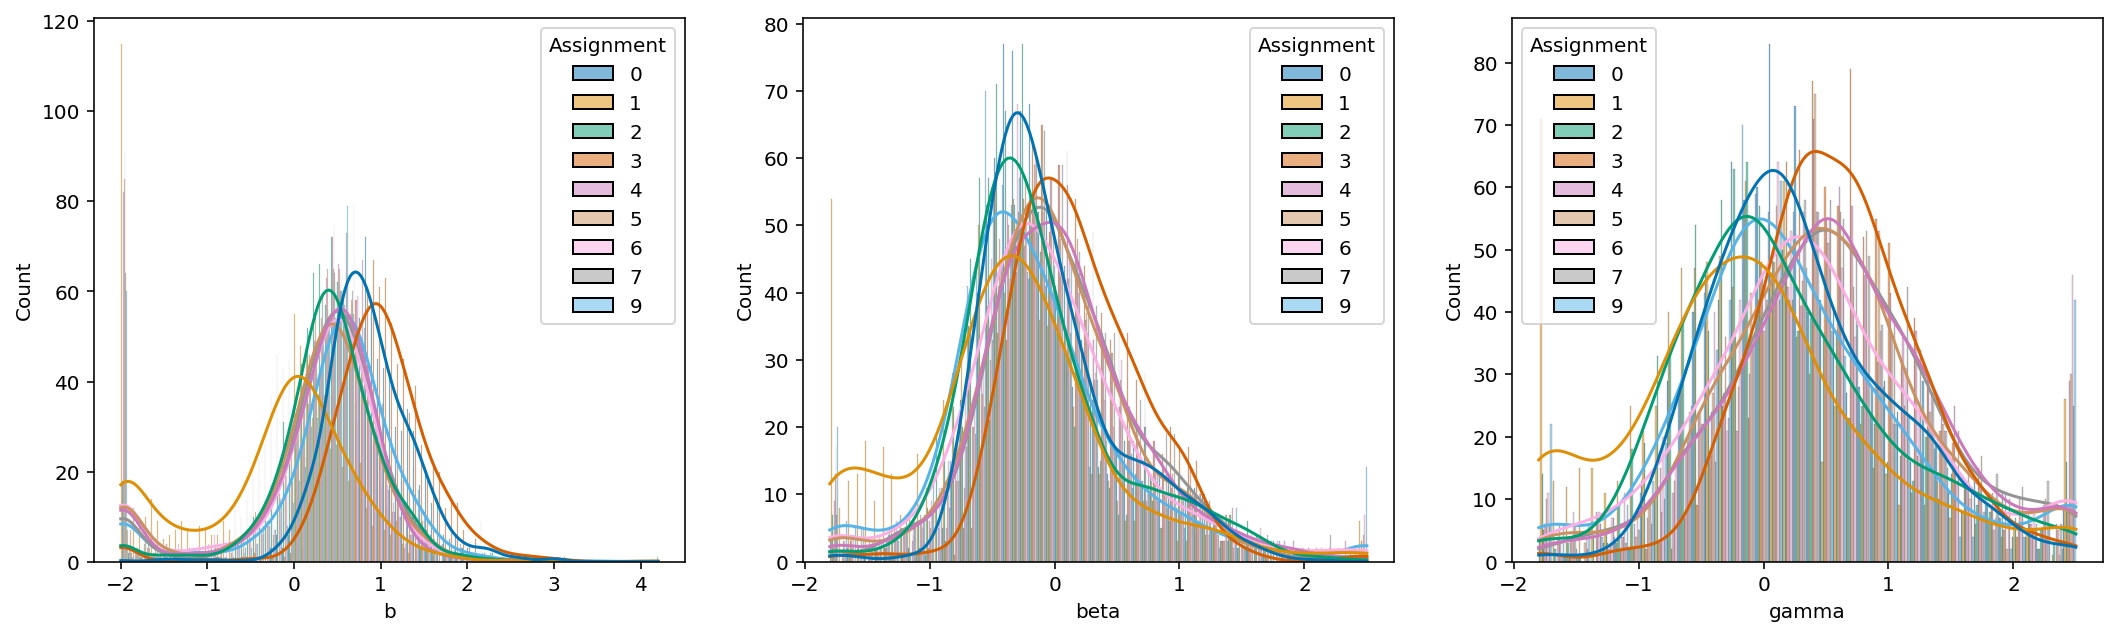

In [85]:
res = vis_params(grid_point_results[-1].param_estimates,assigns_toplot = [0,1,2,3,4,5,6,7,9],title='')

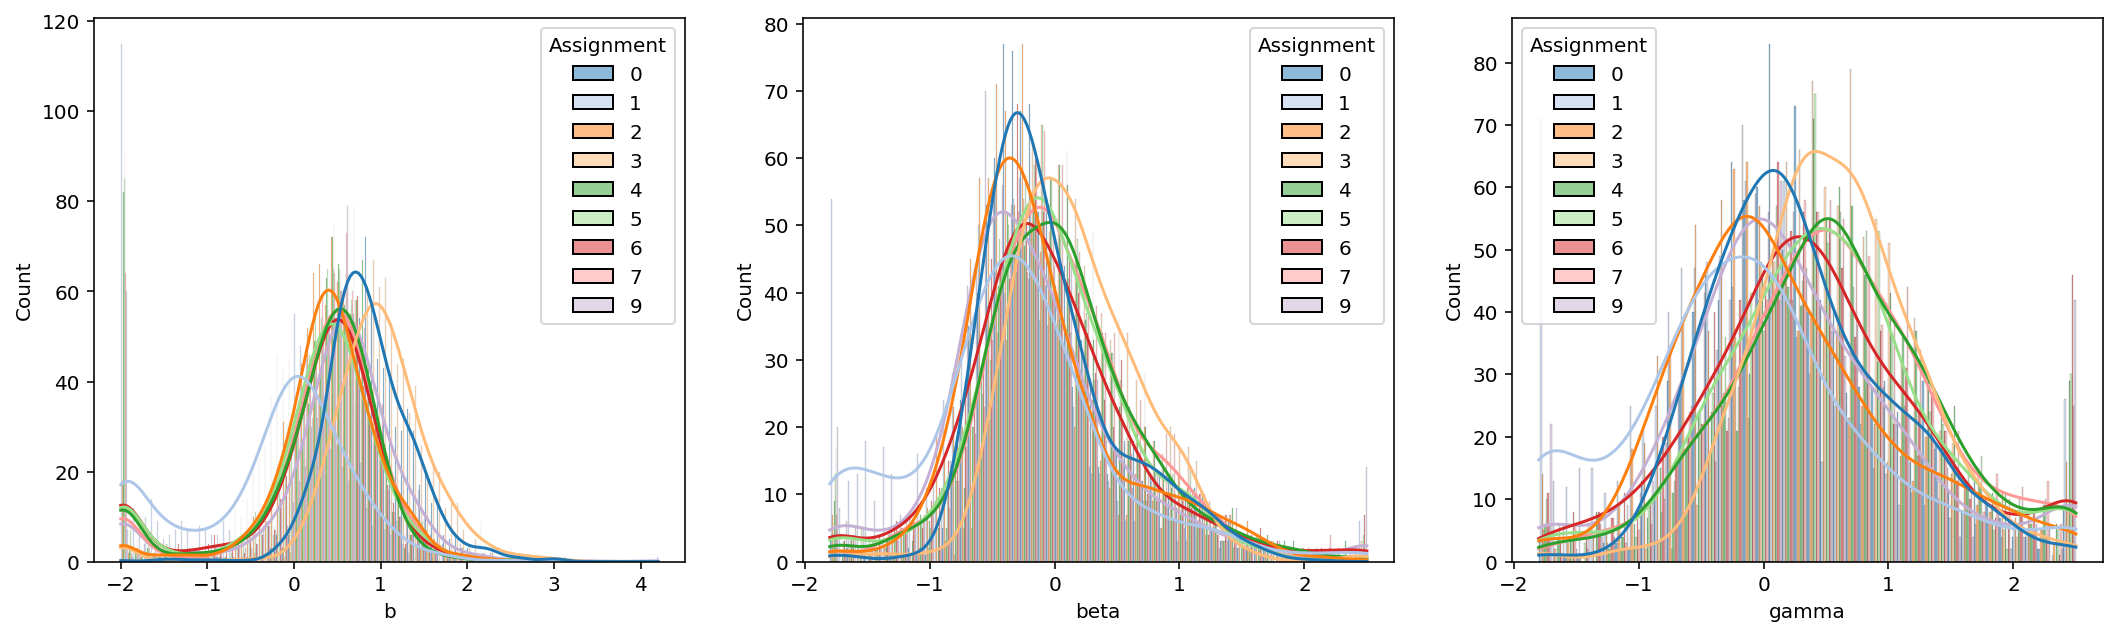

In [155]:
res = vis_params(grid_point_results[-2].param_estimates,assigns_toplot = [0,1,2,3,4,5,6,7,9],title='')

In [ ]:
#Read in known marker genes + annots from Cell Atlas (Angel/Sina)

In [86]:
full_annots = pd.read_csv('/home/tchari/metadata/pbmc_markers_merchan.txt',sep='\t',header=None)
full_annots.head()

0  \
0              AXL+, SIGLEC6+ dendritic cell   
1                           Activated B cell   
2  Activated CD4-positive, alpha-beta T cell   
3                           Activated T cell   
4           Activated effector memory T cell   

                                                   1  
0  COQ7,CDKN1A,NDRG1,BAIAP2,PIM2,PLAAT3,KLF12,MGL...  
1                              KRT20,CD19,MS4A1,CD27  
2                                              IL-7R  
3            CD38,ICOS,HLA-DRA,IL2RA,ISG20,PRF1,CD3D  
4  CXCR6,CCR4,BTLA,ICOS,TBX21,GZMA,HLA-DRA,HLA-DR...

In [156]:
check_names = search_data.gene_names

all_annots = []
for n in check_names:
    annots = []
    for i in range(len(full_annots[1])):
        
        if n in full_annots[1][i]:
            annots += [full_annots[0][i]]
    all_annots += [annots]
            
name_annot_dict = dict(zip(check_names,all_annots))
        

In [157]:
all_annots

[['Natural killer cell'],
 ['Activated effector memory T cell',
  'Monocyte',
  'Plasmacytoid dendritic cell',
  'Proliferating effector memory T cell'],
 ['CD1C-, CD141- dendritic cell', 'Myeloid cell'],
 ['Activated effector memory T cell',
  'Lymphocyte',
  'Plasmacytoid dendritic cell',
  'Proliferating effector memory T cell'],
 ['Circulating tumor cell'],
 ['Plasmacytoid dendritic cell'],
 ['Dendritic cell, human'],
 ['Effector memory CD8-positive, alpha-beta T cell'],
 ['CD1C-, CD141- dendritic cell'],
 ['Activated T cell',
  'Activated effector memory T cell',
  'B cell',
  'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
  'CD4-positive, alpha-beta T cell',
  'Central memory T cell',
  'Effector memory T cell',
  'Eosinophil',
  'Induced T-regulatory cell',
  'Inflammatory macrophage',
  'Memory T stem cell',
  'Naive T cell',
  'Proliferating effector memory T cell',
  'Regulatory T cell',
  'T cell'],
 ['CD1C-, CD141- dendritic cell'],
 ['CD14-positive monocyte',

In [158]:
inds = []
for i in range(len(all_annots)):
    if len(all_annots[i])<4:
        #if all_annots[i] == ['B cell'] or all_annots[i] == ['Myeloid cell'] or all_annots[i] == ['T cell']:
        inds += [i]
len(inds)

932

In [159]:
'CD16' in g_names

False

In [160]:
'CD19' in list(check_names)

#Tc1 (TNF alpha, INF gamma, IL-2 CXCR3, TBX21); Tc2 (IL-4, IL-5, CCR4, GATA3);
# Tc9 (IL-9, IL-10, IRF4); and Tc17 (CCR6, KLRB1, IL-17, IRF4, RORC).

False

In [161]:
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1']

toplot_marks = np.unique(toplot_marks)

In [162]:
inds = [list(check_names).index(i) for i in toplot_marks if i in check_names]

In [163]:
toshape = np.array(res['b']-res['gamma'])
toshape = toshape.reshape([9,1000])
toshape.shape

toshape = toshape[:,inds]


In [164]:
df = pd.DataFrame(toshape.T)
df.index = check_names[inds]


df.head()

0         1         2         3         4         5         6  \
ADGRE1  0.282096 -0.299420  0.211720 -0.825739 -1.925164 -2.337355 -2.011165   
CCR6   -0.357466 -1.832015 -1.379418  0.127441  0.122076 -0.043502 -1.568925   
CD2     0.582112 -0.995206 -0.493247  1.022405 -1.212429  0.827101  0.507462   
CD22   -0.060821 -1.286780 -1.169074  0.396104  0.703693 -1.639446 -1.572874   
CD247   0.380695 -0.911418 -0.387434  1.086724 -0.612073  0.884898  1.419923   

               7         8  
ADGRE1 -0.948811  0.710899  
CCR6   -0.276413 -1.193490  
CD2     0.908993 -1.040888  
CD22   -1.585785 -0.488655  
CD247   0.823411 -0.652888

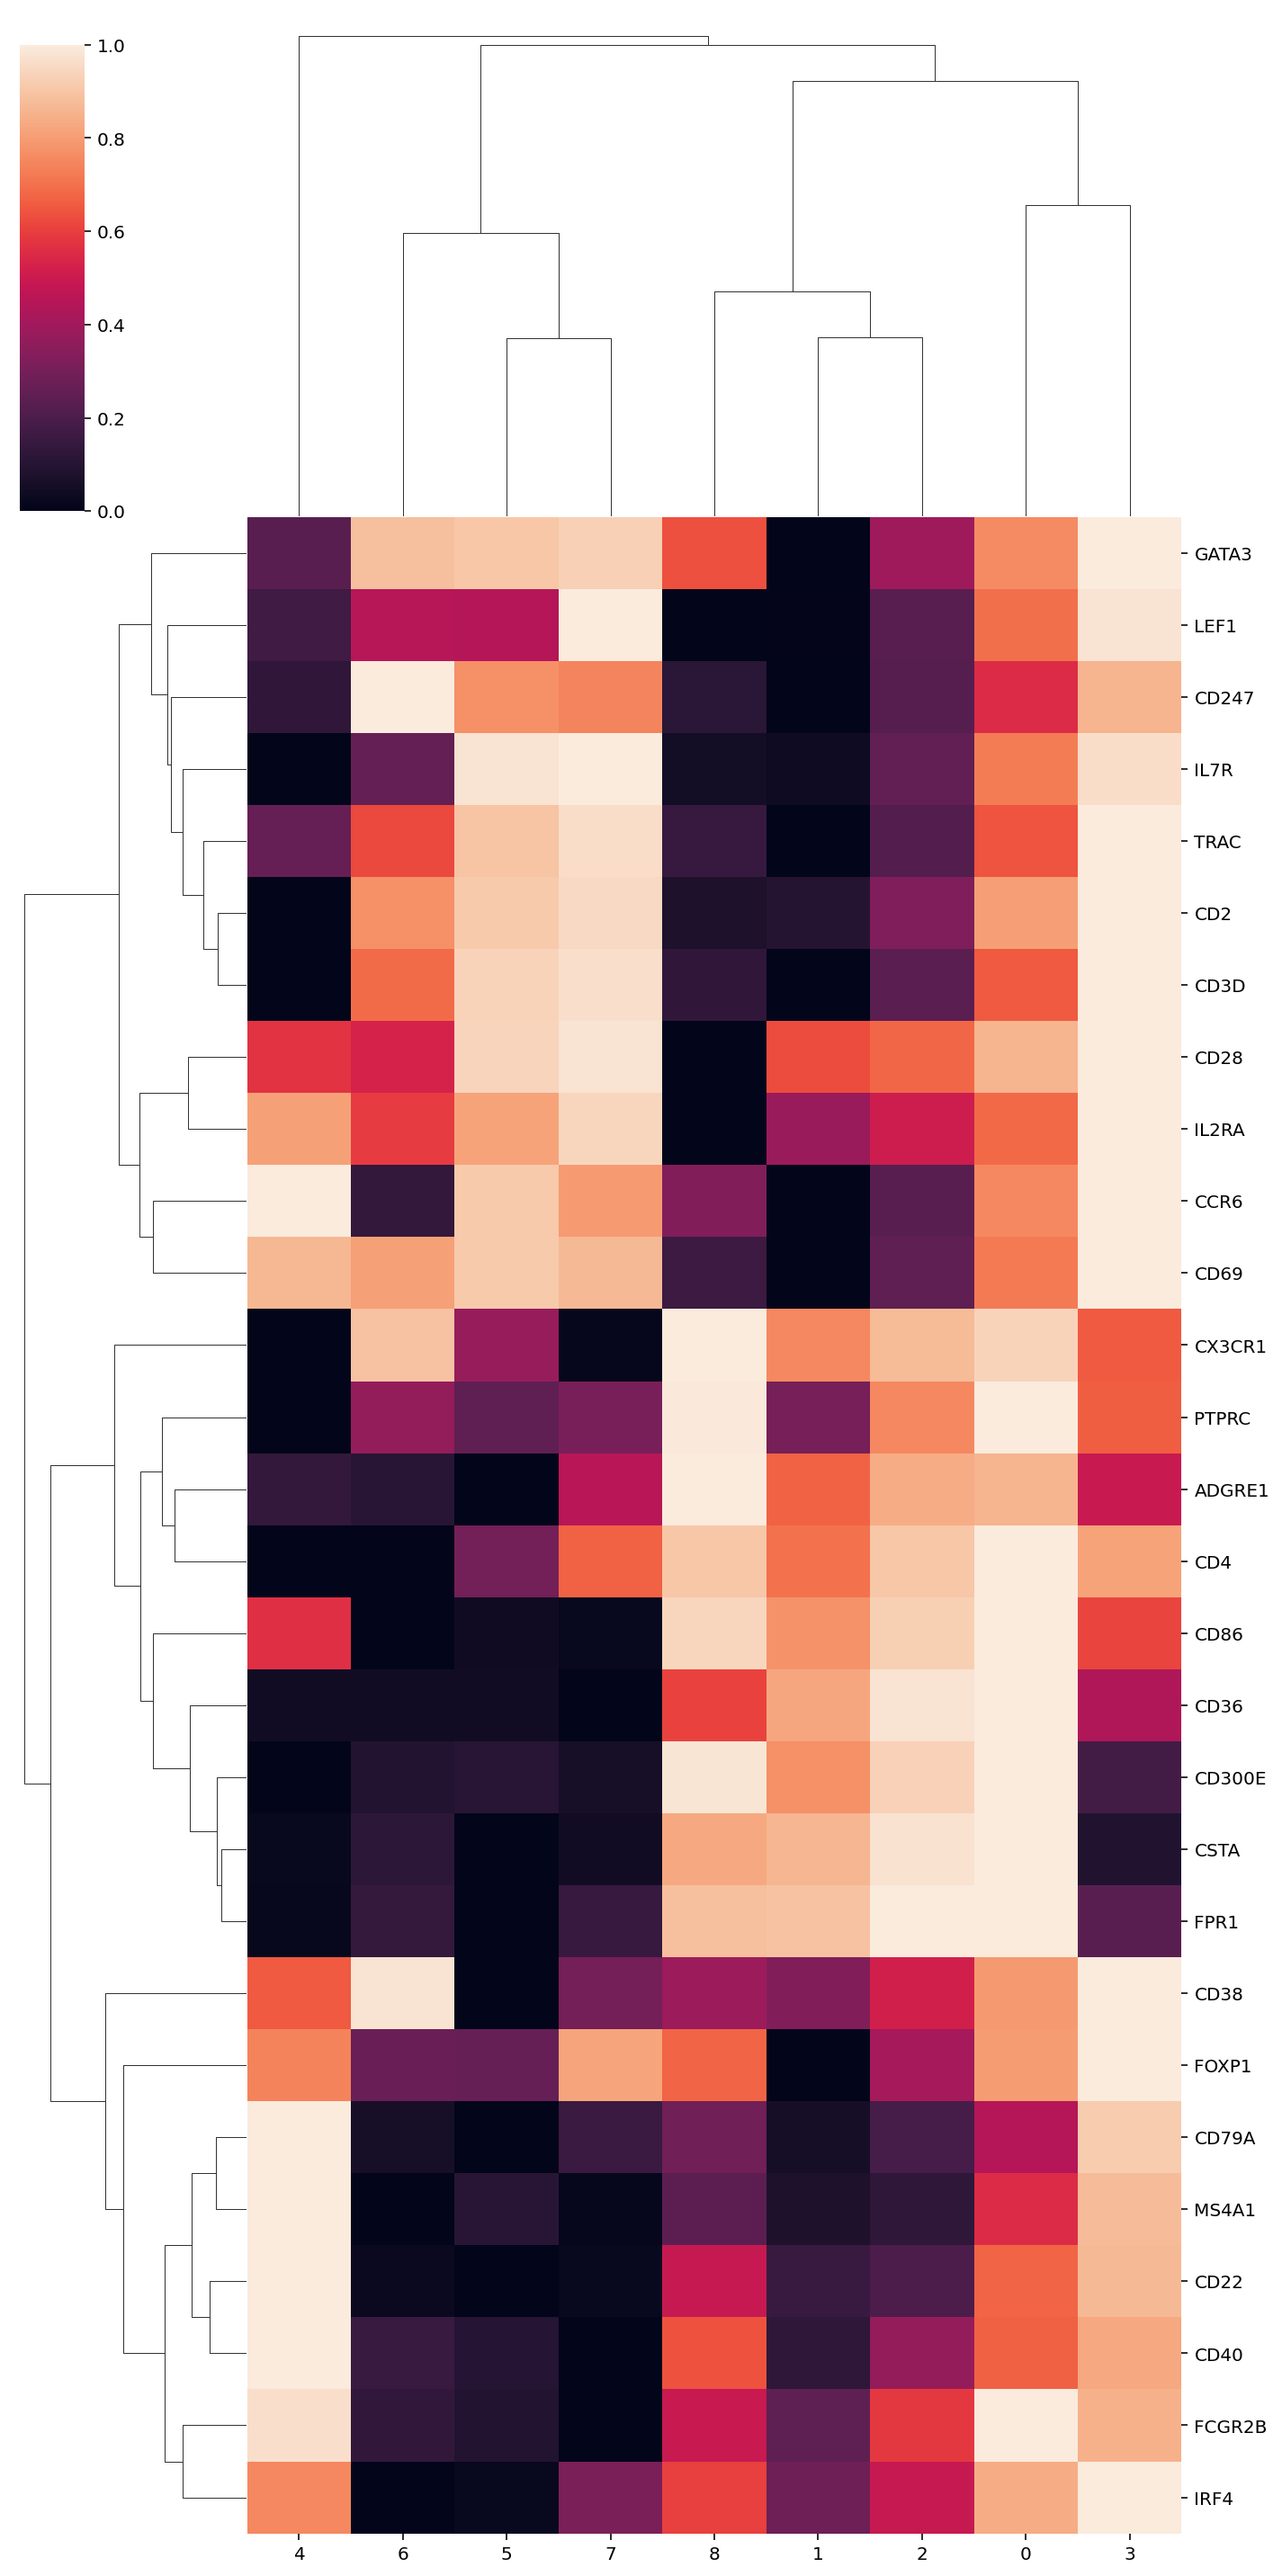

In [165]:
sns.clustermap(df,figsize=(10,20),standard_scale=0)

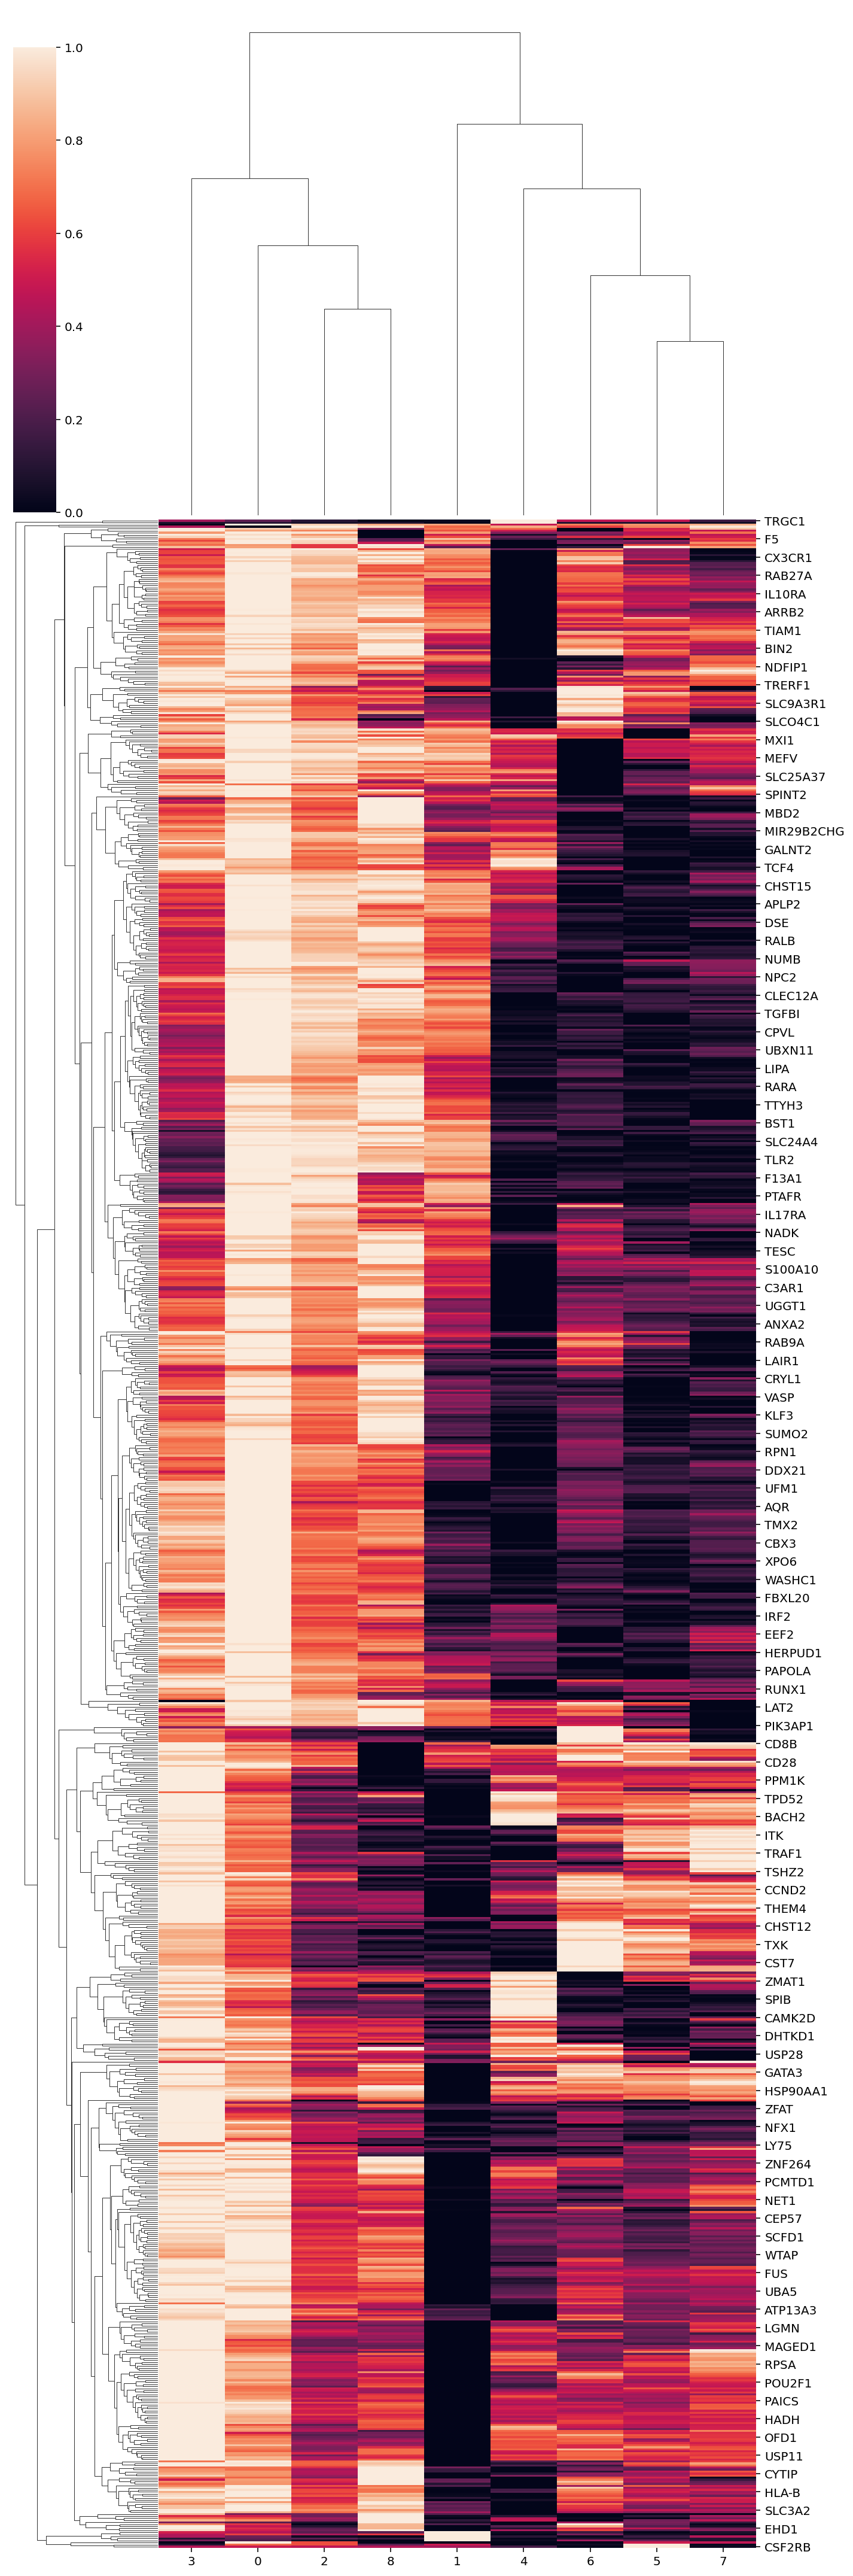

In [166]:
toshape = np.array(res['b']-res['gamma'])
toshape = toshape.reshape([9,1000])
toshape.shape


df = pd.DataFrame(toshape.T)
df.index = check_names


df.head()

sns.clustermap(df,figsize=(10,30),standard_scale=0)

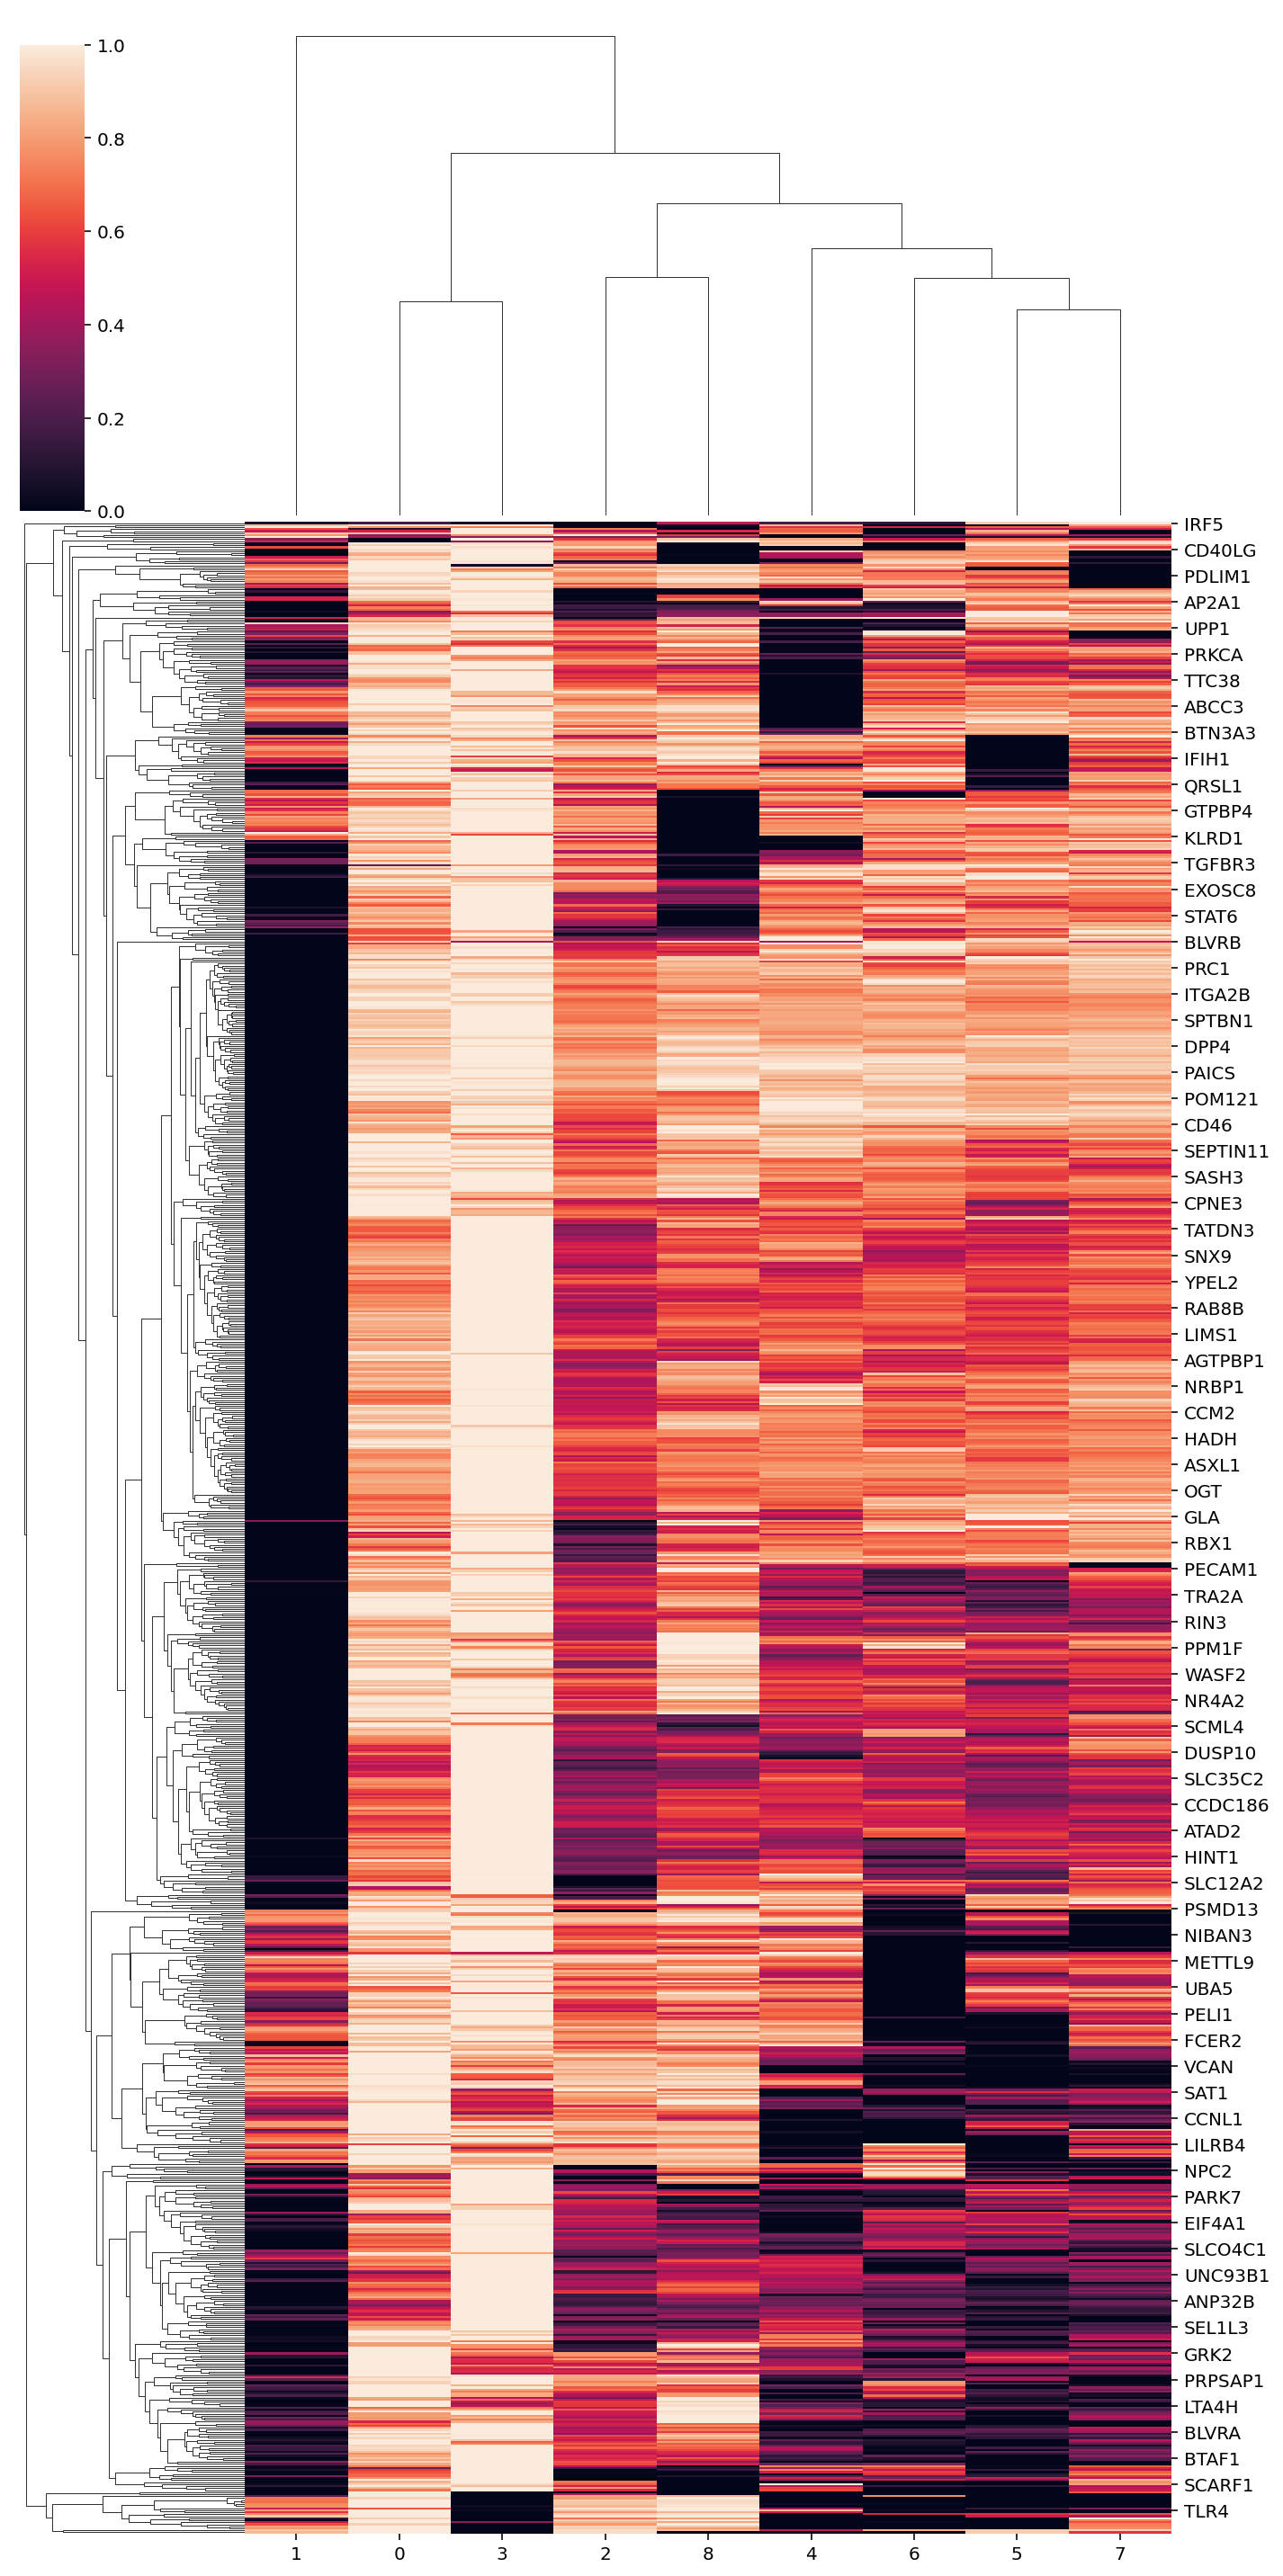

In [167]:
toshape = np.array(res['b'])
toshape = toshape.reshape([9,1000])
toshape.shape


df = pd.DataFrame(toshape.T)
df.index = check_names


df.head()

sns.clustermap(df,figsize=(10,20),standard_scale=0)

In [650]:
all_assigns

['Tcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Bcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Bcells',
 'Tcells',
 'Bcells',
 'Tcells',
 'Monocytes',
 'Bcells',
 'Tcells',
 'Monocytes',
 'Tcells',
 'Bcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Bcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Monocytes',
 'Tcells',
 'Monocytes',
 'Bcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Bcells',
 'Tcells',
 'Bcells',
 'Bcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Monocytes',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Bcells',
 'Monocytes',
 'Monocytes',
 'Tcells',
 'Monocytes',
 'Tcells',
 'Tcells',
 'Tcells',
 'Monocytes',
 'Mono

In [652]:
S.shape

(1000, 10913)

In [673]:
#check if 'b-cells' in cluster 3 actually misclassified t-cells (0-bcells, 2-tcells), cluster 4 all b-cells

U = search_data.layers[0,:,:]
U_t = U.T
S = search_data.layers[1,:,:]
S_t = S.T

S=U

cell_filt = (np.array(all_assigns)=='Bcells') & (r.assigns == 3) 
sml_bcell = S[:,cell_filt]
sml_bcell = np.mean(sml_bcell,axis=1)
print(sml_bcell.shape)

cell_filt = (np.array(all_assigns)=='Tcells') & (r.assigns == 3) 
tcell = S[:,cell_filt]
tcell = np.mean(tcell,axis=1)
print(tcell.shape)

cell_filt = (np.array(all_assigns)=='Bcells') & (r.assigns == 4) 
big_bcell = S[:,cell_filt]
big_bcell = np.mean(big_bcell,axis=1)
print(big_bcell.shape)

cell_filt = (np.array(all_assigns)=='Tcells') & (r.assigns == 7) 
big_tcell = S[:,cell_filt]
big_tcell = np.mean(big_tcell,axis=1)
print(big_tcell.shape)


(1000,)
(1000,)
(1000,)
(1000,)


In [674]:
np.corrcoef(sml_bcell,big_bcell)

array([[1.       , 0.9107806],
       [0.9107806, 1.       ]])

In [675]:
np.corrcoef(sml_bcell,tcell)

array([[1.        , 0.80245044],
       [0.80245044, 1.        ]])

In [676]:
np.corrcoef(sml_bcell,big_tcell)

array([[1.       , 0.7804865],
       [0.7804865, 1.       ]])

### **Find Parameter-DE Genes**

i.e. genes 'DE' in any parameter, for now just looking at b and beta